In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sys

sys.path.append("../")

import CoolProp.CoolProp as CP
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt  # noqa: E402
from matplotlib import rcParams  # noqa: E402
from matplotlib import font_manager  # noqa: E402
import pandas as pd  # noqa: E402

from pathlib import Path

import scipy.constants as const  # noqa: E402


from src.WellClass.libs.well_pressure.Pressure import Pressure  # noqa: E402
from src.WellClass.libs.plotting import plot_pressure  # noqa: E402
from src.WellClass.libs.pvt.pvt import (  # noqa: E402
    load_pvt_data,
    get_mixture_info,
)

In [23]:
# resource configuration
rcParams["figure.dpi"] = 150

# fount information
rcParams["font.family"] = "Equinor"
rcParams["font.size"] = 9

# font location
font_path = r"Equinor_regular"
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [25]:
pvt_path = Path(r"../src/WellClass/libs/pvt/pvt_constants")

co2_path_name = "pure_co2"
mix1_path_name = "mixture1"
mix2_path_name = "mixture2"

co2_path = pvt_path / co2_path_name
mix1_path = pvt_path / mix1_path_name
mix2_path = pvt_path / mix2_path_name


co2_mixture_info = get_mixture_info(co2_path)
co2_mixture_name = co2_mixture_info["name"]
co2_mixture_composition = co2_mixture_info["composition"]


mix1_mixture_info = get_mixture_info(mix1_path)
mix1_mixture_name = mix1_mixture_info["name"]
mix1_mixture_composition = mix1_mixture_info["composition"]

mix2_mixture_info = get_mixture_info(mix2_path)
mix2_mixture_name = mix2_mixture_info["name"]
mix2_mixture_composition = mix2_mixture_info["composition"]

print(f"Computing pressures for {co2_mixture_name} ({co2_mixture_composition})")
print(f"Computing pressures for {mix1_mixture_name} ({mix1_mixture_composition})")
print(f"Computing pressures for {mix2_mixture_name} ({mix2_mixture_composition})")


co2_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=co2_path_name)
mix1_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=mix1_path_name)
mix2_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=mix2_path_name)


Computing pressures for pure CO2 (100% CO2)
Computing pressures for mixture1 (96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4)
Computing pressures for mixture2 (95% CO2, 5% CH4)


# Tables comparison

In [26]:
olga_pure_co2_122 = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=0)
olga_pure_co2_94 = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=1)
olga_pure_co2_75 = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=2)
olga_pure_co2_47 = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=3)

olga_mix1_122 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=0)
olga_mix1_94 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=1)
olga_mix1_75 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=2)
olga_mix1_47 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=3)

olga_mix2_122 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=0)
olga_mix2_94 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=1)
olga_mix2_75 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=2)
olga_mix2_47 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=3)


In [27]:
mix2_mixture_composition


'95% CO2, 5% CH4'

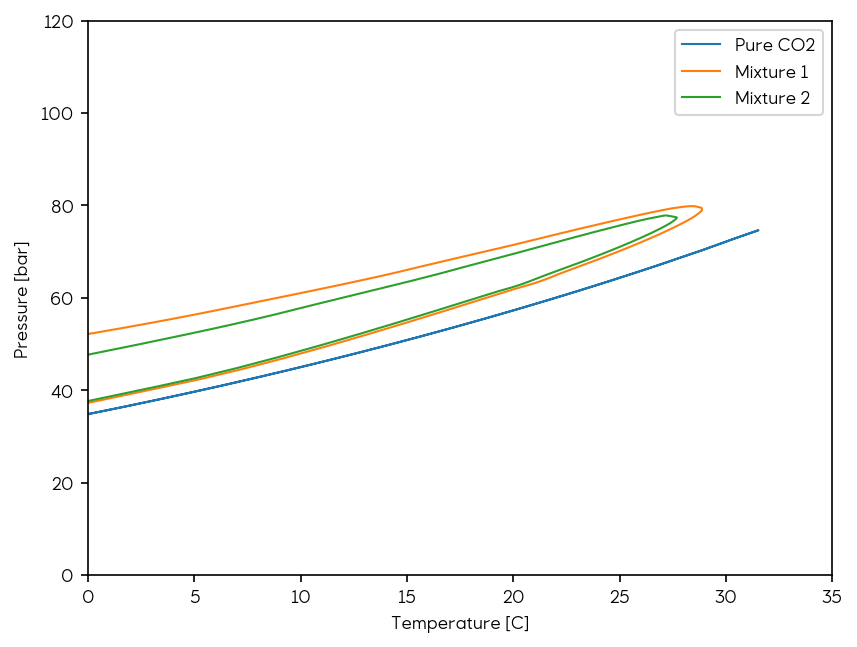

In [28]:
from scipy.interpolate import Akima1DInterpolator

def refine_envelope(envelope, k=3):
    x = np.array(envelope.T)-273.15
    y = np.array(envelope.p)/1e5

    param = np.linspace(0,1, x.size)

    spl = Akima1DInterpolator(param, np.c_[x,y])
    x_smooth, y_smooth = spl(np.linspace(0, 1, x.size * 10)).T
    return x_smooth, y_smooth

# Pure CO2
pure_co2_component = ['CO2']
pure_co2_mole_fraction = [1.0]

pure_co2_state = CP.AbstractState("HEOS", "&".join(pure_co2_component))
pure_co2_state.set_mole_fractions(pure_co2_mole_fraction)

pure_co2_state.build_phase_envelope("dummy")
pure_co2_PE = pure_co2_state.get_phase_envelope_data()

pure_co2_T, pure_co2_P = refine_envelope(pure_co2_PE)

# Mixture 1
mix1_components = ["CO2", "H2", "Argon", "Nitrogen", "Methane"]
mix1_mole_fractions = [0.96, 0.004, 0.01, 0.0082, 0.0178]

mix1_state = CP.AbstractState("HEOS", "&".join(mix1_components))
mix1_state.set_mole_fractions(mix1_mole_fractions)

mix1_state.build_phase_envelope("dummy")
mix1_PE = mix1_state.get_phase_envelope_data()

mix1_T, mix1_P = refine_envelope(mix1_PE)

# Mixture 2
mix2_components = ["CO2", "Methane"]
mix2_mole_fractions = [0.95, 0.05]

mix2_state = CP.AbstractState("HEOS", "&".join(mix2_components))
mix2_state.set_mole_fractions(mix2_mole_fractions)

mix2_state.build_phase_envelope("dummy")
mix2_PE = mix2_state.get_phase_envelope_data()

mix2_T, mix2_P = refine_envelope(mix2_PE)

fig, ax = plt.subplots()

ax.plot(pure_co2_T, pure_co2_P, "-", label="Pure CO2", lw=1)
# ax.scatter(np.array(pure_co2_PE.T)-273.15, np.array(pure_co2_PE.p)/1e5, label="Mixture 1")

ax.plot(mix1_T, mix1_P, "-", label="Mixture 1", lw=1)
# ax.scatter(np.array(mix1_PE.T)-273.15, np.array(mix1_PE.p)/1e5, label="Mixture 1")

ax.plot(mix2_T, mix2_P, "-", label="Mixture 2", lw=1)
# ax.scatter(np.array(mix2_PE.T)-273.15, np.array(mix2_PE.p)/1e5, label="Mixture 2")



ax.set_xlabel("Temperature [C]")
ax.set_ylabel("Pressure [bar]")

ax.set_xlim(0, 35)
ax.set_ylim(0, 120)
ax.legend()

In [29]:
mix1_mixture_info

{'name': 'mixture1',
 'composition': '96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4'}

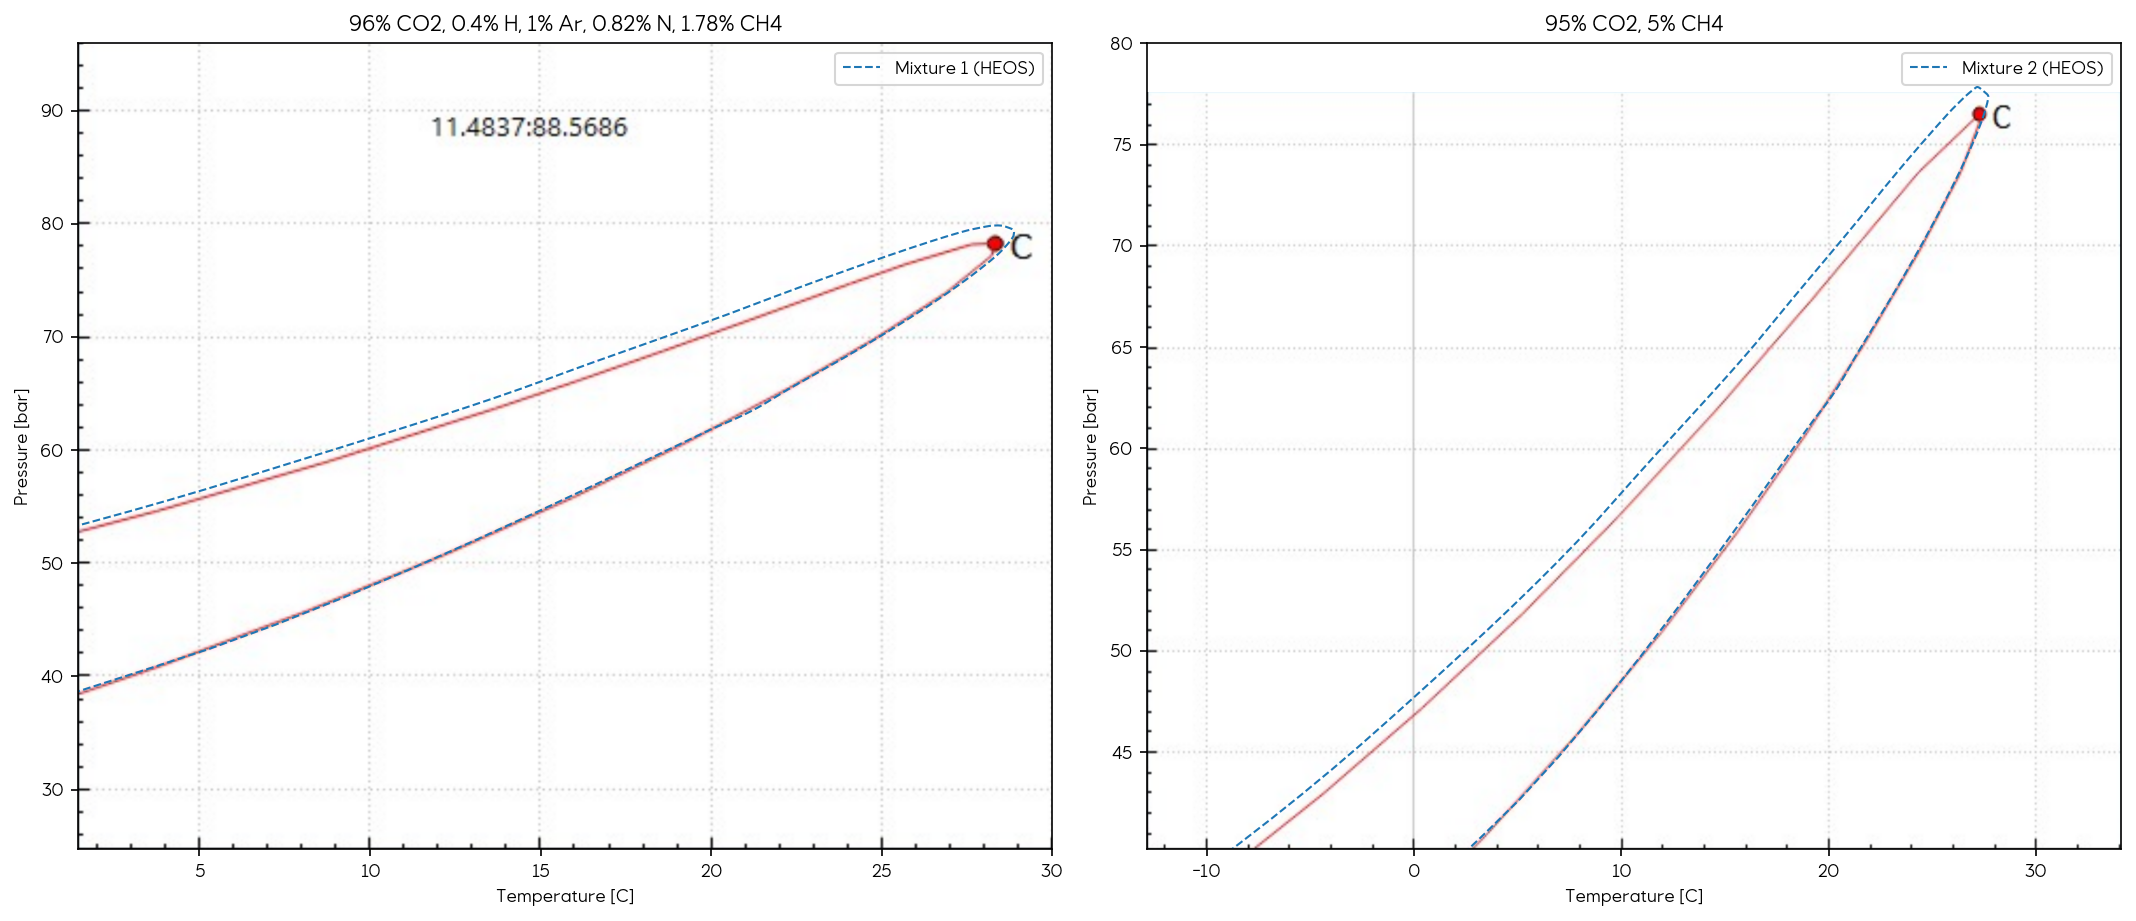

In [30]:

# Load the image
img_mix1 = Image.open(r"./olga_ref_runs/mix_1_olga_envelope.png")

# Load the image
img_mix2 = Image.open(r"./olga_ref_runs/mix_2_olga_envelope.png")


# Get image dimensions
width_pt, height_pt = img_mix1.size

# Display the image
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize=(2*width_pt / 200, height_pt / 200))

img_mix1_extents = [1.453, 30, 24.737, 95.95]

img_mix2_extents = [-12.879, 34.09403077,40.21068011, 77.574]


ax1.imshow(img_mix1, extent=img_mix1_extents, aspect='auto')


ax2.imshow(img_mix2, extent=img_mix2_extents, aspect='auto')


# ax.scatter(np.array(mix1_PE.T)-273.15, np.array(mix1_PE.p)/1e5, label="Mixture 1")
ax1.plot(mix1_T, mix1_P, "--", label="Mixture 1 (HEOS)", lw = 1)
ax2.plot(mix2_T, mix2_P, "--", label="Mixture 2 (HEOS)", lw = 1)

# # Set axis limits to match the chart's axis values
ax1.set_xlim(img_mix1_extents[0], img_mix1_extents[1])
ax1.set_ylim(img_mix1_extents[2], img_mix1_extents[3])

ax2.set_xlim(img_mix2_extents[0], img_mix2_extents[1])
ax2.set_ylim(img_mix2_extents[2], 80)

ax1.set_xlabel('Temperature [C]')
ax1.set_ylabel('Pressure [bar]')

ax1.set_title(f'{mix1_mixture_info['composition']}')


ax2.set_xlabel('Temperature [C]')
ax2.set_ylabel('Pressure [bar]')

ax2.set_title(f'{mix2_mixture_info['composition']}')

ax1.legend()
ax2.legend()


fig.tight_layout()


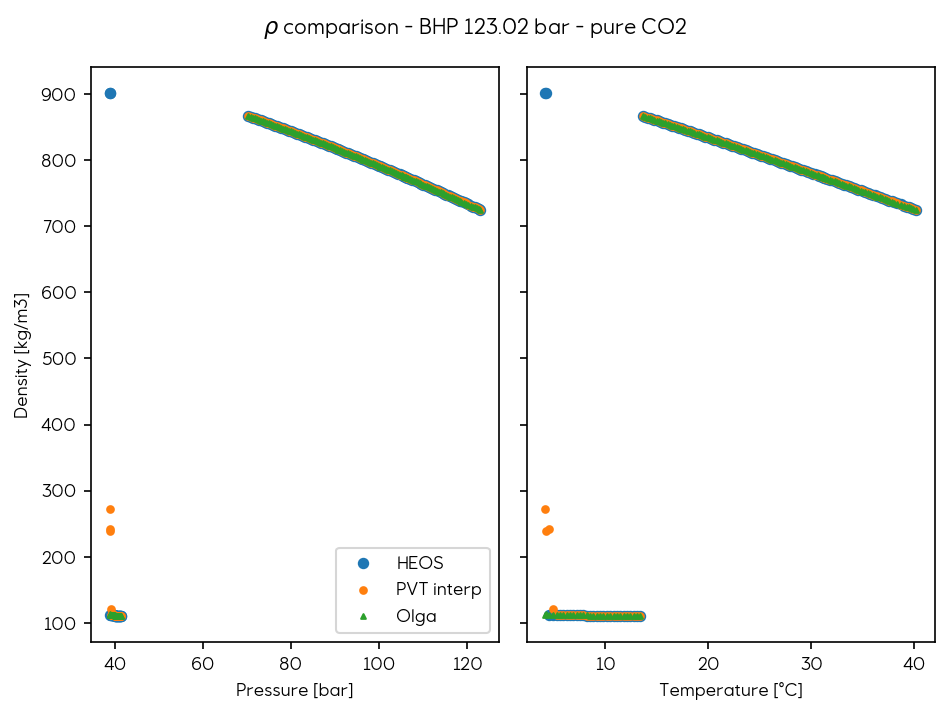

In [31]:
table = olga_pure_co2_122

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    pure_co2_state.update(CP.PT_INPUTS, P, T)
    rho = pure_co2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = co2_pvt_data["pressure"]
y = co2_pvt_data["temperature"]
z = co2_pvt_data[co2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - pure CO2")

ax1.legend()

fig.tight_layout()

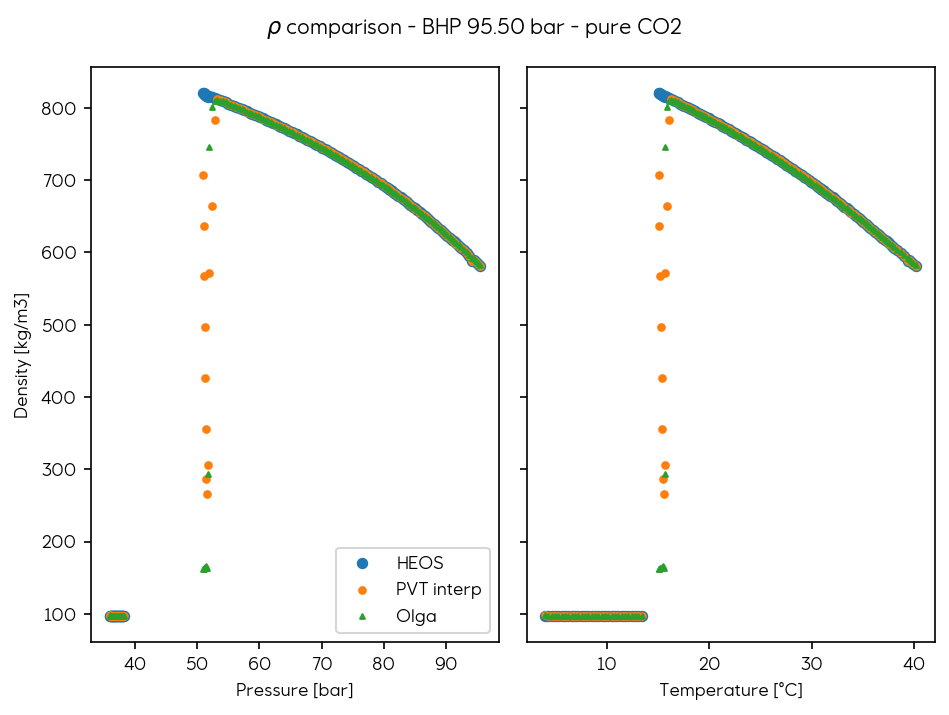

In [32]:
table = olga_pure_co2_94

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    pure_co2_state.update(CP.PT_INPUTS, P, T)
    rho = pure_co2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = co2_pvt_data["pressure"]
y = co2_pvt_data["temperature"]
z = co2_pvt_data[co2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))


fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - pure CO2")


fig.tight_layout()

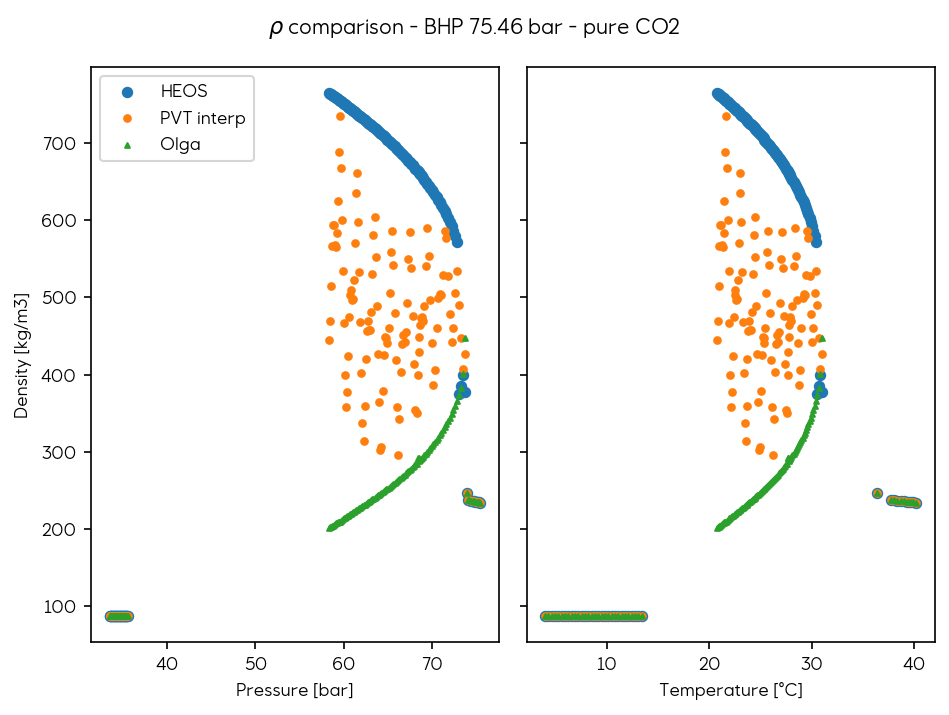

In [33]:
table = olga_pure_co2_75

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    pure_co2_state.update(CP.PT_INPUTS, P, T)
    rho = pure_co2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = co2_pvt_data["pressure"]
y = co2_pvt_data["temperature"]
z = co2_pvt_data[co2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - pure CO2")


fig.tight_layout()

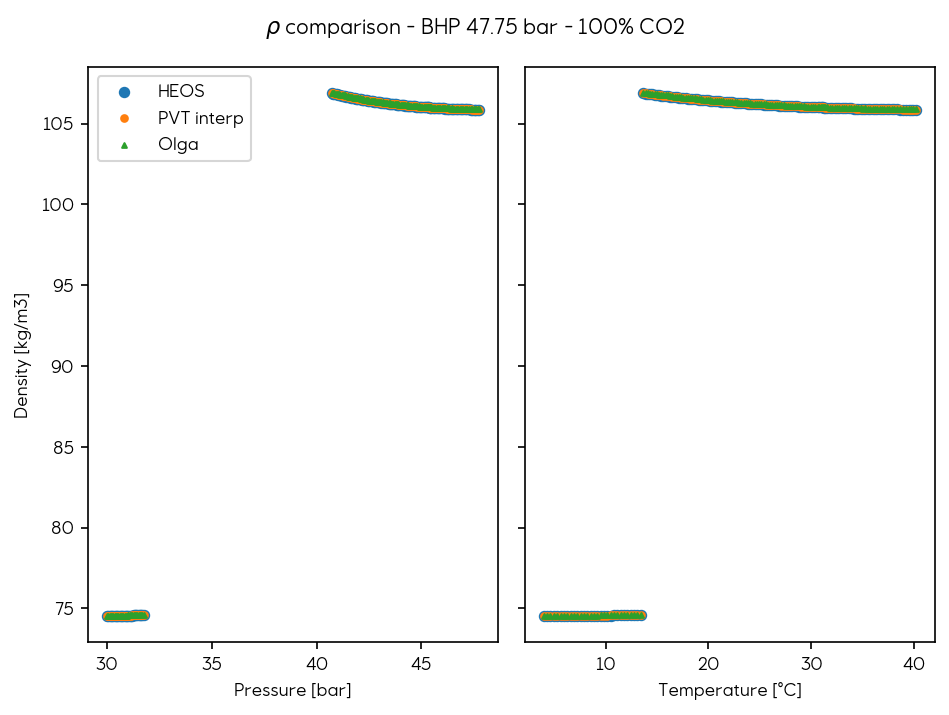

In [34]:
table = olga_pure_co2_47

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    pure_co2_state.update(CP.PT_INPUTS, P, T)
    rho = pure_co2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = co2_pvt_data["pressure"]
y = co2_pvt_data["temperature"]
z = co2_pvt_data[co2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {co2_mixture_composition}")


fig.tight_layout()

In [36]:
olga_mix1_122

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                             0.000070                             
1                                             0.001209                             
2                                             0.000128                             
3                                             0.001992                             
4                                             0.000177                             
..                                                 ...                             
147                                           1.000000                             
148                                           1.000000                             
149                                           1.000000                             
150                                           1.000000                             
151                                           1.000000                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              45.046581   
1                12.400000                              45.148140   
2                20.666666                              45.250332   
3                28.933332                              45.353180   
4                37.200001                              45.456680   
..                     ...                                    ...   
147             900.625000                             121.299896   
148             906.625000                             121.644600   
149             912.625000                             121.988899   
150             918.625000                             122.332298   
151             924.812500                             122.685600   

     Pipeline length [m].2  TM [C] (CHANNEL  PACTH) "Fluid temperature"  \
0                 4.133333                                     4.007951   
1                12.400000                                     4.335018   
2                20.666666                                     4.664342   
3                28.933332                                     4.994618   
4                37.200001                                     5.329660   
..                     ...                                          ...   
147             900.625000                                    39.301880   
148             906.625000                                    39.438061   
149             912.625000                                    39.673229   
150             918.625000                                    39.908340   
151             924.812500                                    40.150391   

     Pipeline length [m].3  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  \
0                                           124.890800                                                                                          
1                                           126.471100                                                                                          
2                                           126.505302                                                                               

In [37]:
mix1_mixture_composition

'96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4'

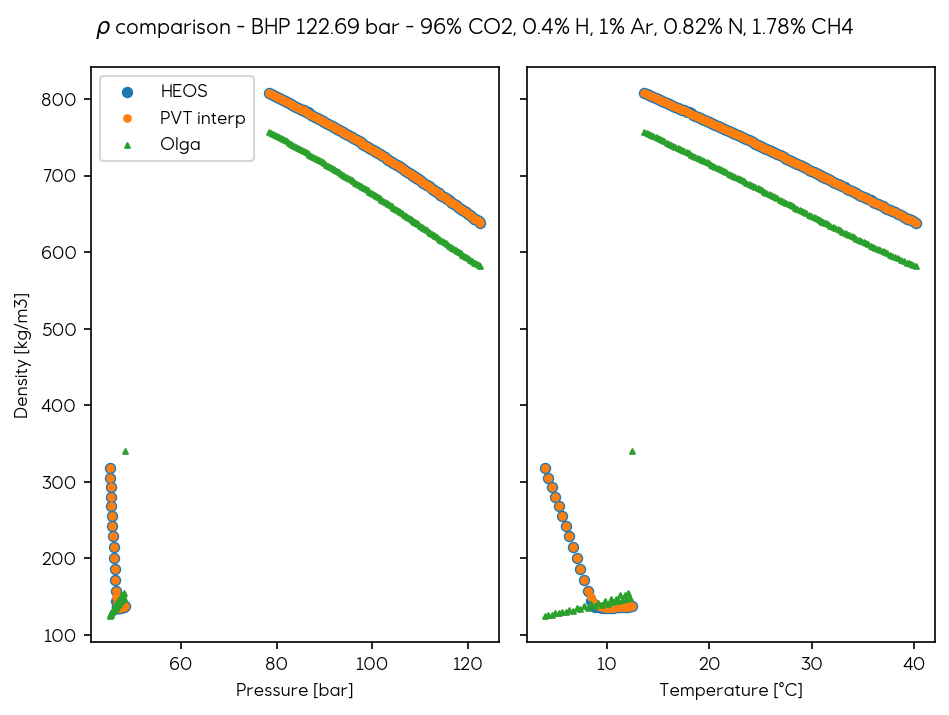

In [38]:
table = olga_mix1_122

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 5].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix1_state.update(CP.PT_INPUTS, P, T)
    rho = mix1_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = mix1_pvt_data["pressure"]
y = mix1_pvt_data["temperature"]
z = mix1_pvt_data[mix1_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 7], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 7],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix1_mixture_composition}")


fig.tight_layout()

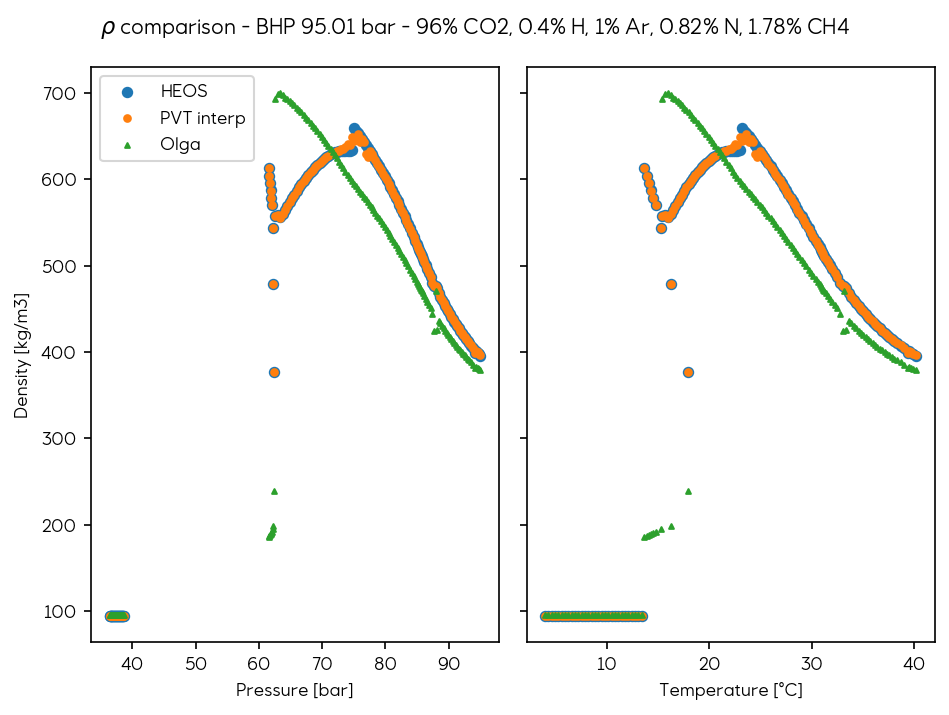

In [39]:
table = olga_mix1_94

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 5].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix1_state.update(CP.PT_INPUTS, P, T)
    rho = mix1_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = mix1_pvt_data["pressure"]
y = mix1_pvt_data["temperature"]
z = mix1_pvt_data[mix1_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 7], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 7],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()
fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix1_mixture_composition}")


fig.tight_layout()

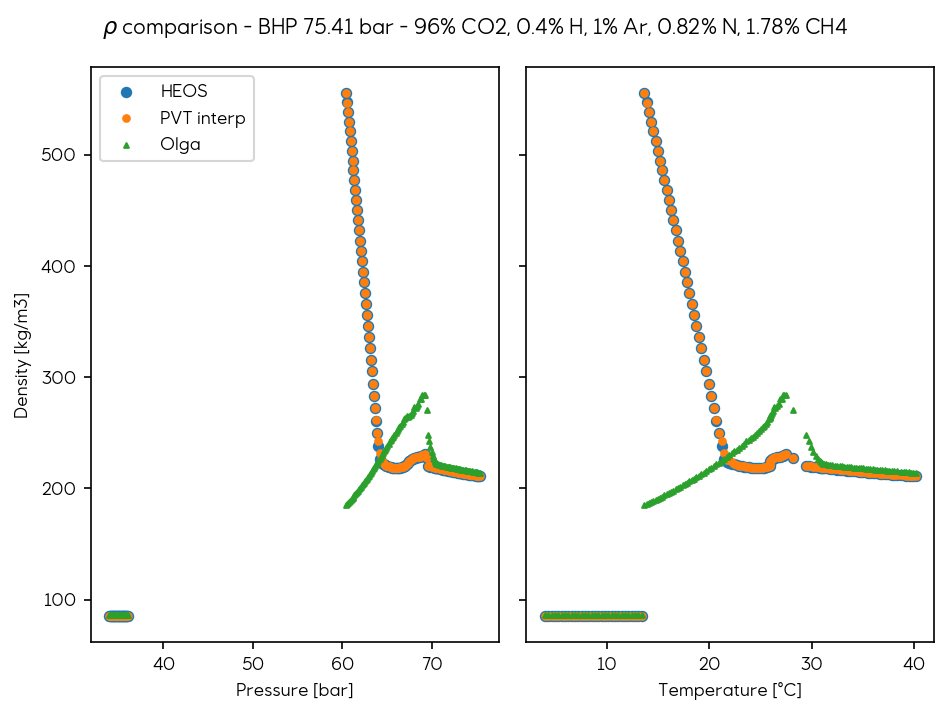

In [40]:
table = olga_mix1_75

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 5].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix1_state.update(CP.PT_INPUTS, P, T)
    rho = mix1_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = mix1_pvt_data["pressure"]
y = mix1_pvt_data["temperature"]
z = mix1_pvt_data[mix1_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 7], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 7],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix1_mixture_composition}")

fig.tight_layout()

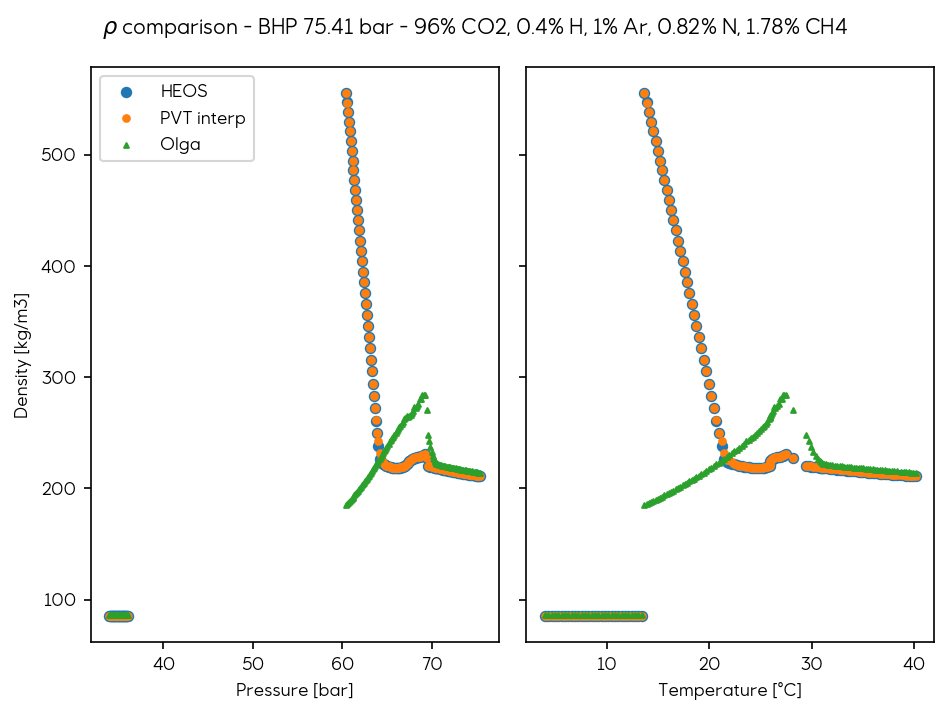

In [41]:
table = olga_mix1_75

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 5].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix1_state.update(CP.PT_INPUTS, P, T)
    rho = mix1_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = mix1_pvt_data["pressure"]
y = mix1_pvt_data["temperature"]
z = mix1_pvt_data[mix1_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 7], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 7],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix1_mixture_composition}")

fig.tight_layout()

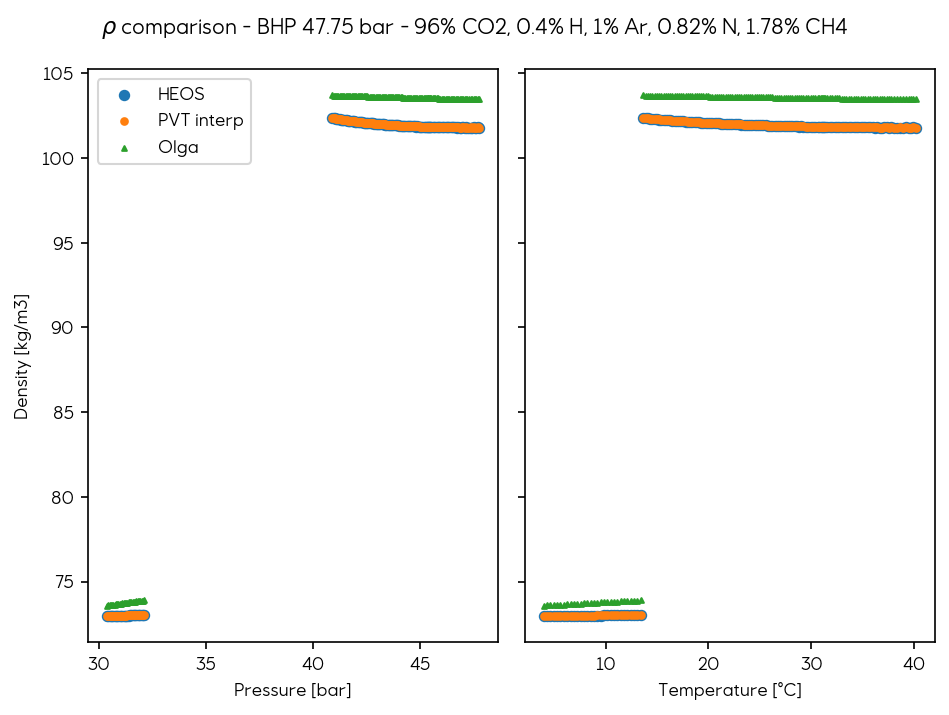

In [42]:
table = olga_mix1_47

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 5].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix1_state.update(CP.PT_INPUTS, P, T)
    rho = mix1_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = mix1_pvt_data["pressure"]
y = mix1_pvt_data["temperature"]
z = mix1_pvt_data[mix1_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 7], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 7],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix1_mixture_composition}")


fig.tight_layout()

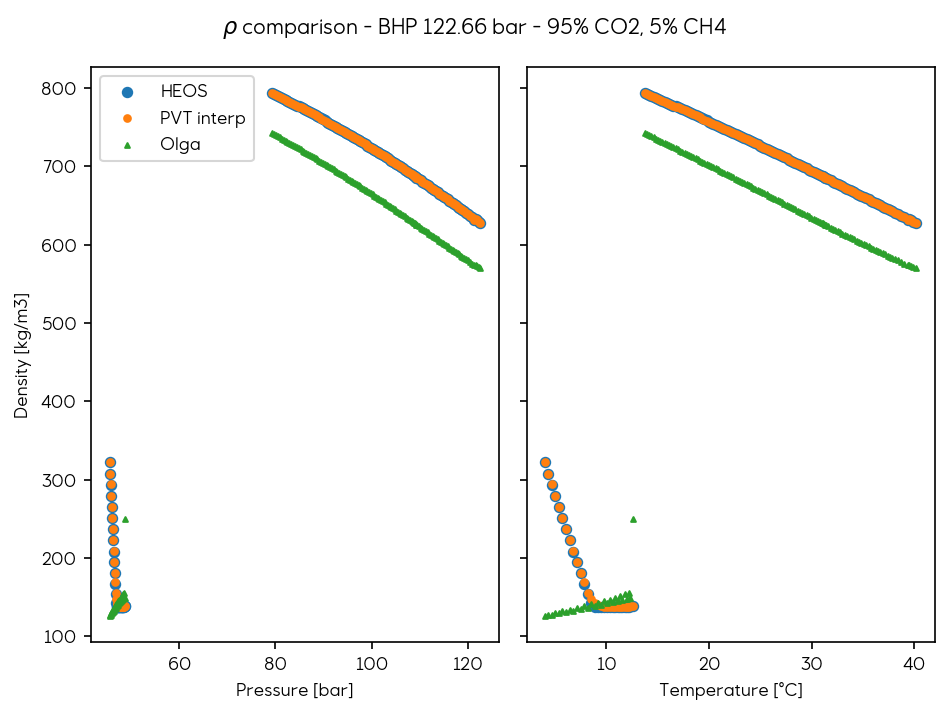

In [43]:
table = olga_mix2_122

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix2_state.update(CP.PT_INPUTS, P, T)
    rho = mix2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals



x = mix2_pvt_data["pressure"]
y = mix2_pvt_data["temperature"]
z = mix2_pvt_data[mix2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix2_mixture_composition}")


fig.tight_layout()

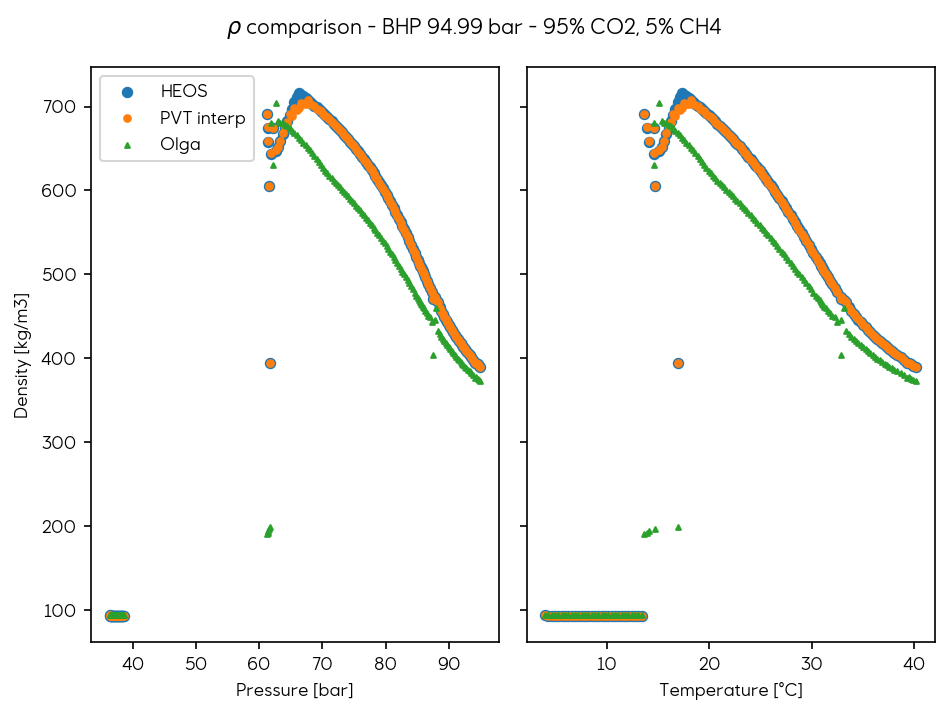

In [44]:
table = olga_mix2_94

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix2_state.update(CP.PT_INPUTS, P, T)
    rho = mix2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals



x = mix2_pvt_data["pressure"]
y = mix2_pvt_data["temperature"]
z = mix2_pvt_data[mix2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix2_mixture_composition}")


fig.tight_layout()

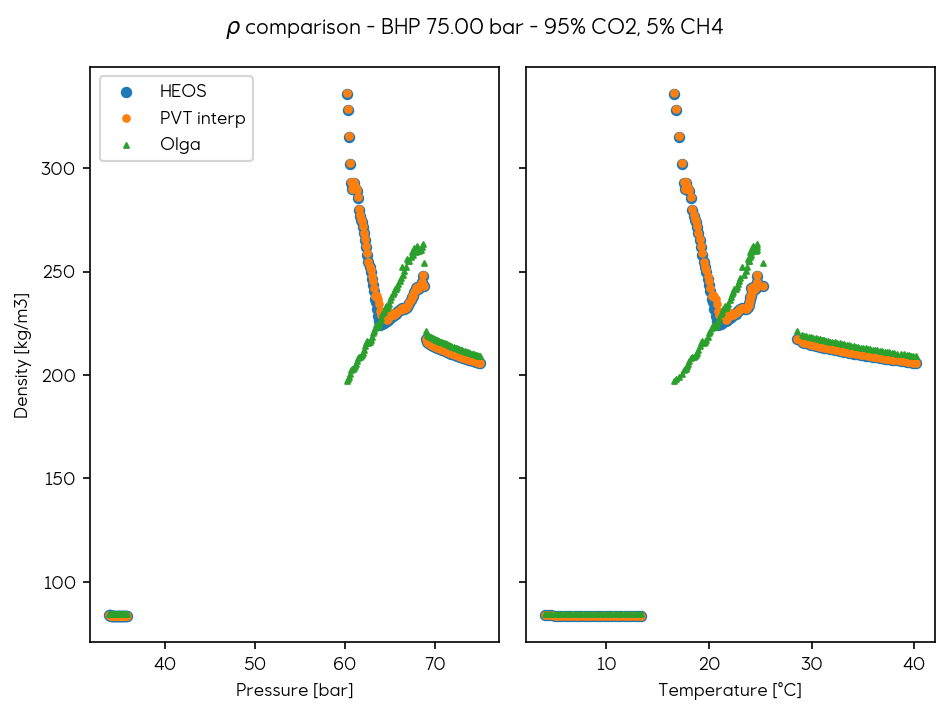

In [45]:
table = olga_mix2_75

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix2_state.update(CP.PT_INPUTS, P, T)
    rho = mix2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals



x = mix2_pvt_data["pressure"]
y = mix2_pvt_data["temperature"]
z = mix2_pvt_data[mix2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix2_mixture_composition}")


fig.tight_layout()

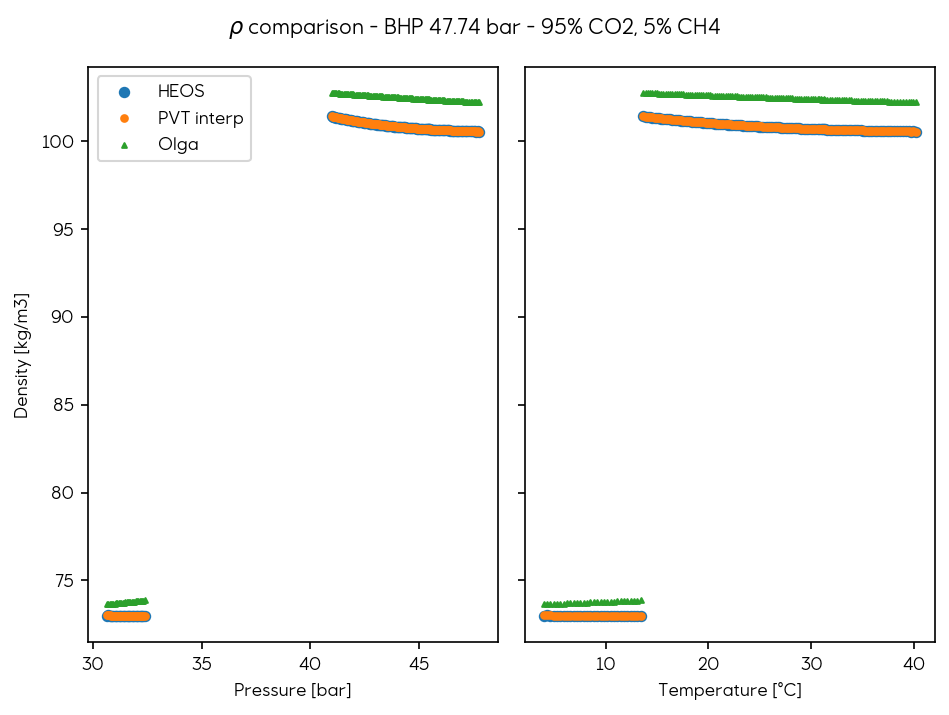

In [46]:
table = olga_mix2_47

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix2_state.update(CP.PT_INPUTS, P, T)
    rho = mix2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals



x = mix2_pvt_data["pressure"]
y = mix2_pvt_data["temperature"]
z = mix2_pvt_data[mix2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix2_mixture_composition}")


fig.tight_layout()

In [47]:
olga_mix2_122

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                             0.000082                             
1                                             0.001615                             
2                                             0.000169                             
3                                             0.002341                             
4                                             0.000244                             
..                                                 ...                             
147                                           1.000000                             
148                                           1.000000                             
149                                           1.000000                             
150                                           1.000000                             
151                                           1.000000                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              45.499271   
1                12.400000                              45.601871   
2                20.666666                              45.705109   
3                28.933332                              45.809010   
4                37.200001                              45.913582   
..                     ...                                    ...   
147             900.625000                             121.299698   
148             906.625000                             121.637398   
149             912.625000                             121.974899   
150             918.625000                             122.311600   
151             924.812500                             122.657898   

     Pipeline length [m].2  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  \
0                                           126.179802                                                                                          
1                                           128.014801                                                                                          
2                                           127.828903                                                                                          
3                                           130.115906                                                                                          
4                                           129.524796                                                                                          
..                                                 ...                                                                                          
147                                         573.506104                                                                                          
148                                         574.052612                                                                                          
149                                         572.676880                                                                                          
150                

## Pure CO2

Verification with OLGA simulations

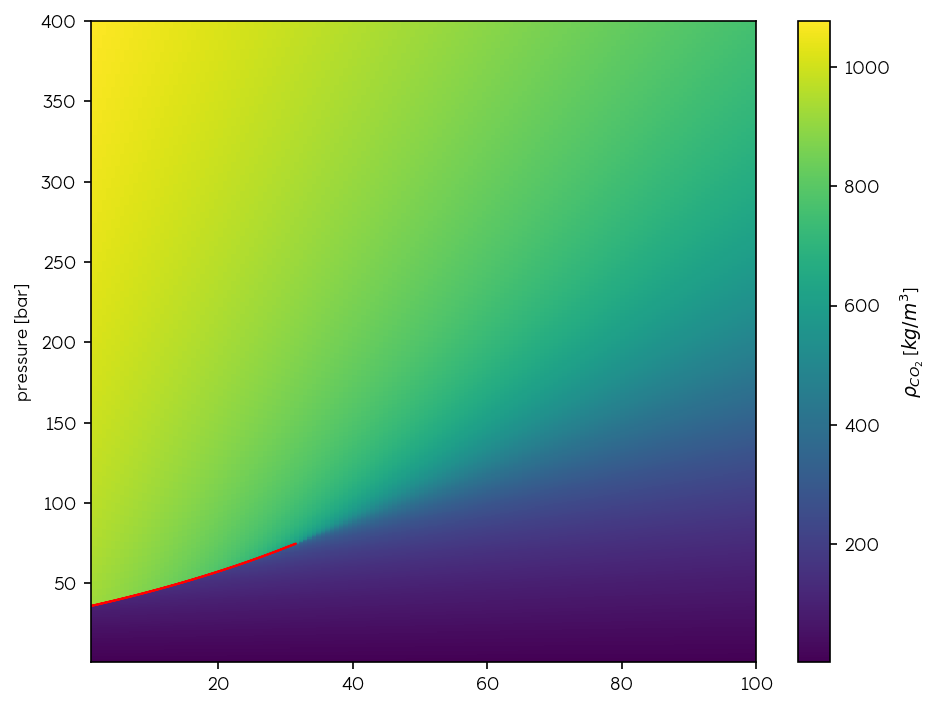

In [48]:
# Plot tables
fig, ax1 = plt.subplots()
# Plot density colormap
rho_pcm_co2 = ax1.pcolormesh(co2_pvt_data["temperature"], co2_pvt_data["pressure"], co2_pvt_data["pure_co2"]["rho"])


ax1.plot(pure_co2_T, pure_co2_P, c="r", lw=1)

ax1.set_ylabel("pressure [bar]")

ax1.set_xlim(1,100)

fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")



fig.tight_layout()

# Update PVT tables

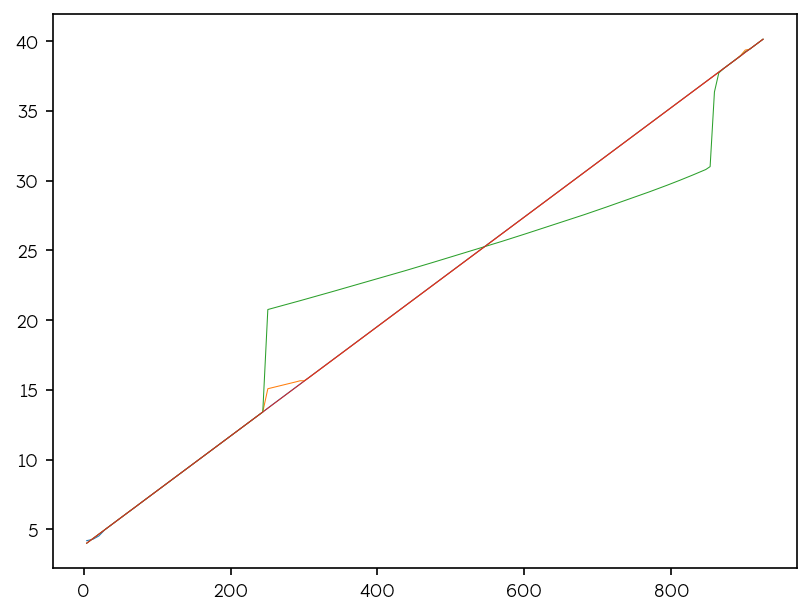

In [50]:
plt.plot(olga_pure_co2_122.iloc[:, 0], olga_pure_co2_122.iloc[:, 7], lw=0.5)
plt.plot(olga_pure_co2_94.iloc[:, 0], olga_pure_co2_94.iloc[:, 7], lw=0.5)
plt.plot(olga_pure_co2_75.iloc[:, 0], olga_pure_co2_75.iloc[:, 7], lw=0.5)
plt.plot(olga_pure_co2_47.iloc[:, 0], olga_pure_co2_47.iloc[:, 7], lw=0.5)

In [52]:
sf_depth_msl = 312  # Water depth [meters]
sf_temp_degc = 4  # temperature at sea floor [degC]
field_fluid_type = "pure_co2"

p_models = {}
olga_dict = {}

delta_z_cases = dict()

olga_tables = [olga_pure_co2_122, olga_pure_co2_94, olga_pure_co2_75, olga_pure_co2_47]

for olga_case in olga_tables:
    geo_tgrad = 1e3 * ((olga_case.iloc[-1, 7] - 4.000000) / (924.812500 - 4.133333))

    z_eq = ((olga_case.iloc[-1, 7] - sf_temp_degc) / (geo_tgrad / 1e3)) + sf_depth_msl

    delta_z = z_eq - olga_case.iloc[-1, 0]

    CO2_contact = z_eq  # CO2 water contact mTVDMSL
    press = olga_case.iloc[-1, 3]
    press_label = f"{press:.2f}"

    delta_z_cases[press_label] = delta_z

    print(f"{geo_tgrad=} {sf_temp_degc=} {CO2_contact=} {field_fluid_type=} {press=}")

    olga_dict[press_label] = olga_case
    # '''Constants'''

    # geo_tgrad = 40 #geothermal gradient [degc/km]
    p_models[press_label] = Pressure(
        # wellbore seafloor depth mTVD MSL.
        sf_depth_msl=sf_depth_msl,  # wellbore.water_depth,
        # wellbore total depth in mTVD RKB
        well_td_rkb=5e3,  # total_depth_rkb,
        # wellbore rkb in mTVD RKB
        well_rkb=0,
        # seafloor temperature in degC
        sf_temp=sf_temp_degc,  # DEFAULT_SEAFLOOR_TEMPERATURE,
        # geothermal gradient in degC/km
        geo_tgrad=geo_tgrad,  # DEFAULT_GEOTHERMAL_GRADIENT,
        fluid_type=field_fluid_type,  # type: ignore
        # path to the pvt constants folder
        pvt_path=pvt_path,
        z_fluid_contact=CO2_contact,  # wellbore_settings.pressure_datum_tvd_msl,  # type: ignore
        p_fluid_contact=press,  # wellbore_settings.reservoir_pressure_bar,  # type: ignore
        # specific_gravity=None,  # type: ignore
        # ip_shmin_data=shmin_data,
        shmin_gradient=0.3,
    )

geo_tgrad=np.float64(39.26466790918936) sf_temp_degc=4 CO2_contact=np.float64(1232.679167) field_fluid_type='pure_co2' press=np.float64(123.02449798584)
Computing pressure profile for scenario: hydrostatic
geo_tgrad=np.float64(39.26493722702677) sf_temp_degc=4 CO2_contact=np.float64(1232.679167) field_fluid_type='pure_co2' press=np.float64(95.4954299926758)


Computing pressure profile for scenario: hydrostatic
geo_tgrad=np.float64(39.26460161556778) sf_temp_degc=4 CO2_contact=np.float64(1232.679167) field_fluid_type='pure_co2' press=np.float64(75.4576873779297)
Computing pressure profile for scenario: hydrostatic
geo_tgrad=np.float64(39.264493888432796) sf_temp_degc=4 CO2_contact=np.float64(1232.679167) field_fluid_type='pure_co2' press=np.float64(47.751220703125)
Computing pressure profile for scenario: hydrostatic


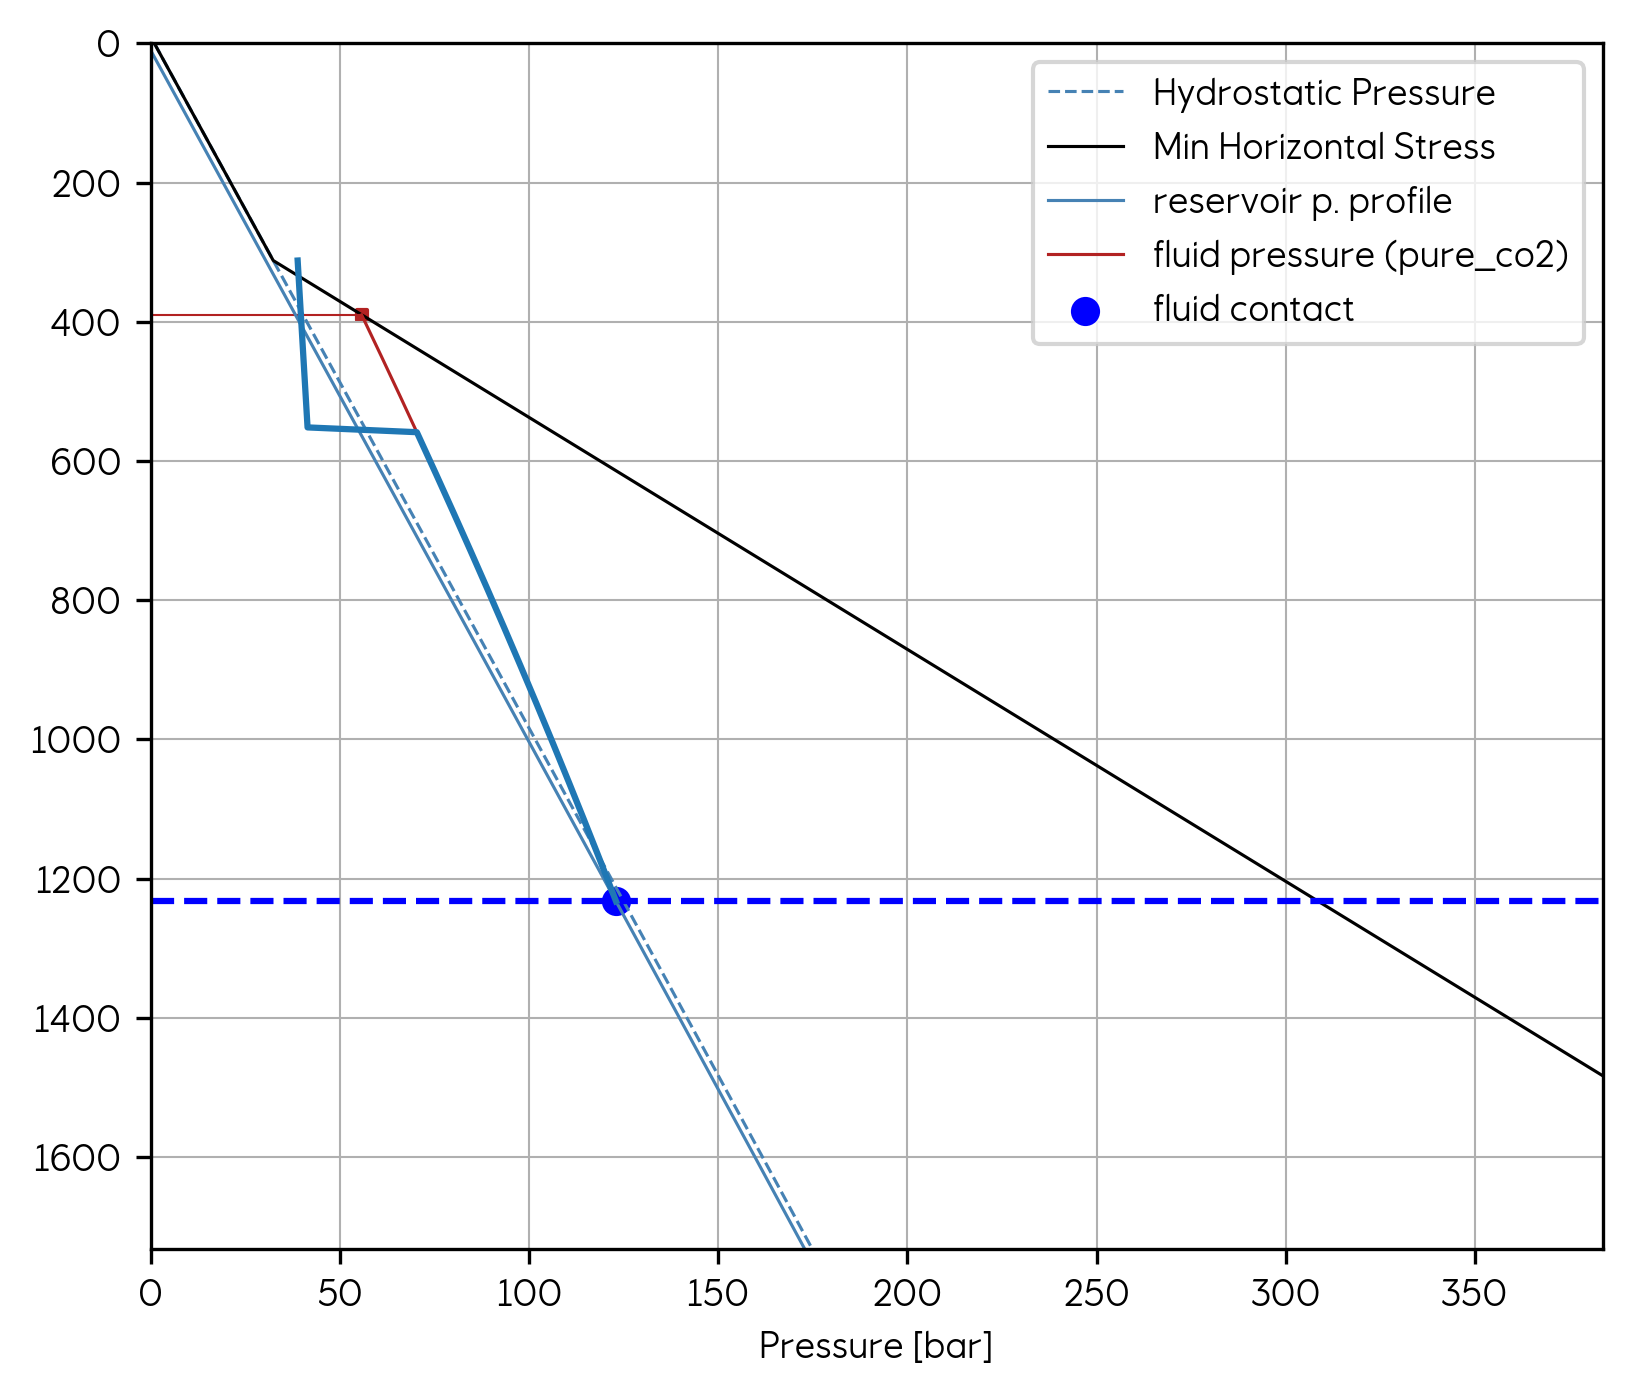

In [53]:
rcParams["figure.dpi"] = 300

width_cm = 14  # cm
height_cm = 12  # cm

width = width_cm / 2.54
height = height_cm / 2.54

fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = "123.02"

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

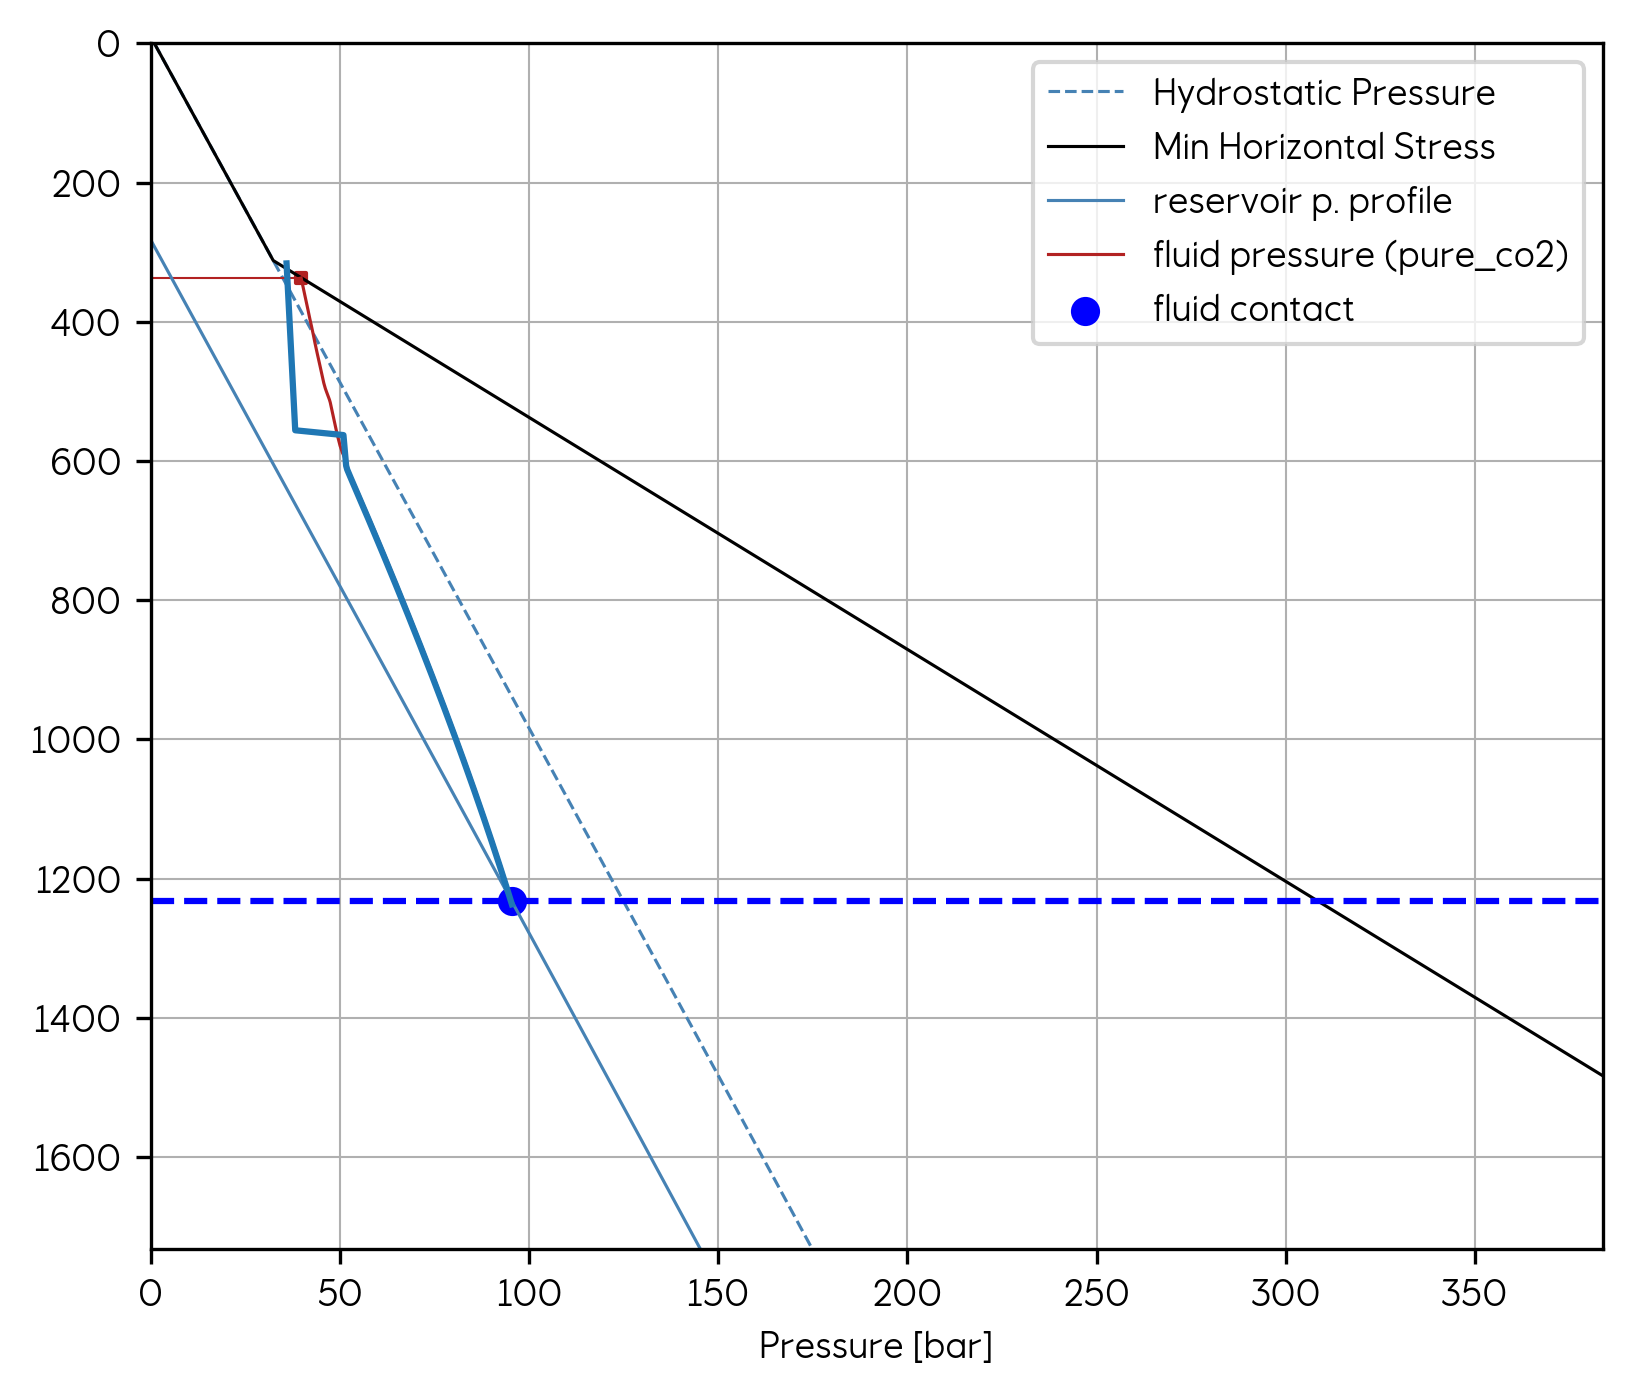

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[1]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

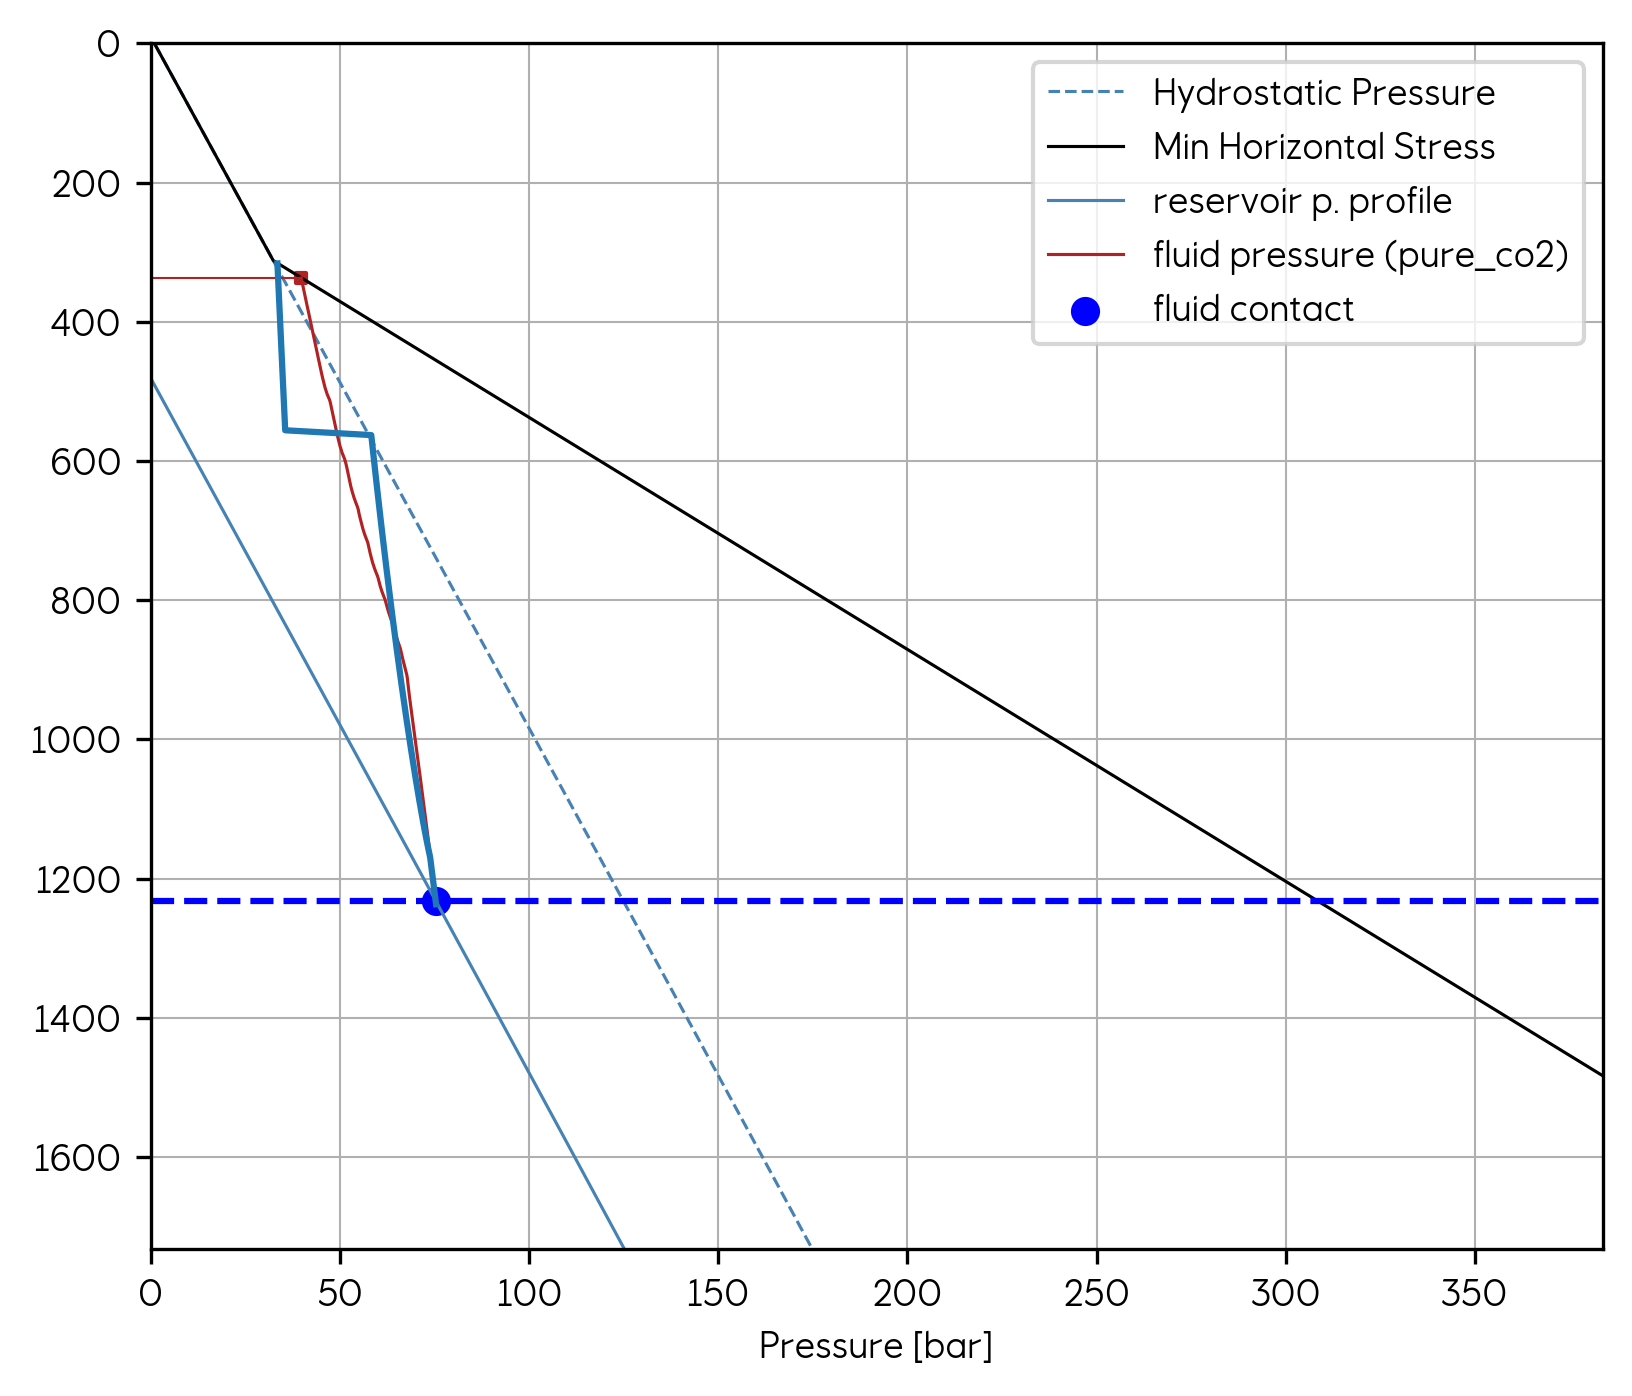

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[2]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

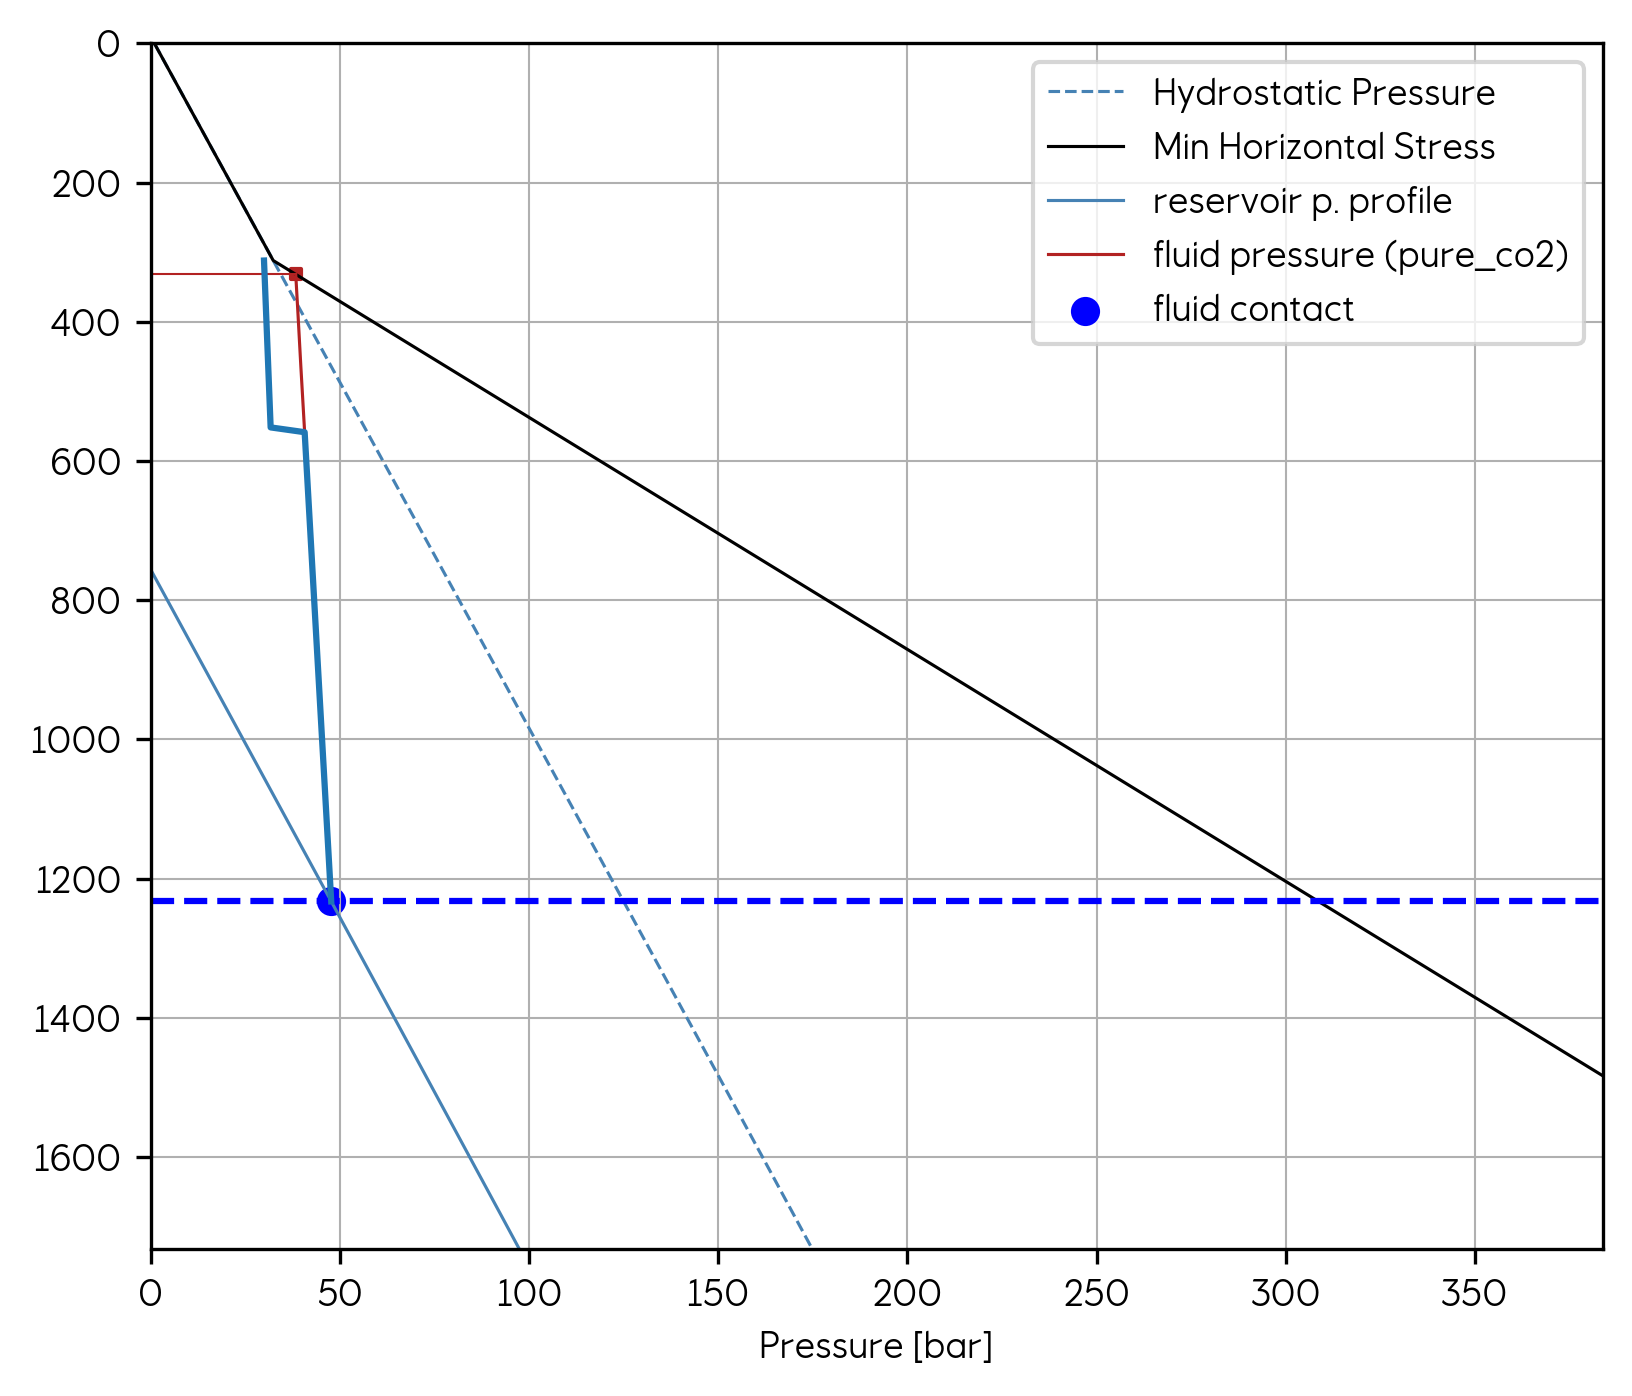

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[3]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

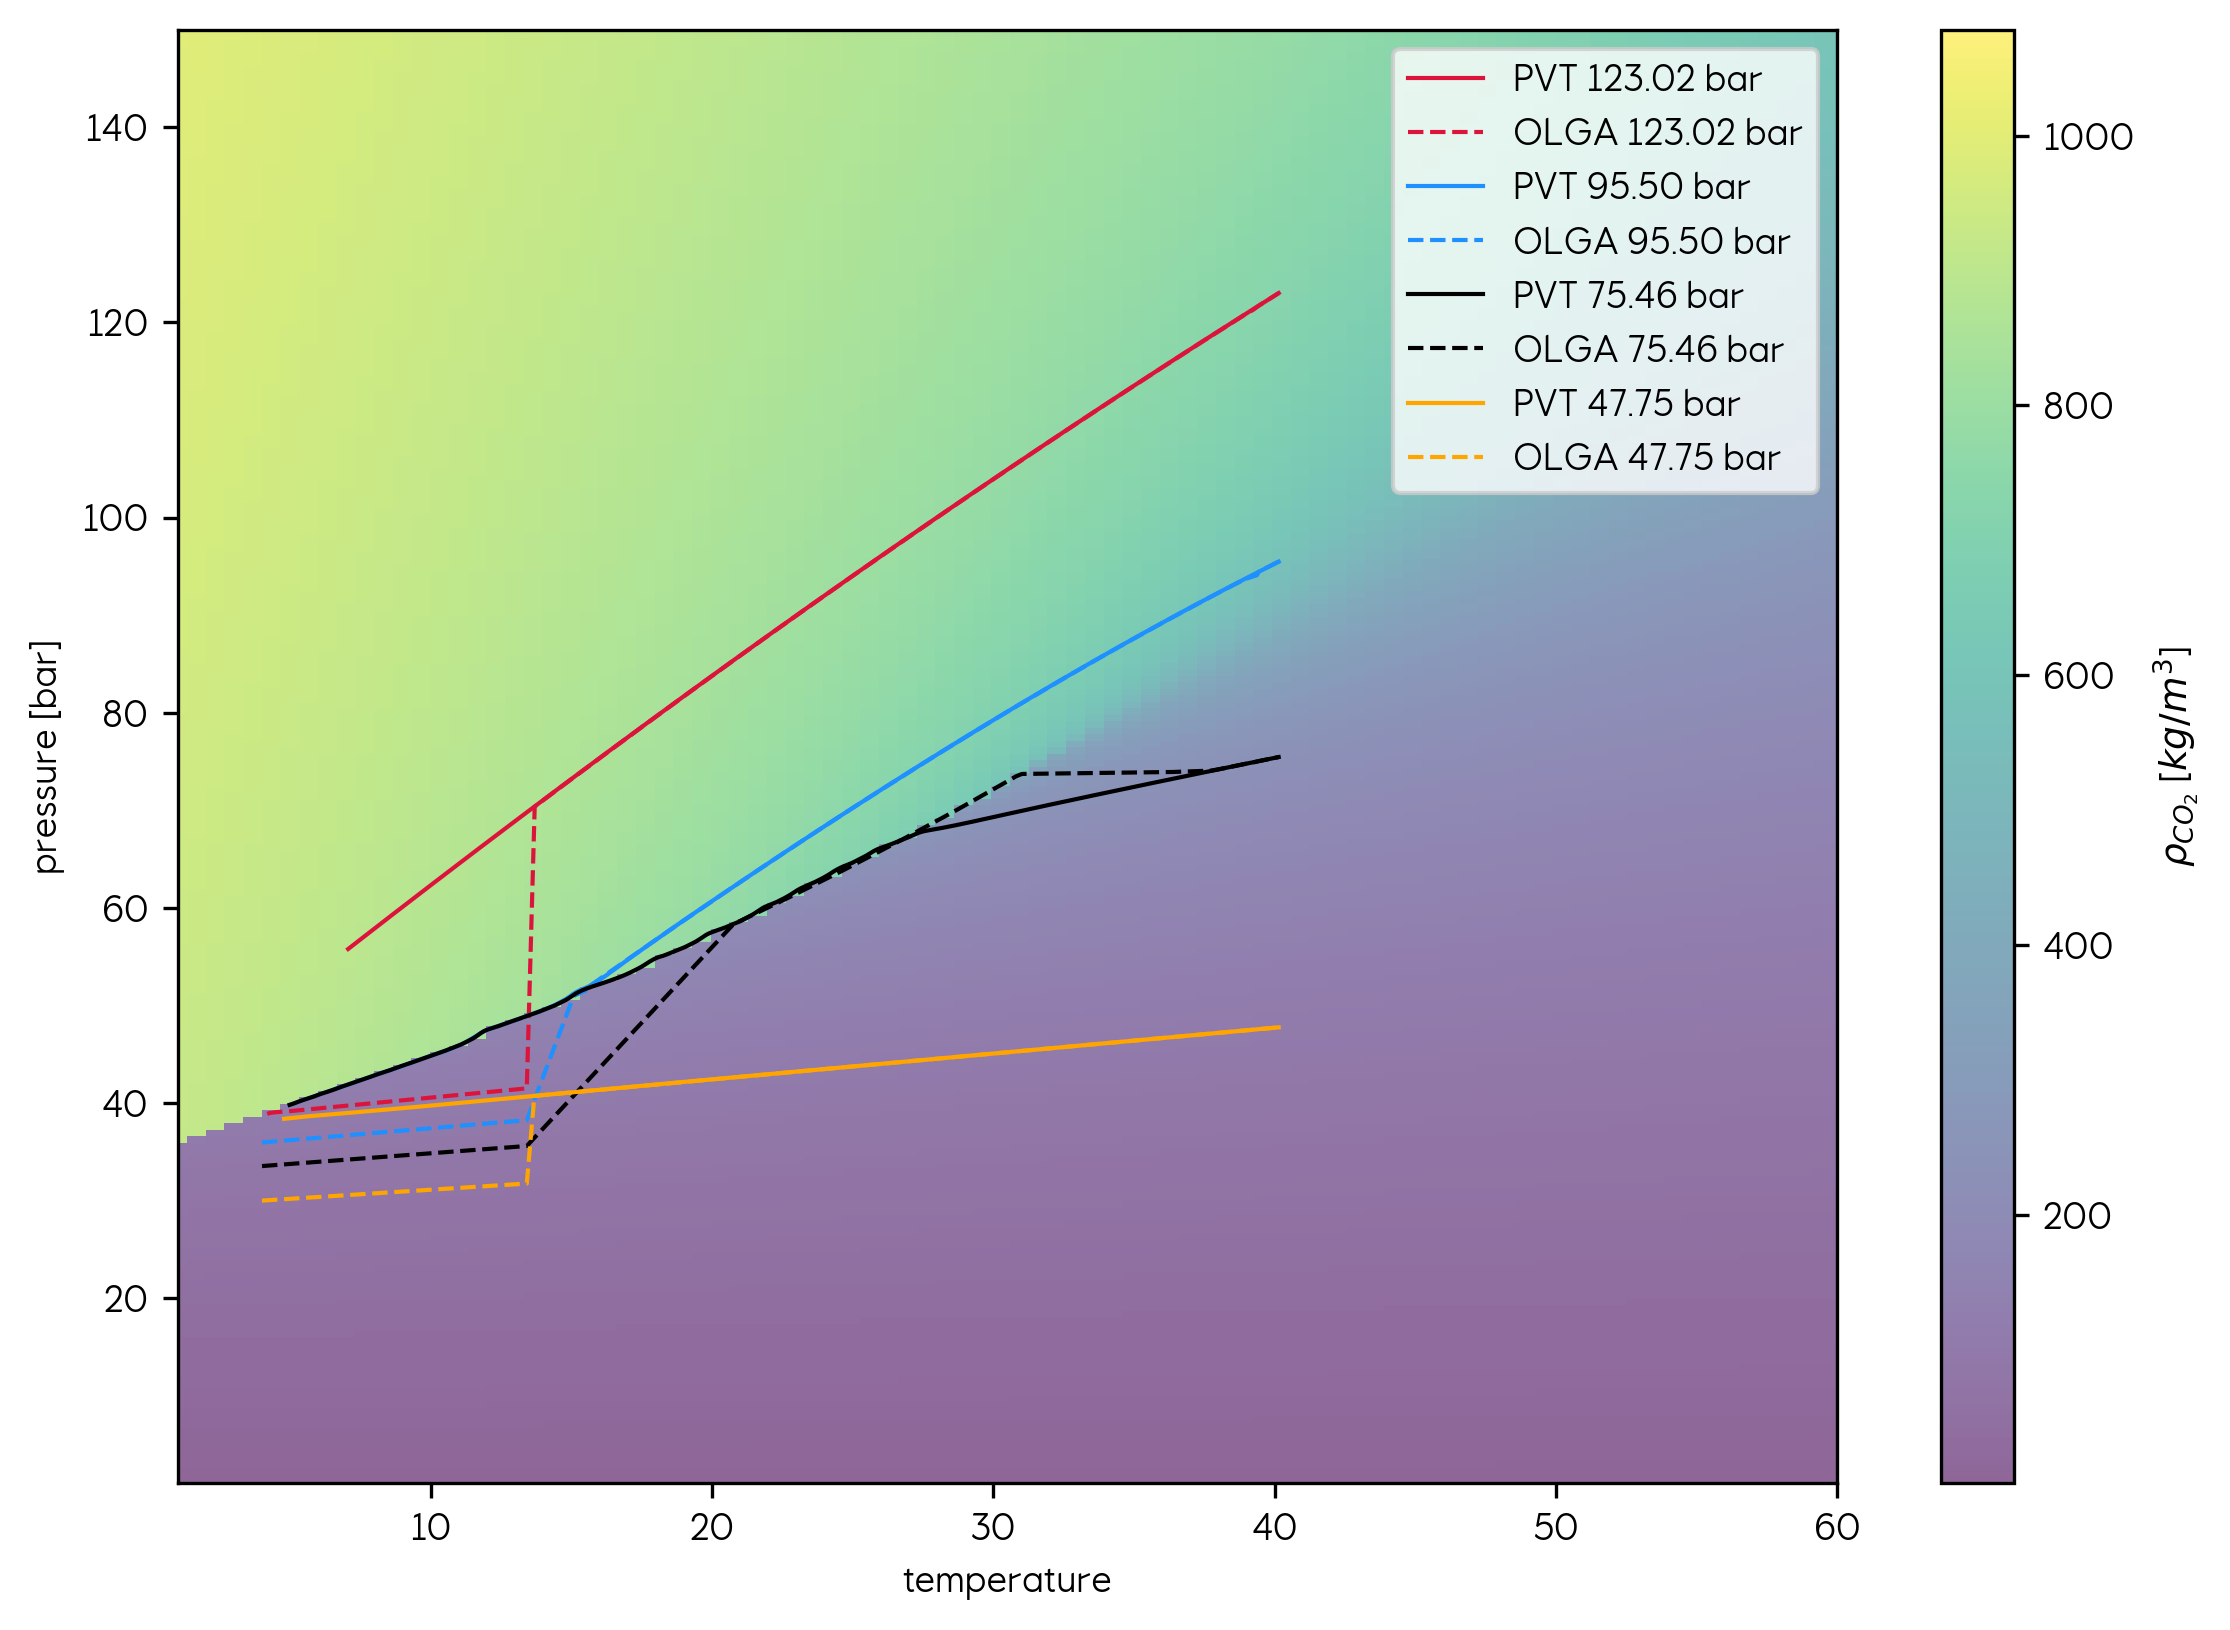

In [57]:
# Plot tables
from itertools import cycle

height = 13.98 / (const.inch * 100)
width = 19.5 / (const.inch * 100)

fig, ax = plt.subplots(1, 1, figsize=(width, height))
# Plot density colormap
rho_pcm_co2 = ax.pcolormesh(co2_pvt_data["temperature"], co2_pvt_data["pressure"], co2_pvt_data["pure_co2"]["rho"], alpha=0.6)

ax.set_xlabel("temperature [degC]")
ax.set_ylabel("pressure [bar]")

color_cycle = cycle(["#DC143C", "#1E90FF", "k", "#FFA500"])


# ax.plot(olga_pure_co2_122.iloc[:,7], olga_pure_co2_122.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_94.iloc[:,7], olga_pure_co2_94.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_75.iloc[:,7], olga_pure_co2_75.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_47.iloc[:,7], olga_pure_co2_47.iloc[:,3], color=next(color_cycle))

for scenario, color in zip(p_models, color_cycle):
    p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves.plot(
        "temperature", "fluid_pressure", ax=ax, color=color, label=f"PVT {scenario} bar", lw=1
    )

    ax.plot(olga_dict[scenario].iloc[:, 7], olga_dict[scenario].iloc[:, 3], color=color, ls="--", label=f"OLGA {scenario} bar", lw=1)

ax.set_xlim(1, 60)

ax.set_ylim(1, 150)
ax.legend()

fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")


fig.tight_layout()

# Mixture 1

In [59]:
olga_mix1_122 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=0, usecols=range(8))
olga_mix1_94 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=1, usecols=range(8))
olga_mix1_75 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=2, usecols=range(8))
olga_mix1_47 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=3, usecols=range(8))


olga_tables = [olga_mix1_122, olga_mix1_94, olga_mix1_75, olga_mix1_47]

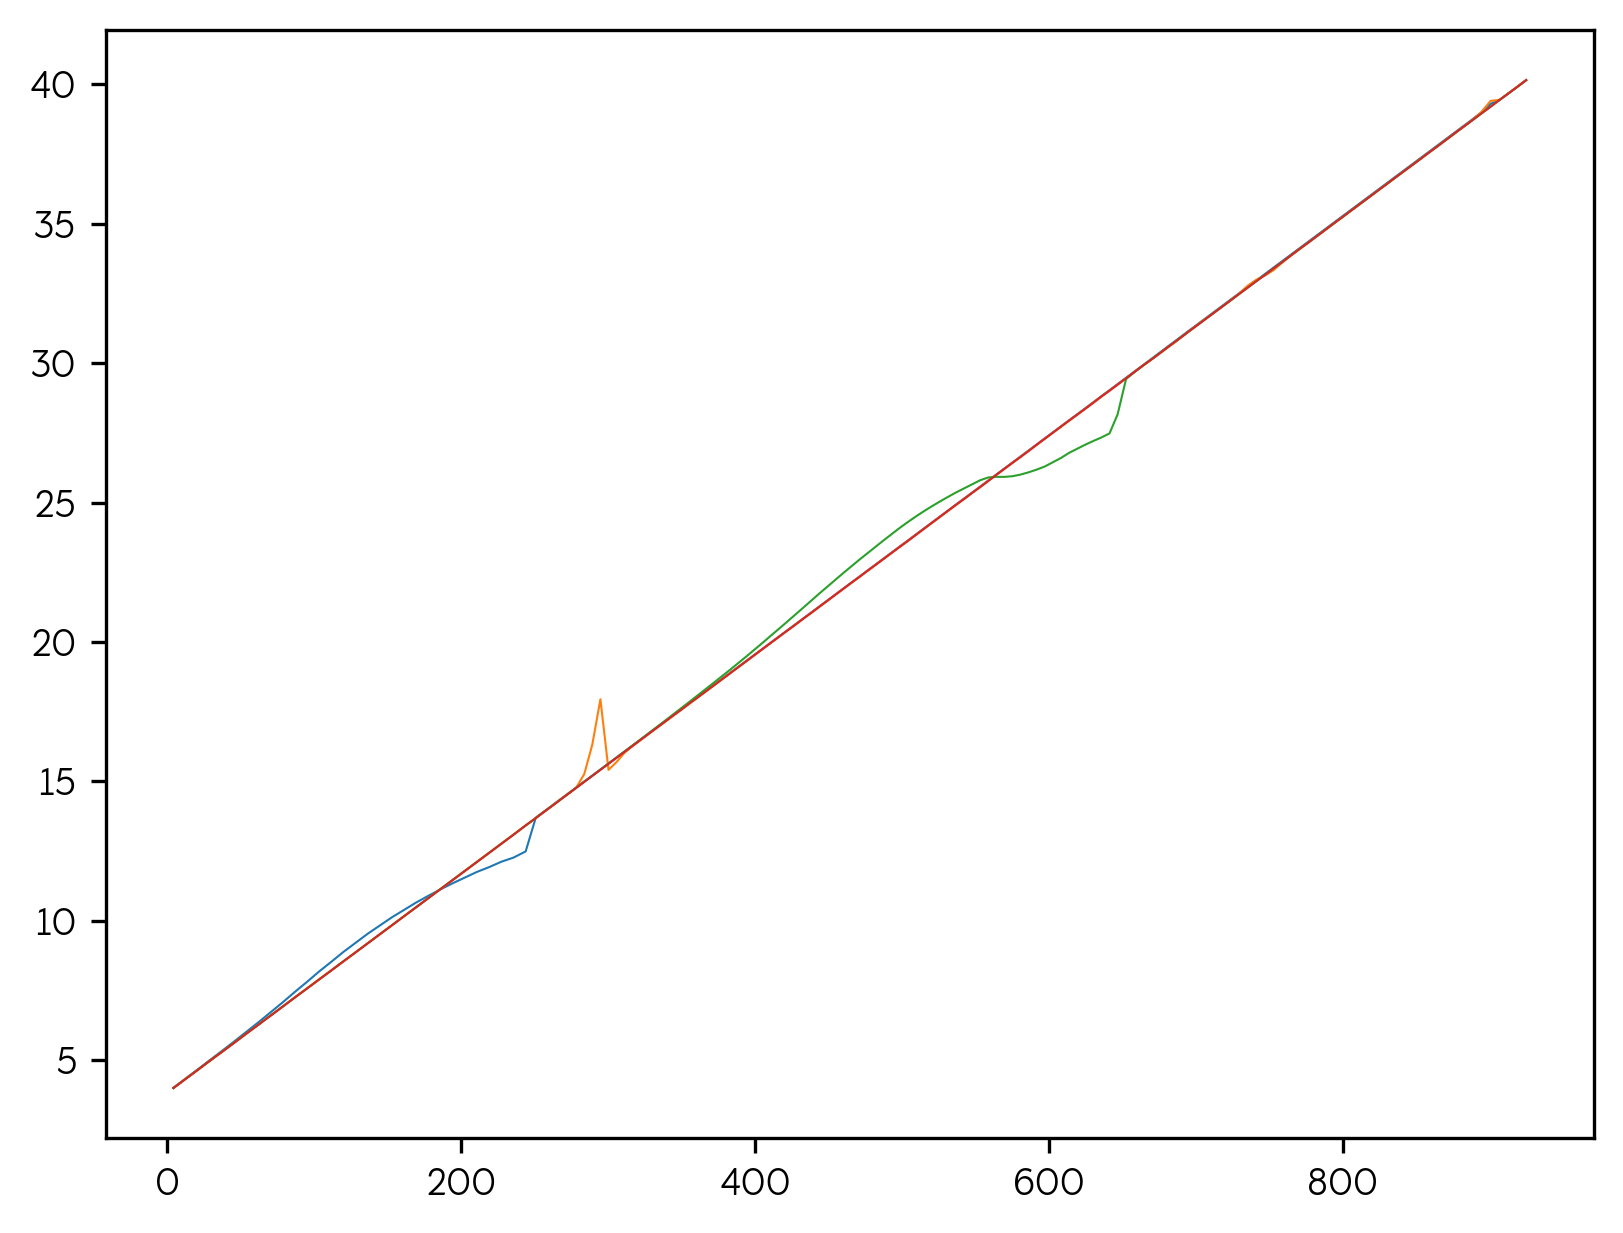

In [60]:
fig, ax = plt.subplots()

for table in olga_tables:
    ax.plot(table.iloc[:, 0], table.iloc[:, 5], lw=0.5)

# plt.plot(olga_pure_co2_122.iloc[:, 0], olga_pure_co2_122.iloc[:, 7], lw=0.5)
# plt.plot(olga_pure_co2_94.iloc[:, 0], olga_pure_co2_94.iloc[:, 7], lw=0.5)
# plt.plot(olga_pure_co2_75.iloc[:, 0], olga_pure_co2_75.iloc[:, 7], lw=0.5)
# plt.plot(olga_pure_co2_47.iloc[:, 0], olga_pure_co2_47.iloc[:, 7], lw=0.5)

In [61]:
sf_depth_msl = 312  # Water depth [meters]
sf_temp_degc = 4  # temperature at sea floor [degC]
field_fluid_type = "mixture1"

p_models = {}
olga_dict = {}

delta_z_cases = dict()

for olga_case in olga_tables:
    geo_tgrad = 1e3 * ((olga_case.iloc[-1, 5] - 4.000000) / (924.812500 - 4.133333))

    z_eq = ((olga_case.iloc[-1, 5] - sf_temp_degc) / (geo_tgrad / 1e3)) + sf_depth_msl

    delta_z = z_eq - olga_case.iloc[-1, 0]

    CO2_contact = z_eq  # CO2 water contact mTVDMSL
    press = olga_case.iloc[-1, 3]
    press_label = f"{press:.2f}"
    print(f"{press_label=}")
    delta_z_cases[press_label] = delta_z

    print(f"{geo_tgrad=} {sf_temp_degc:.2f} {CO2_contact=} {field_fluid_type=} {press=}")

    olga_dict[press_label] = olga_case
    # '''Constants'''

    # geo_tgrad = 40 #geothermal gradient [degc/km]
    p_models[press_label] = Pressure(
        # wellbore seafloor depth mTVD MSL.
        sf_depth_msl=sf_depth_msl,  # wellbore.water_depth,
        # wellbore total depth in mTVD RKB
        well_td_rkb=5e3,  # total_depth_rkb,
        # wellbore rkb in mTVD RKB
        well_rkb=0,
        # seafloor temperature in degC
        sf_temp=sf_temp_degc,  # DEFAULT_SEAFLOOR_TEMPERATURE,
        # geothermal gradient in degC/km
        geo_tgrad=geo_tgrad,  # DEFAULT_GEOTHERMAL_GRADIENT,
        fluid_type=field_fluid_type,  # type: ignore
        # path to the pvt constants folder
        pvt_path=pvt_path,
        z_fluid_contact=CO2_contact,  # wellbore_settings.pressure_datum_tvd_msl,  # type: ignore
        p_fluid_contact=press,  # wellbore_settings.reservoir_pressure_bar,  # type: ignore
        # specific_gravity=None,  # type: ignore
        # ip_shmin_data=shmin_data,
        shmin_gradient=0.3,
    )

press_label='122.69'
geo_tgrad=np.float64(39.264916510270076) 4.00 CO2_contact=np.float64(1232.679167) field_fluid_type='mixture1' press=np.float64(122.685600280762)
Computing pressure profile for scenario: hydrostatic
press_label='95.01'
geo_tgrad=np.float64(39.26904328821051) 4.00 CO2_contact=np.float64(1232.679167) field_fluid_type='mixture1' press=np.float64(95.0052337646484)


Computing pressure profile for scenario: hydrostatic
press_label='75.41'
geo_tgrad=np.float64(39.26653241729494) 4.00 CO2_contact=np.float64(1232.6791669999998) field_fluid_type='mixture1' press=np.float64(75.4081497192383)
Computing pressure profile for scenario: hydrostatic
press_label='47.75'
geo_tgrad=np.float64(39.2701744231279) 4.00 CO2_contact=np.float64(1232.679167) field_fluid_type='mixture1' press=np.float64(47.7455406188965)
Computing pressure profile for scenario: hydrostatic


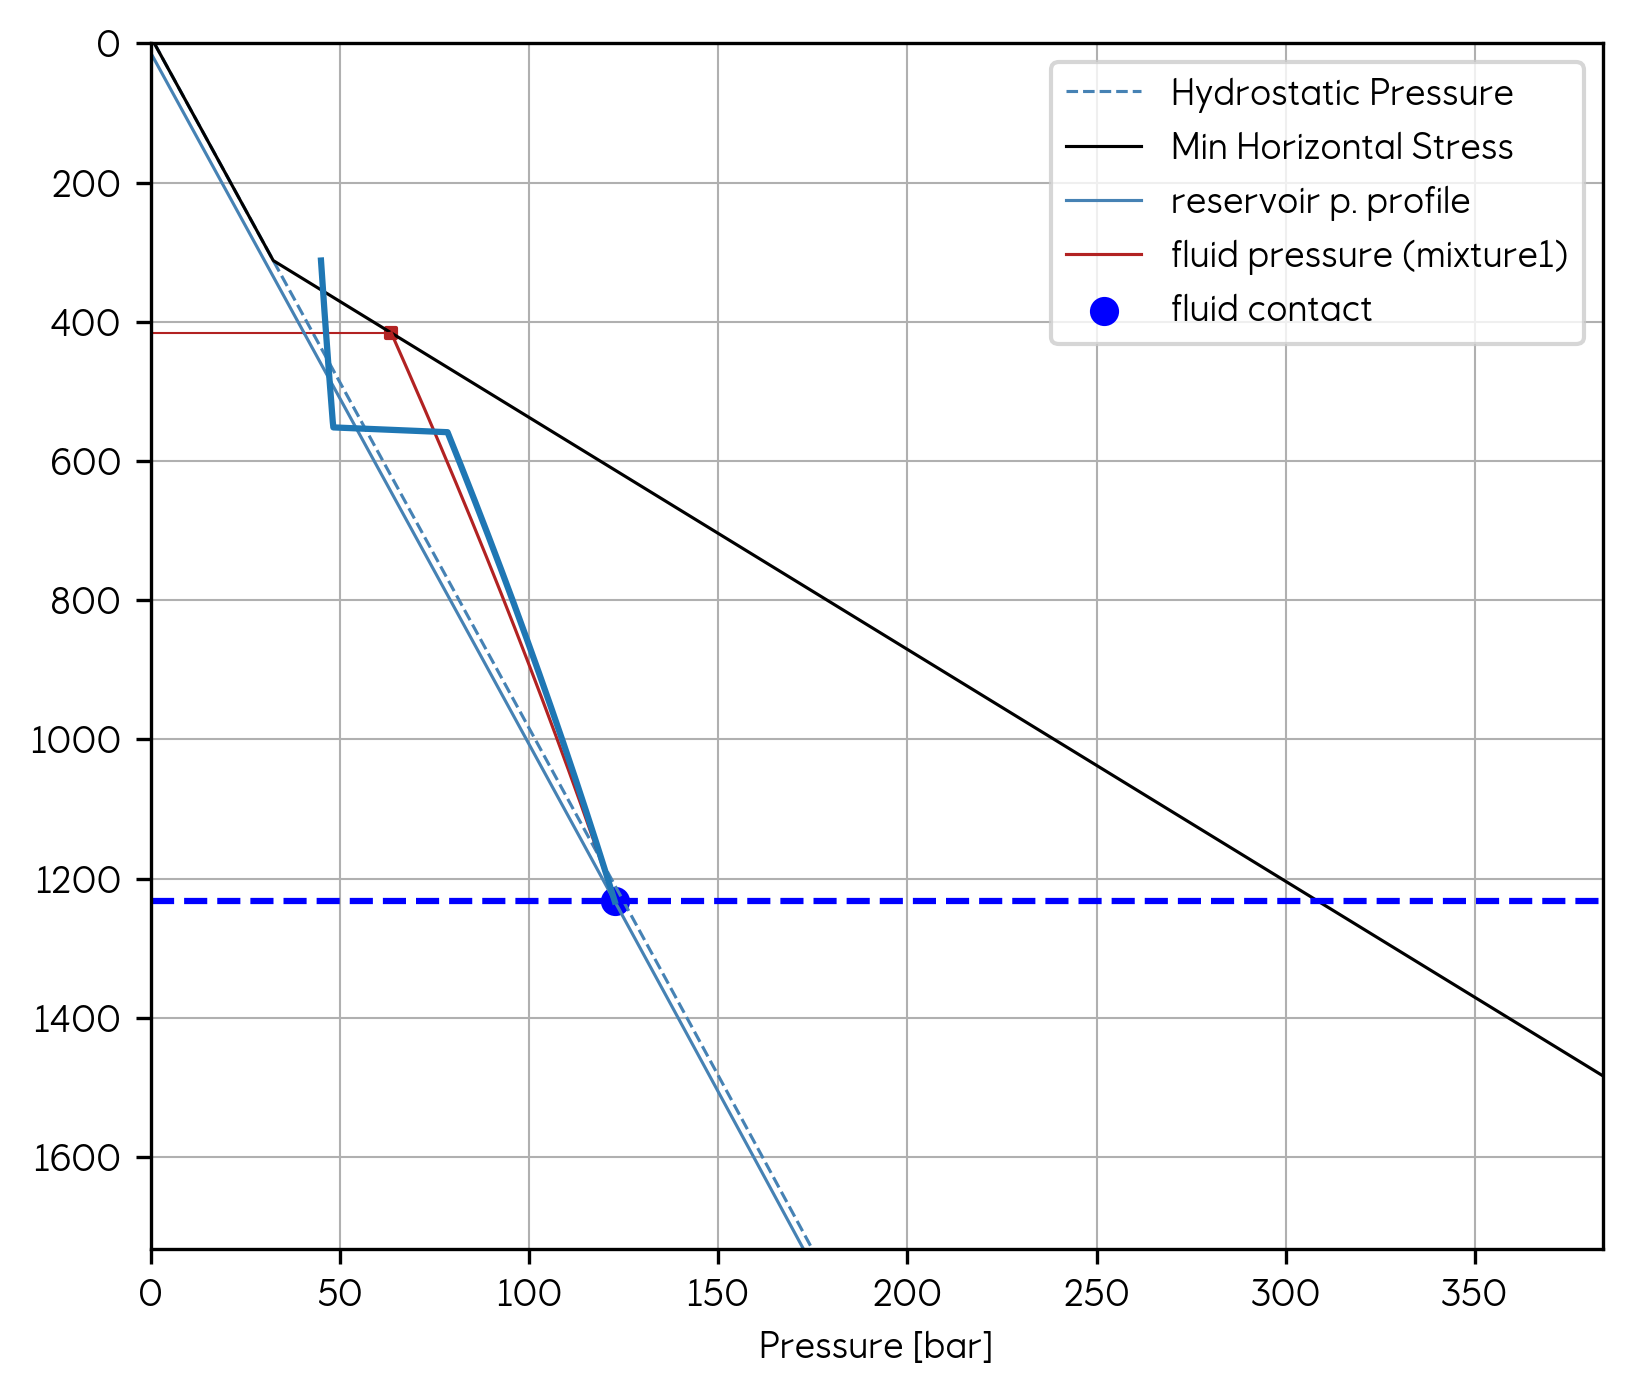

In [62]:
rcParams["figure.dpi"] = 300

width_cm = 14  # cm
height_cm = 12  # cm

width = width_cm / 2.54
height = height_cm / 2.54

fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(olga_dict.keys())[0]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

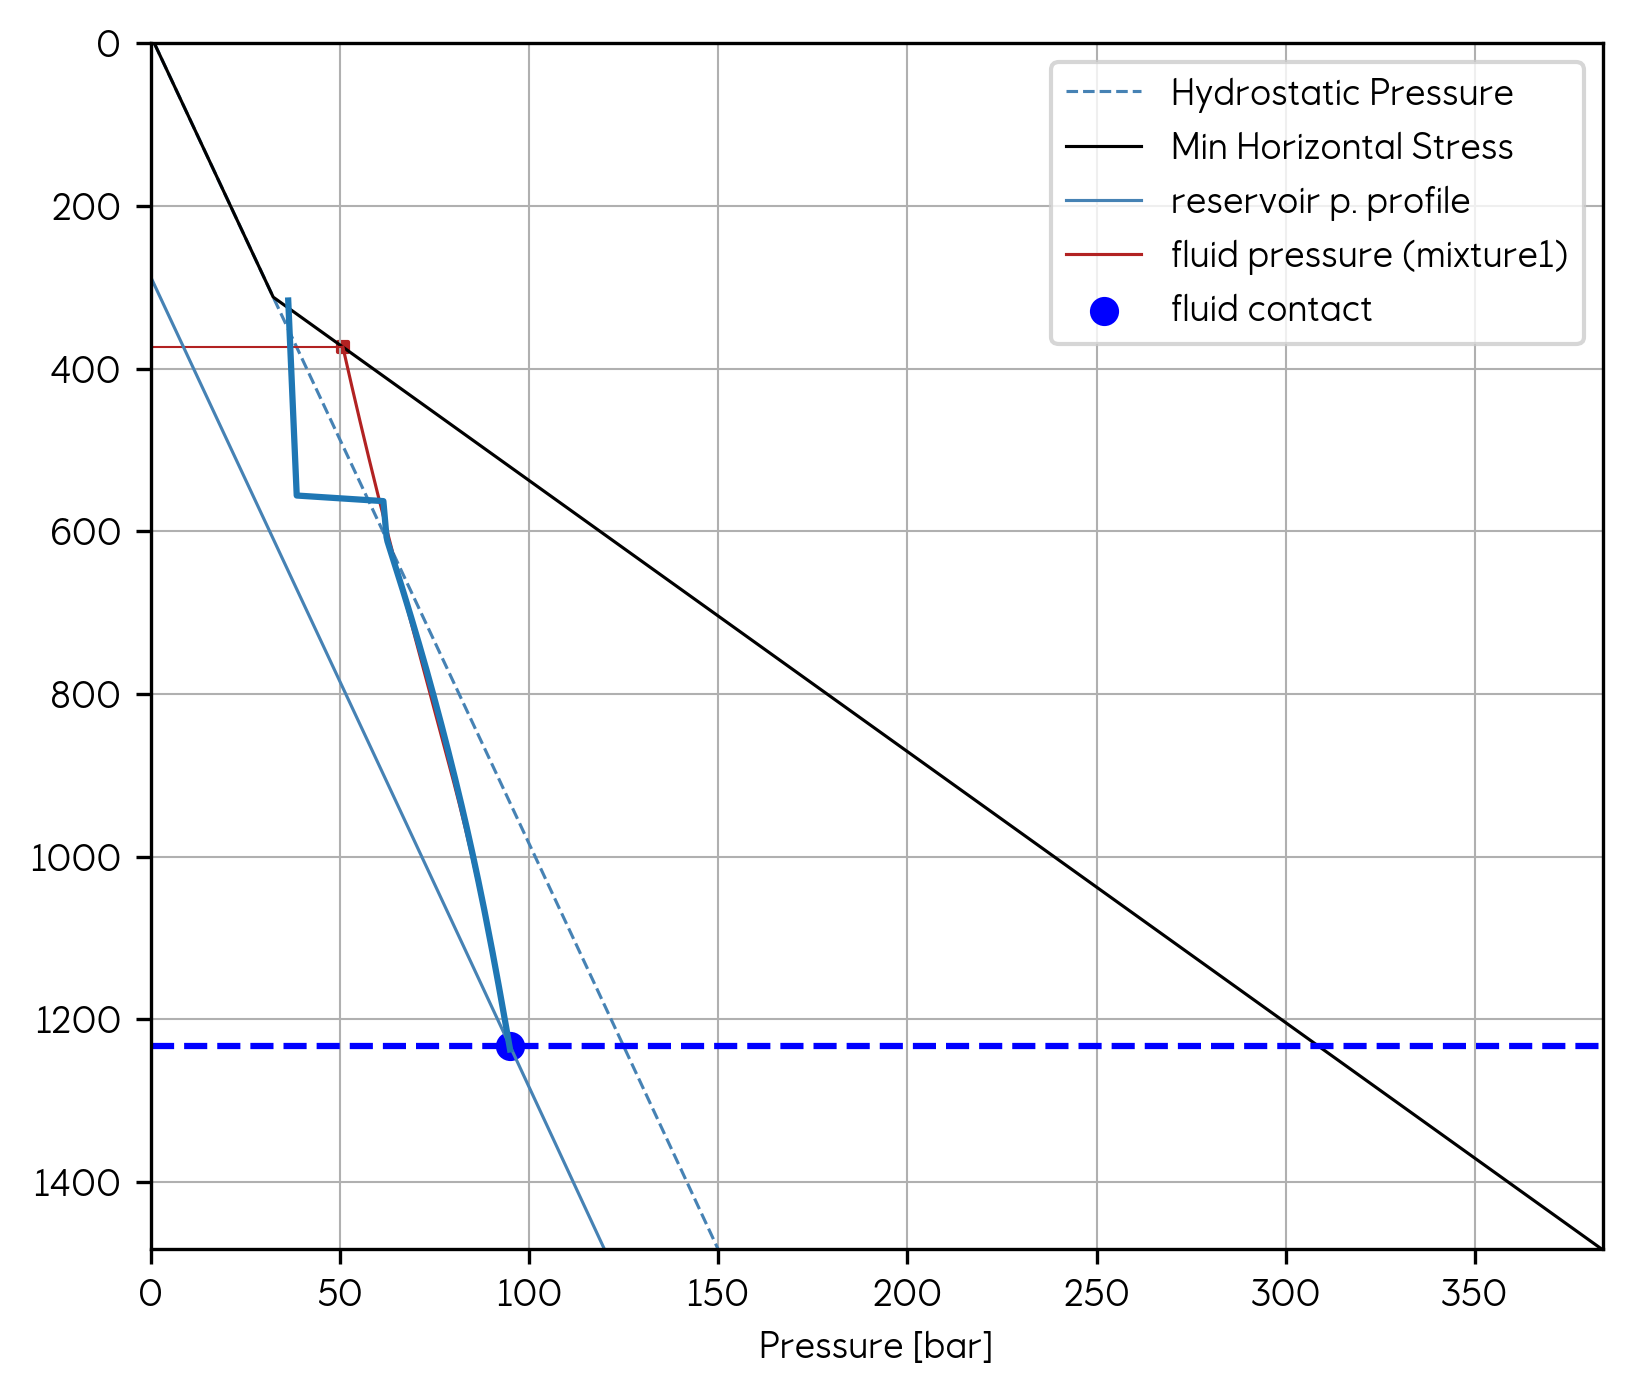

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[1]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 250)
fig.tight_layout()

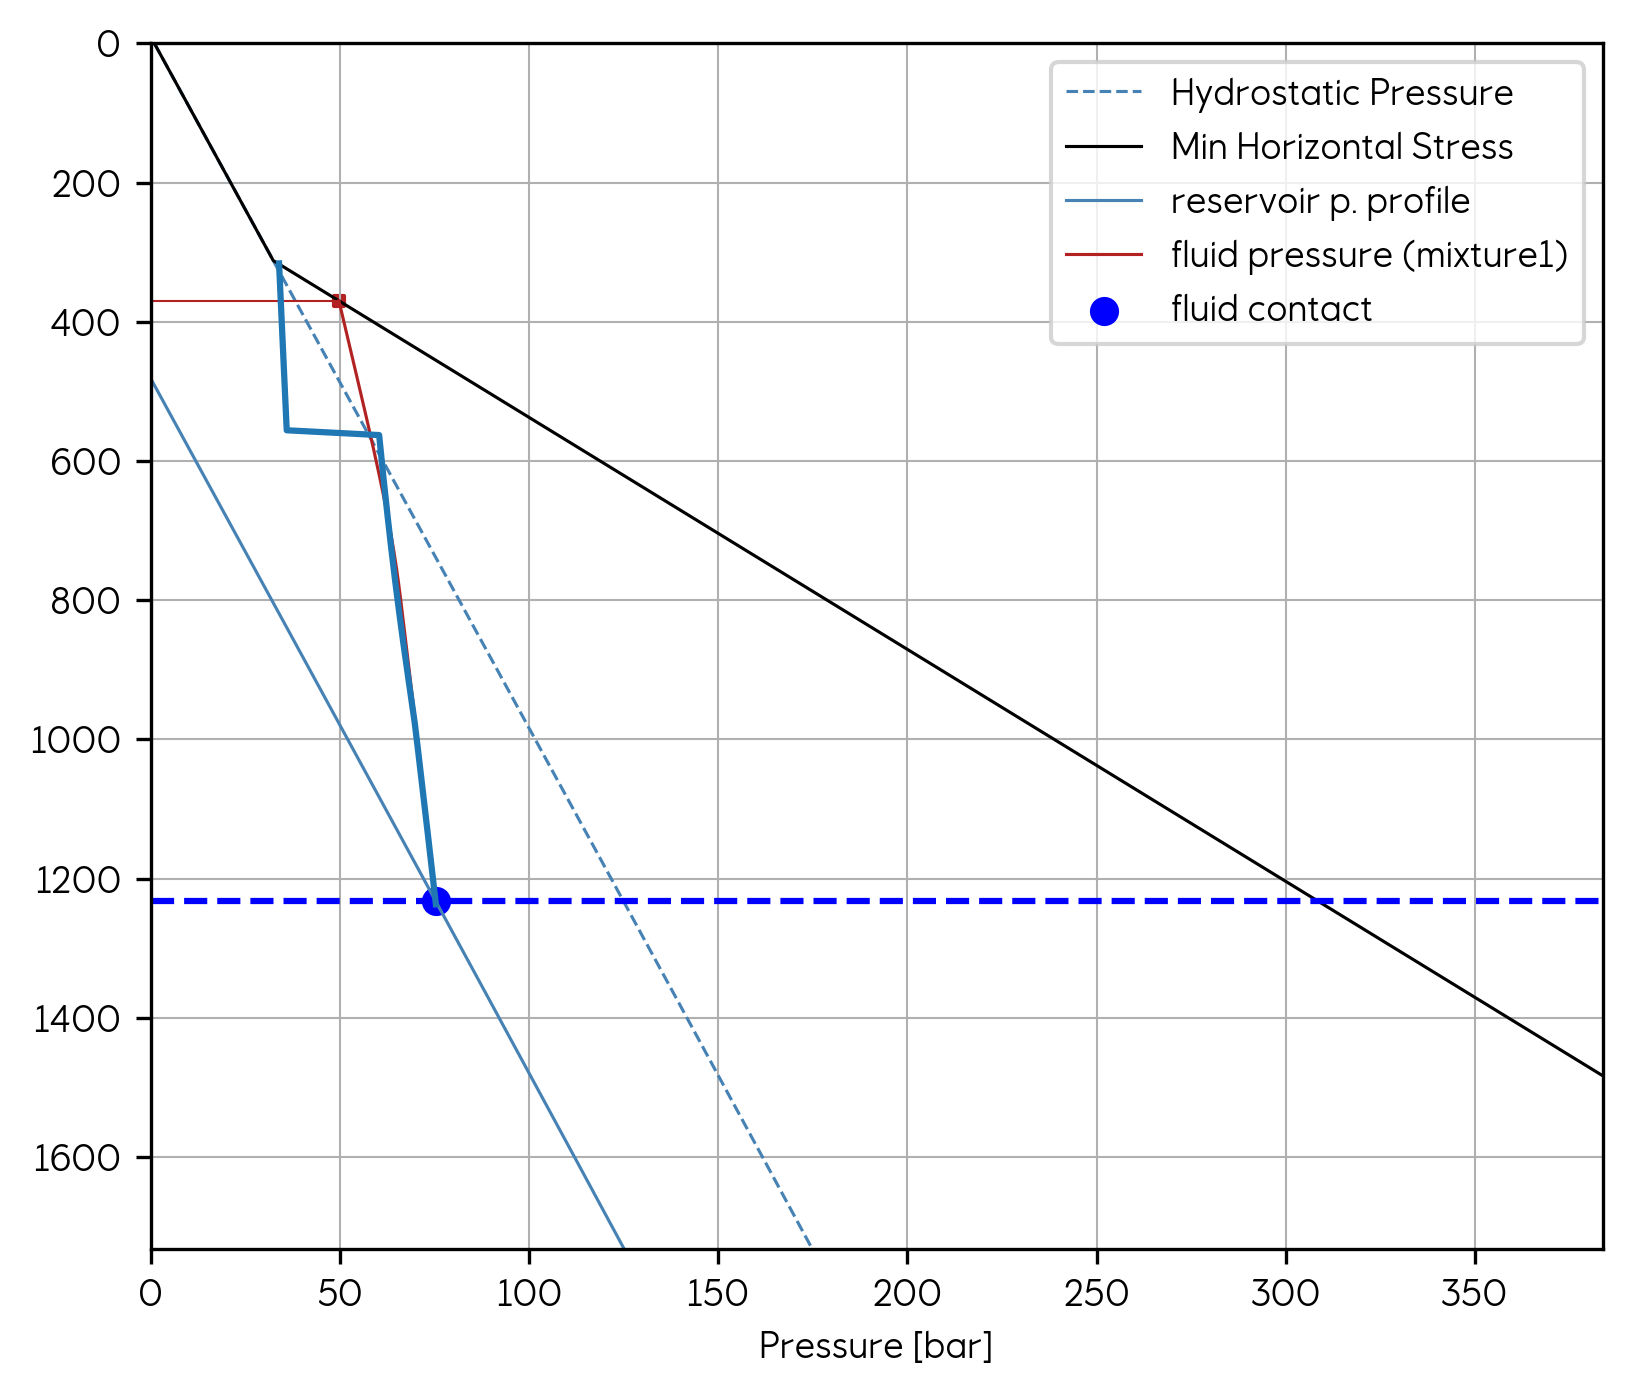

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[2]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

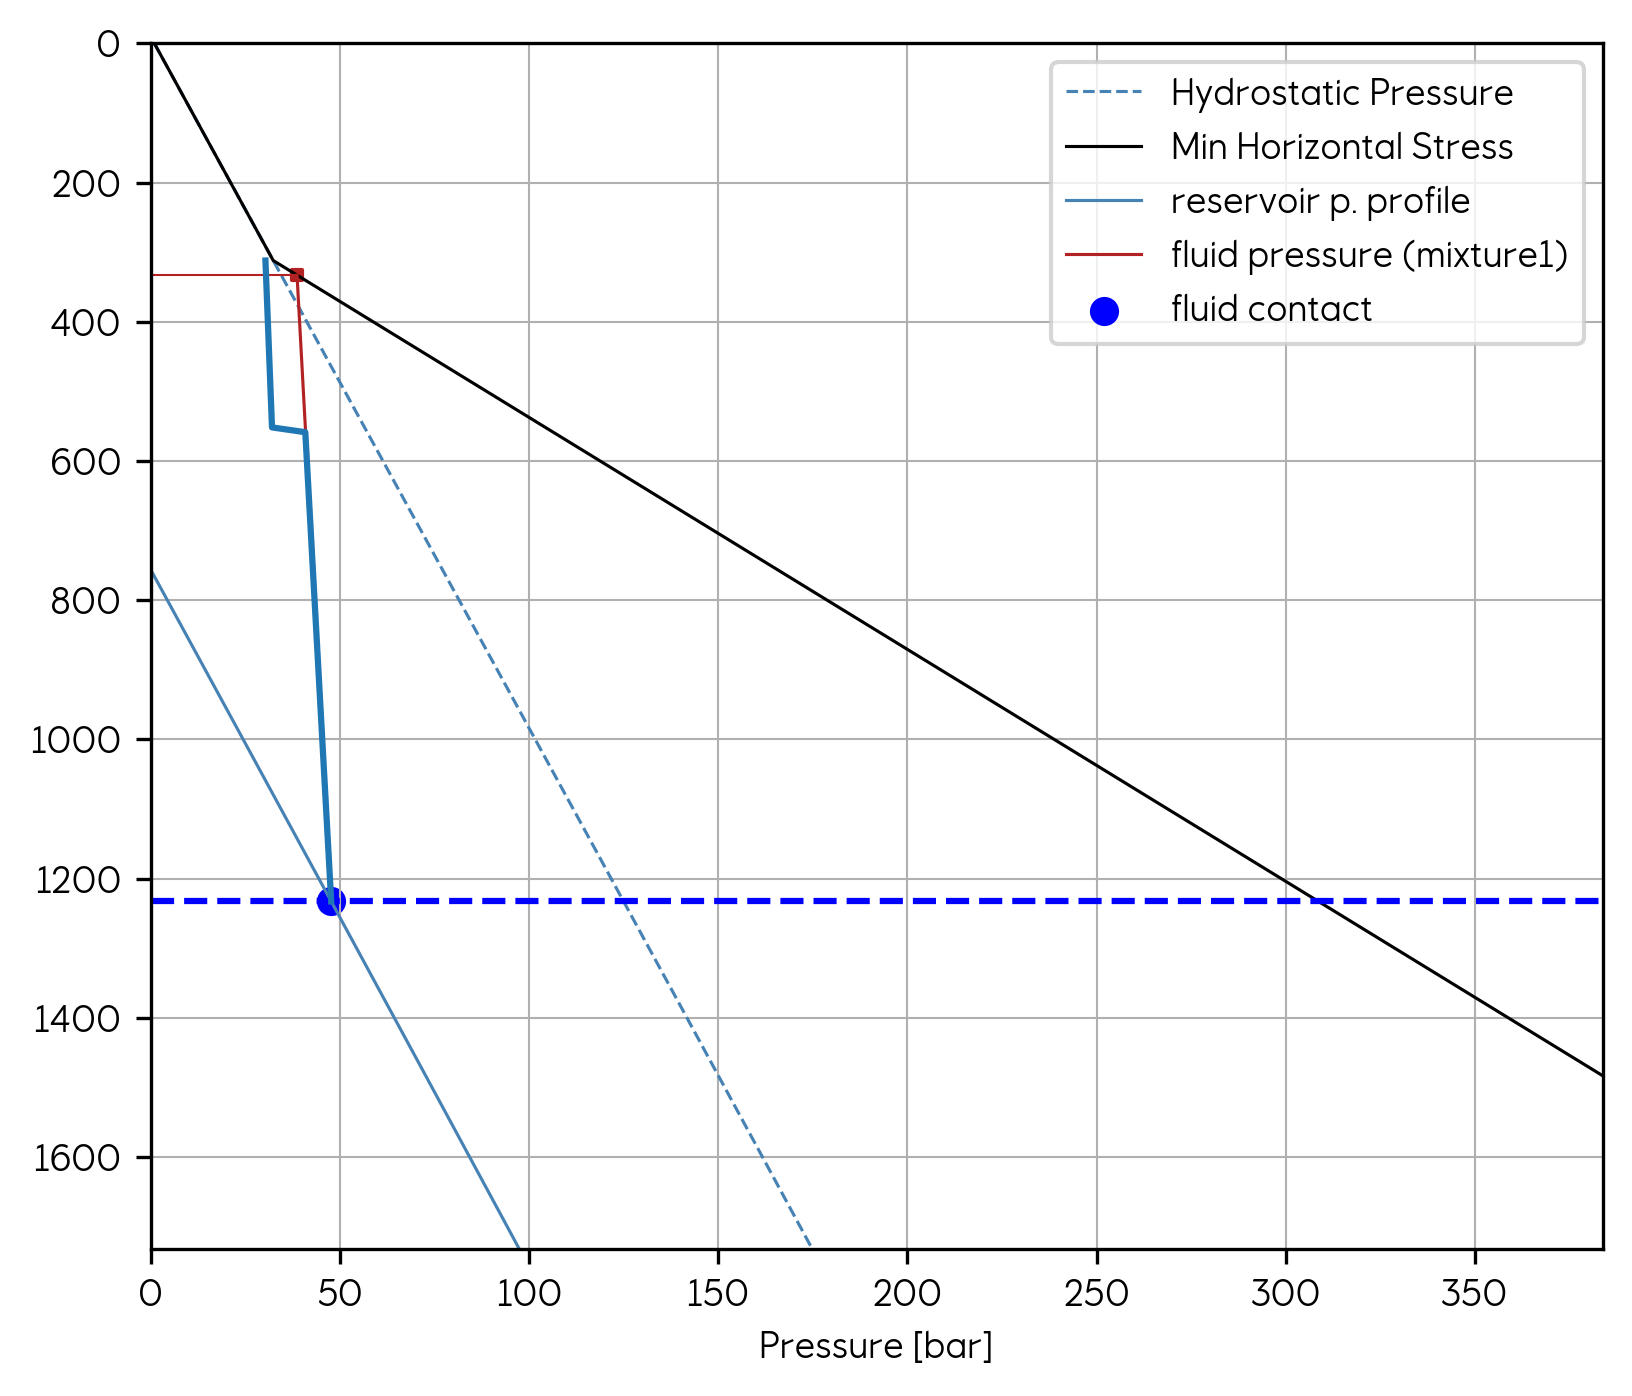

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[3]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

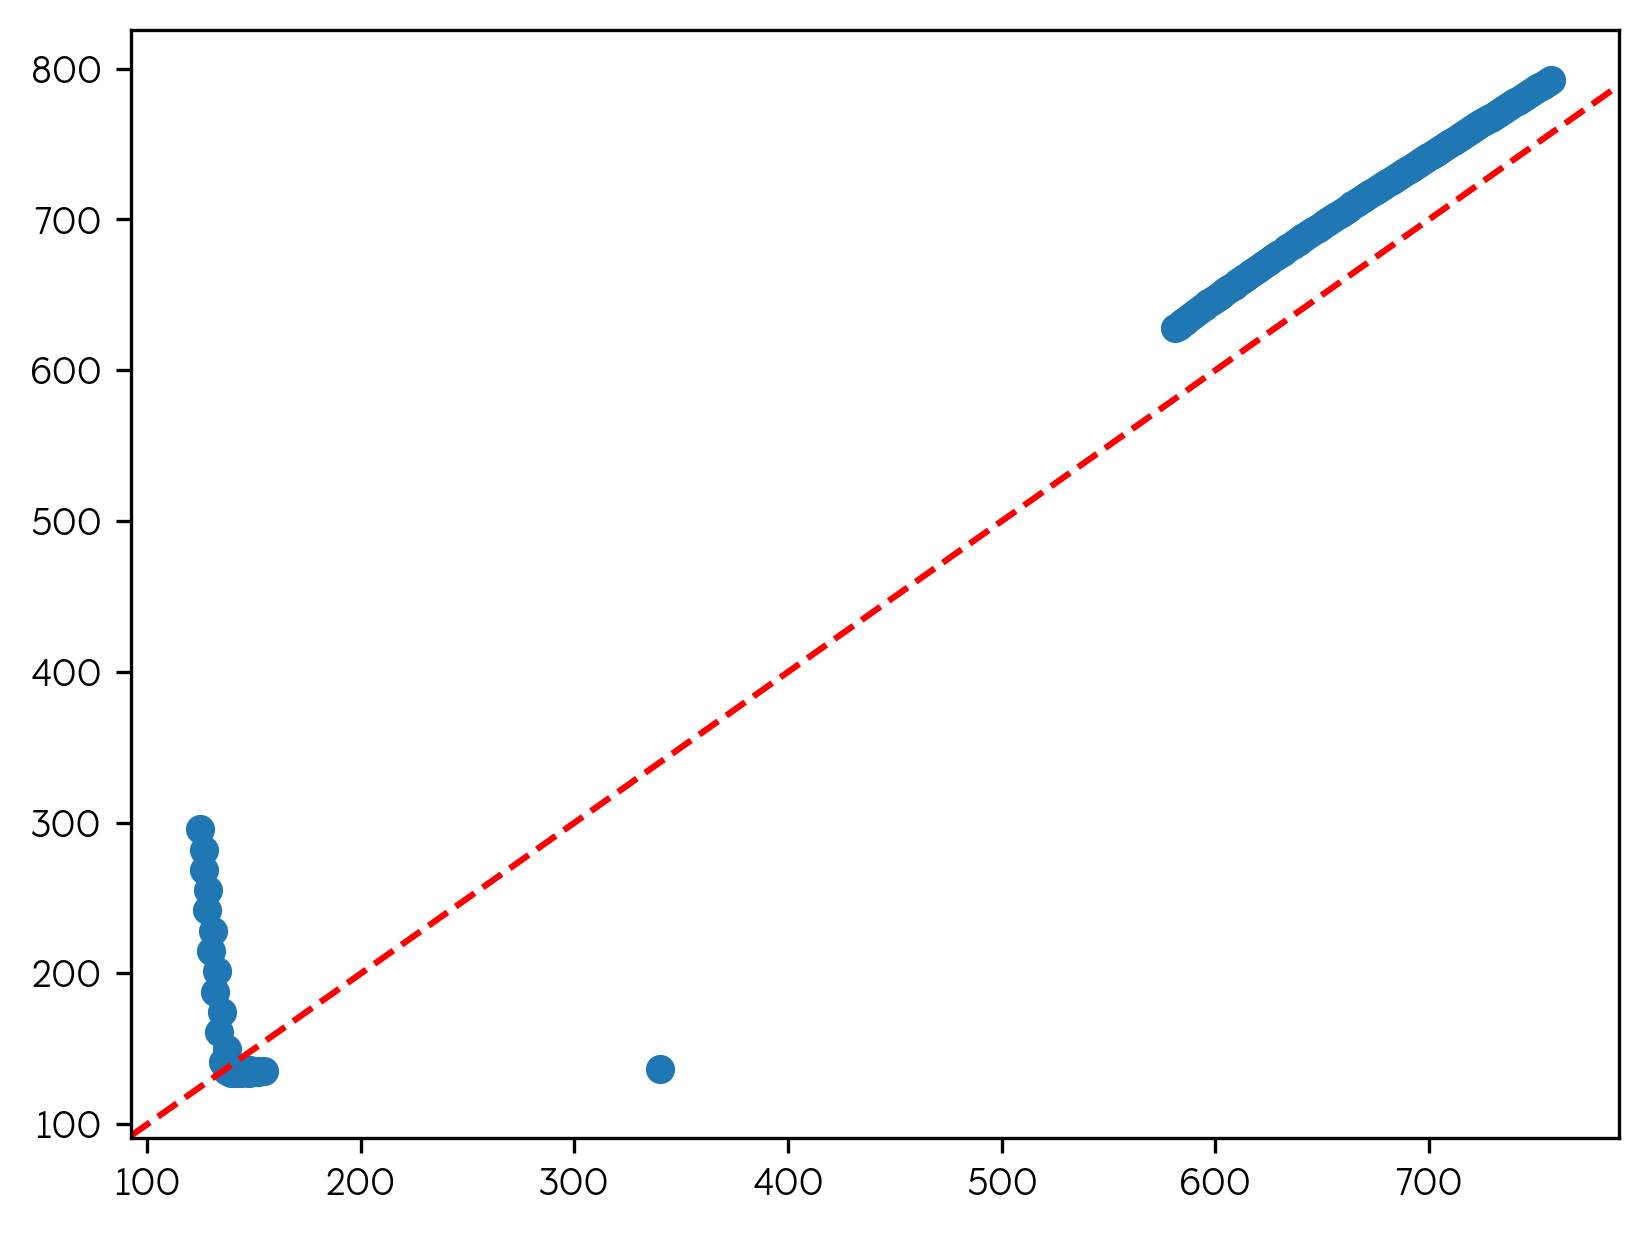

In [69]:
scenario = list(p_models.keys())[0]

olga_T = olga_dict[scenario].iloc[:, 5].values
olga_P = olga_dict[scenario].iloc[:, 3].values
olga_rho_interp = interpolator((olga_P, olga_T))

olga_dict[scenario]["interpolated_rho"] = olga_rho_interp

olga_rho = olga_dict[scenario].iloc[:, 7].values

# olga_dict[scenario]

fig, ax = plt.subplots()

ax.scatter(olga_rho, olga_rho_interp)

lowest_value = int(min(min(olga_rho), min(olga_rho_interp)))
ax.axline((lowest_value, lowest_value), slope=1, color="r", linestyle="--")

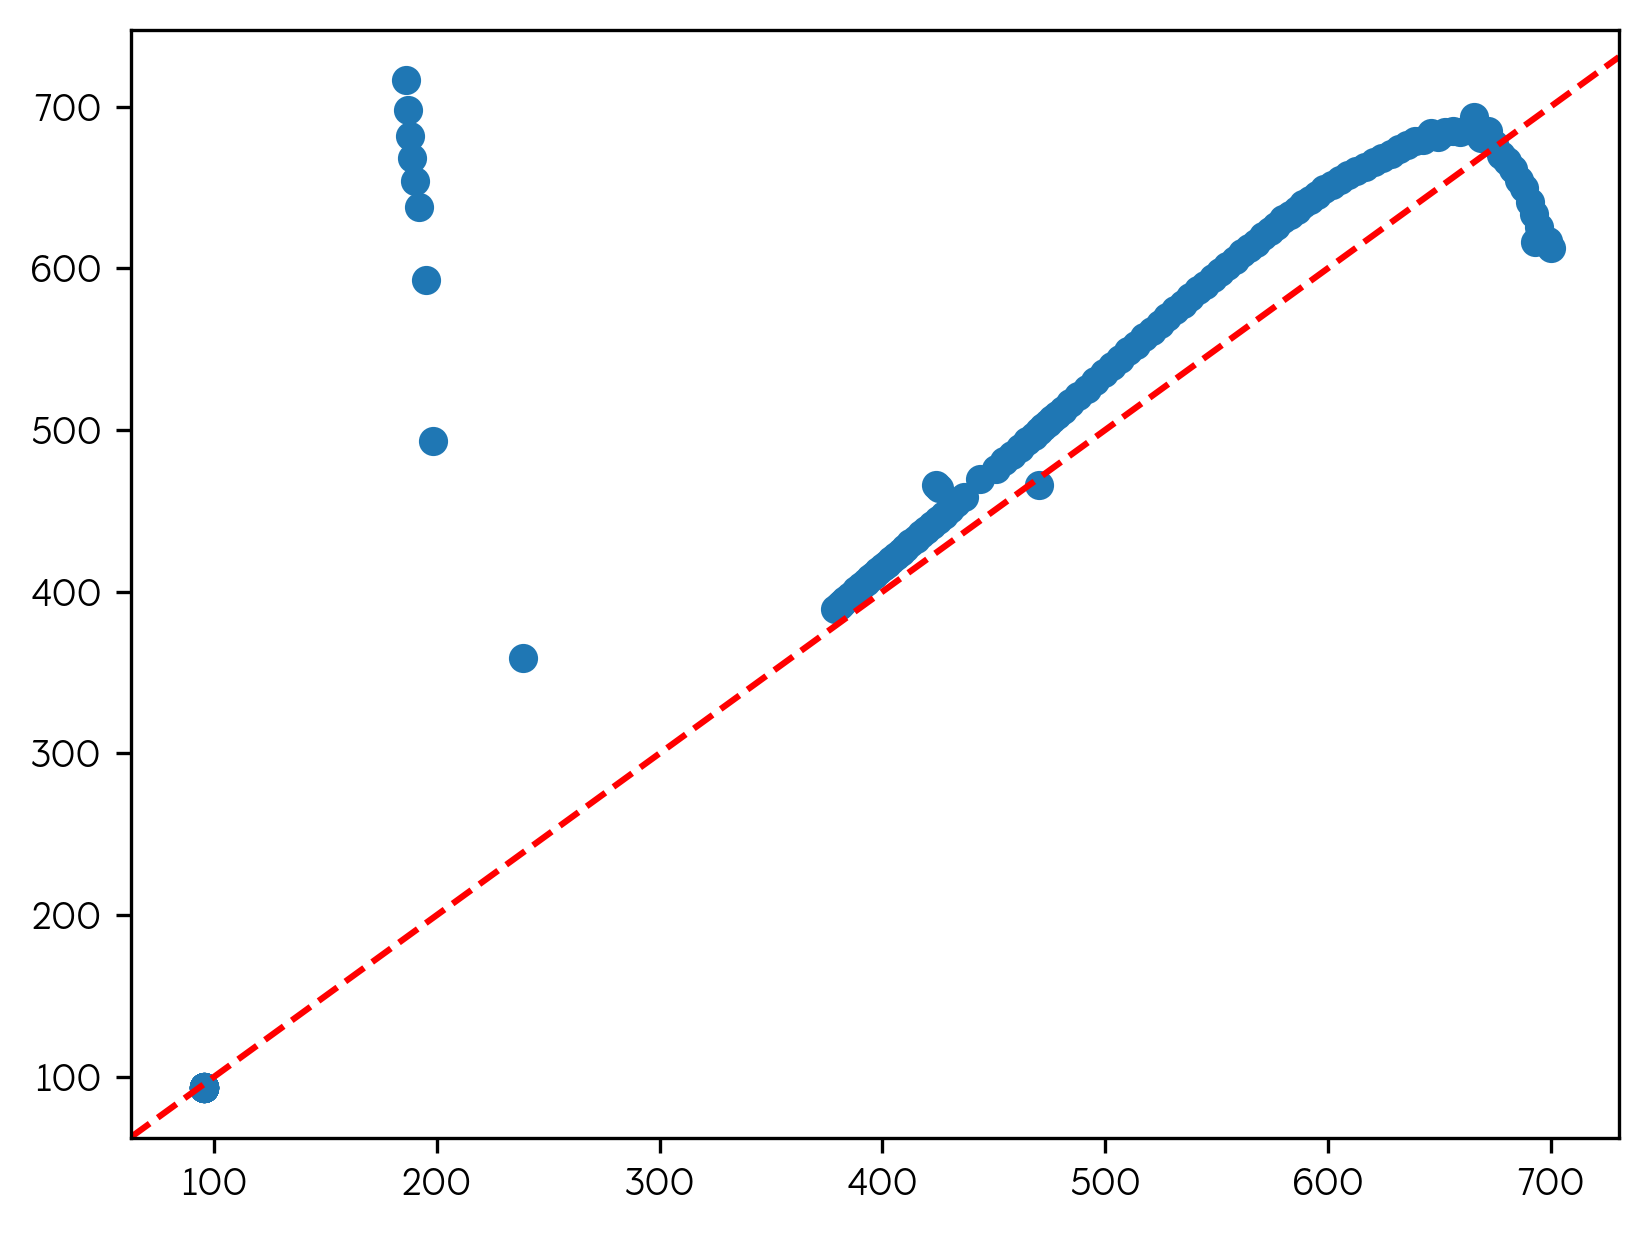

In [70]:
scenario = list(p_models.keys())[1]

olga_T = olga_dict[scenario].iloc[:, 5].values
olga_P = olga_dict[scenario].iloc[:, 3].values
olga_rho_interp = interpolator((olga_P, olga_T))

olga_dict[scenario]["interpolated_rho"] = olga_rho_interp

olga_rho = olga_dict[scenario].iloc[:, 7].values

# olga_dict[scenario]

fig, ax = plt.subplots()

ax.scatter(olga_rho, olga_rho_interp)

lowest_value = int(min(min(olga_rho), min(olga_rho_interp)))
ax.axline((lowest_value, lowest_value), slope=1, color="r", linestyle="--")

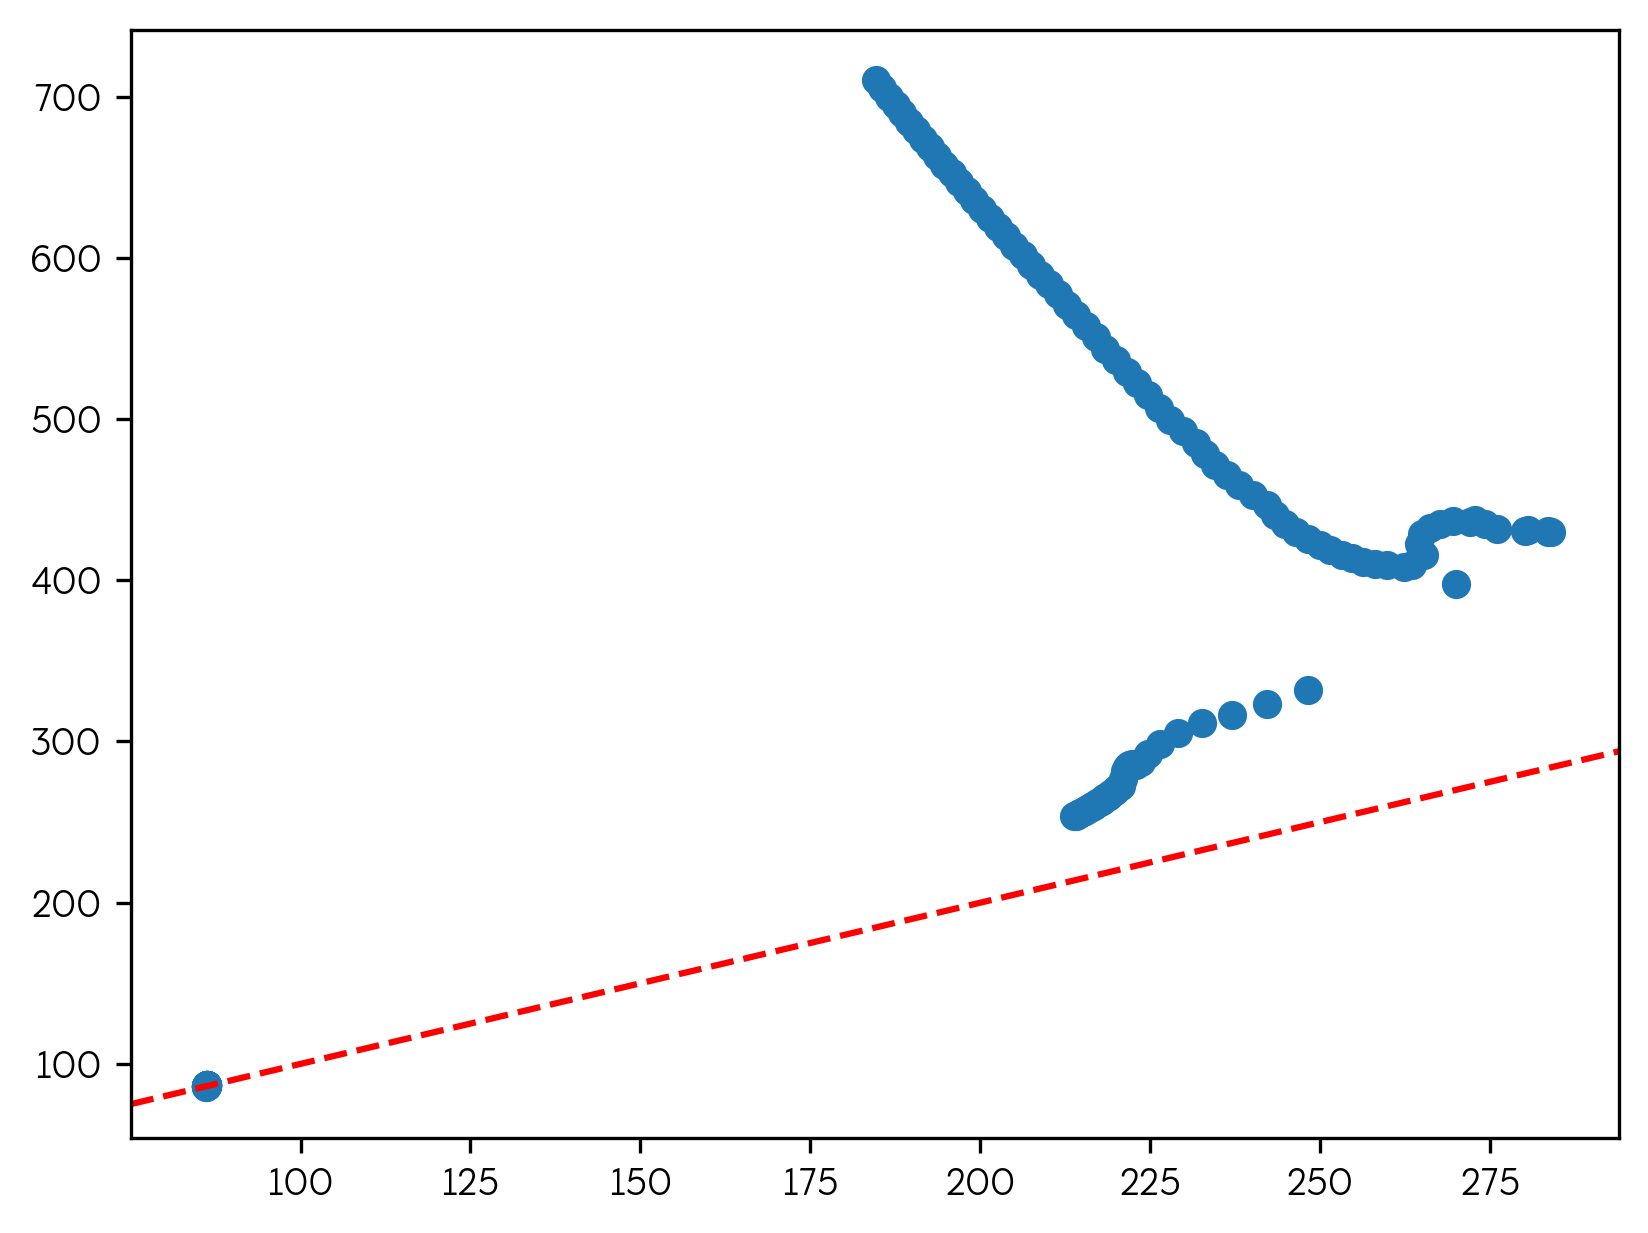

In [ ]:
scenario = list(p_models.keys())[2]

olga_T = olga_dict[scenario].iloc[:, 5].values
olga_P = olga_dict[scenario].iloc[:, 3].values
olga_rho_interp = interpolator((olga_P, olga_T))

olga_dict[scenario]["interpolated_rho"] = olga_rho_interp

olga_rho = olga_dict[scenario].iloc[:, 7].values

# olga_dict[scenario]

fig, ax = plt.subplots()

ax.scatter(olga_rho, olga_rho_interp)

lowest_value = int(min(min(olga_rho), min(olga_rho_interp)))
ax.axline((lowest_value, lowest_value), slope=1, color="r", linestyle="--")

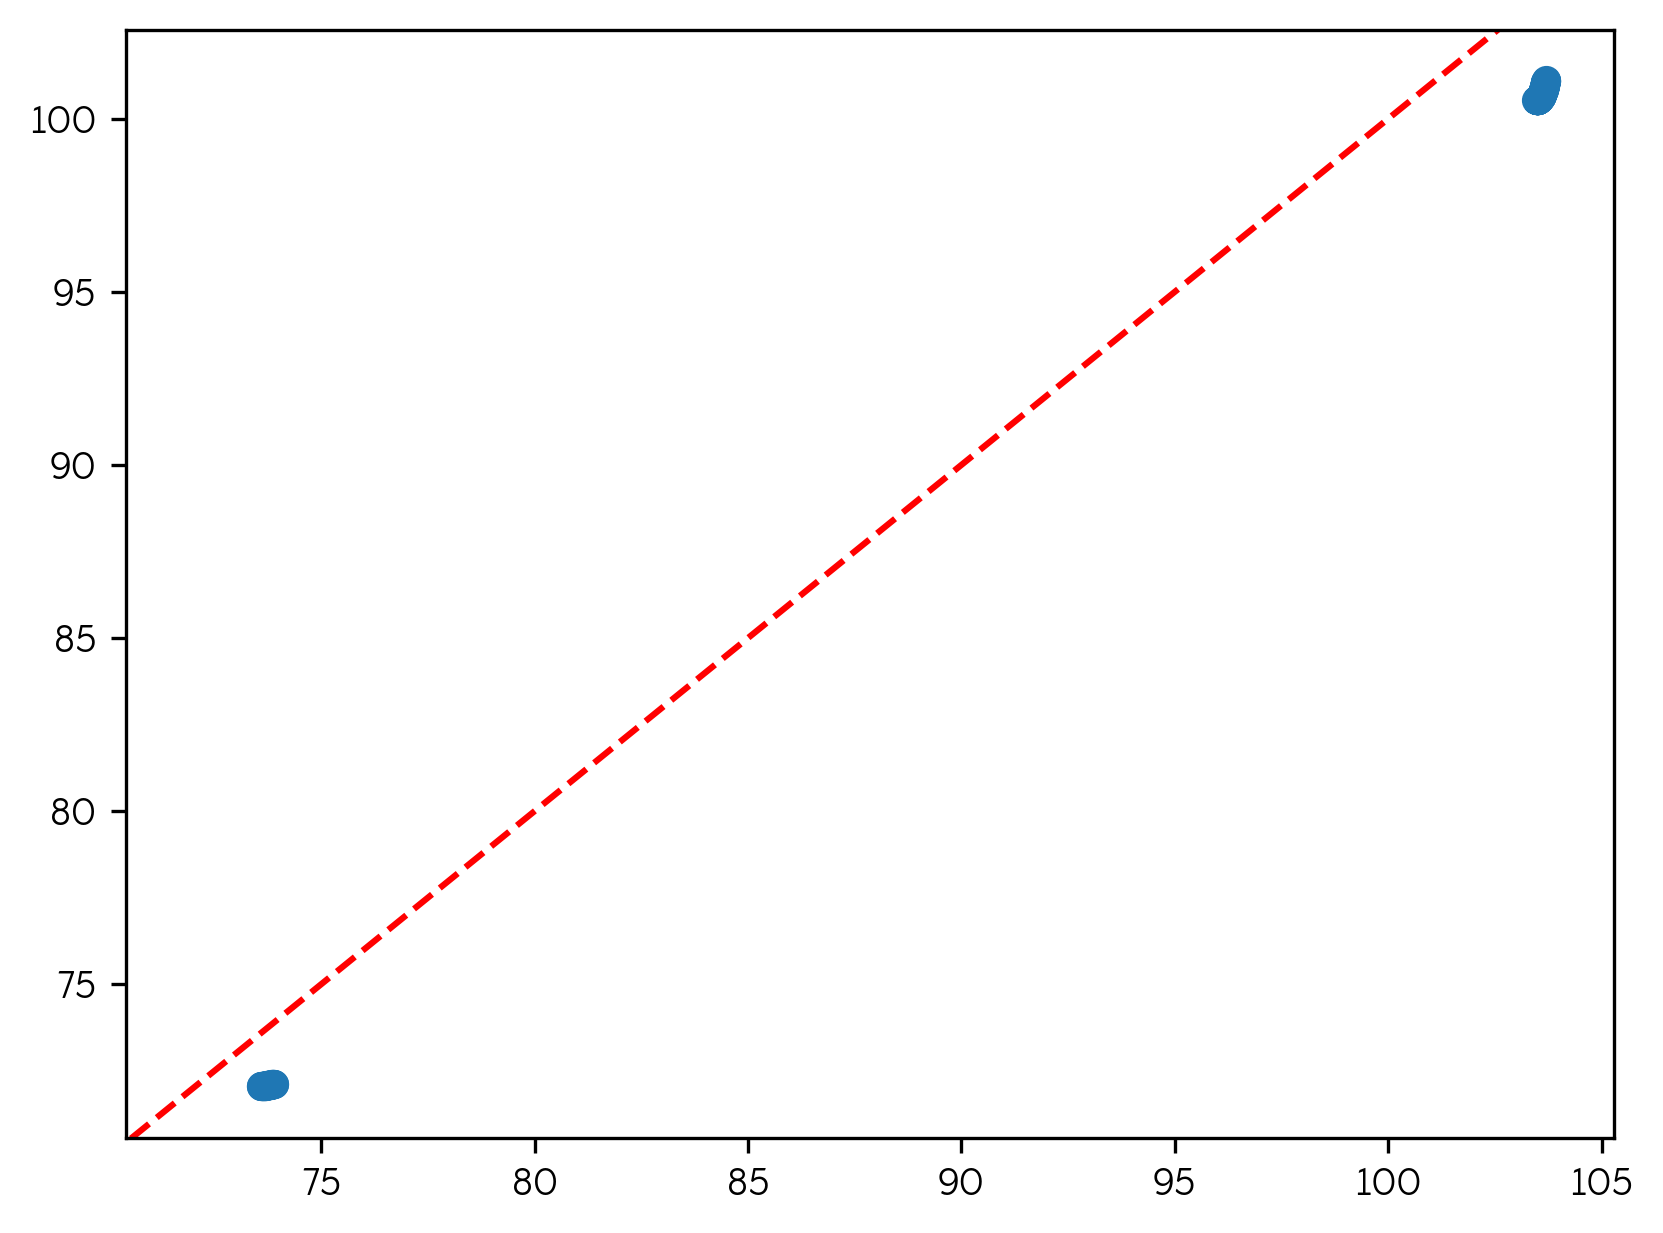

In [71]:
scenario = list(p_models.keys())[3]

olga_T = olga_dict[scenario].iloc[:, 5].values
olga_P = olga_dict[scenario].iloc[:, 3].values
olga_rho_interp = interpolator((olga_P, olga_T))

olga_dict[scenario]["interpolated_rho"] = olga_rho_interp

olga_rho = olga_dict[scenario].iloc[:, 7].values

# olga_dict[scenario]

fig, ax = plt.subplots()

ax.scatter(olga_rho, olga_rho_interp)

lowest_value = int(min(min(olga_rho), min(olga_rho_interp)))
ax.axline((lowest_value, lowest_value), slope=1, color="r", linestyle="--")

# Mixture 2

In [73]:
mix2_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=mix2_path_name)

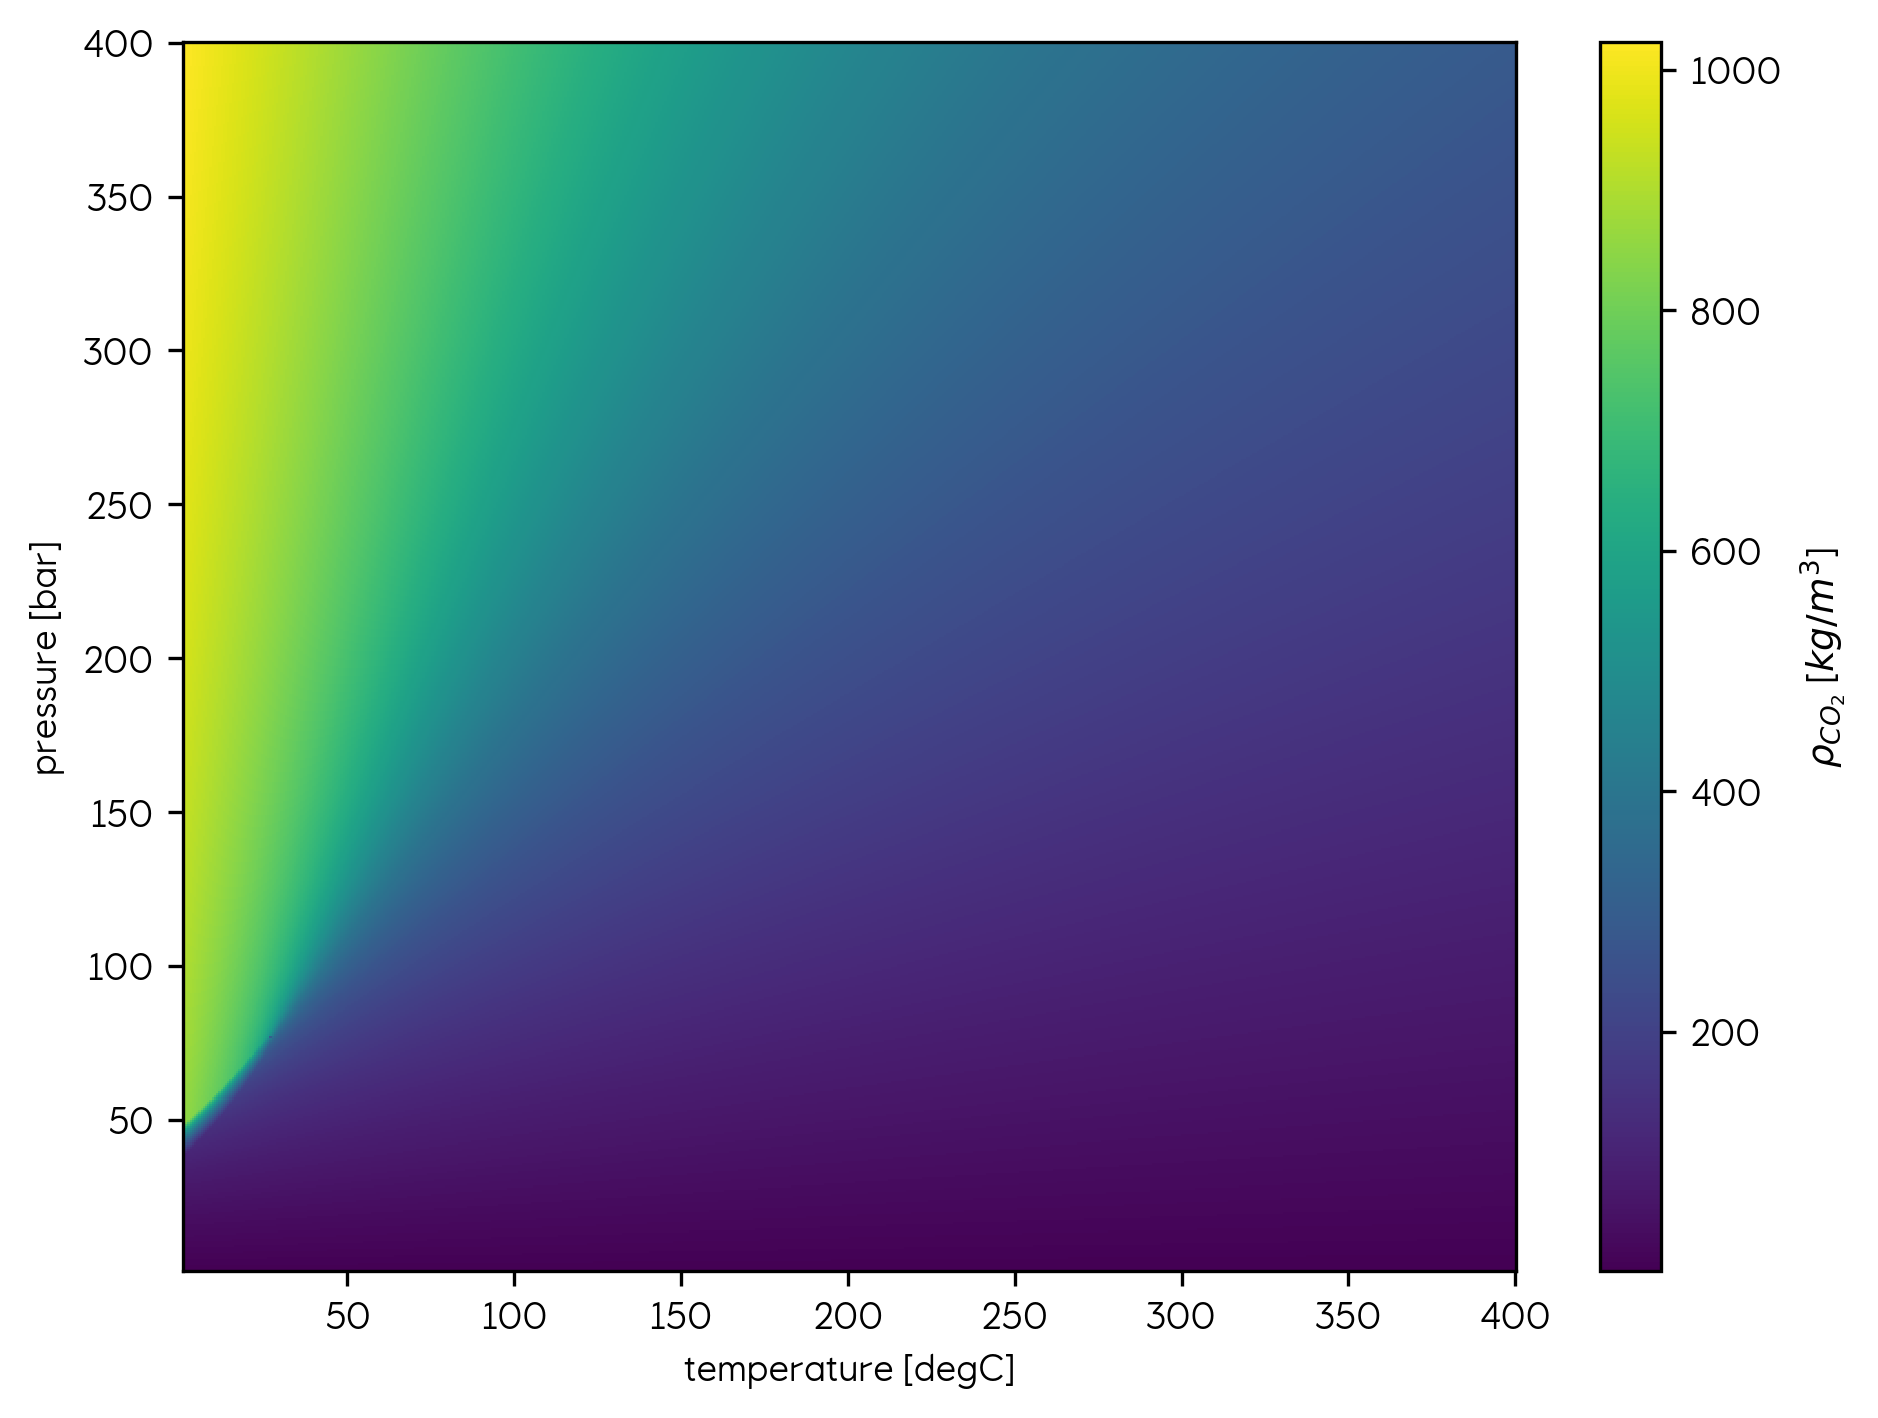

In [74]:
# Plot tables
fig, ax = plt.subplots()
# Plot density colormap
rho_pcm_co2 = ax.pcolormesh(mix2_pvt_data["temperature"], mix2_pvt_data["pressure"], mix2_pvt_data[mix2_path_name]["rho"])


ax.set_xlabel("temperature [degC]")

ax.set_ylabel("pressure [bar]")

fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")


fig.tight_layout()

In [75]:
olga_mix1_122 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=0, usecols=range(8))
olga_mix1_94 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=1, usecols=range(8))
olga_mix1_75 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=2, usecols=range(8))
olga_mix1_47 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=3, usecols=range(8))


olga_tables = [olga_mix1_122, olga_mix1_94, olga_mix1_75, olga_mix1_47]

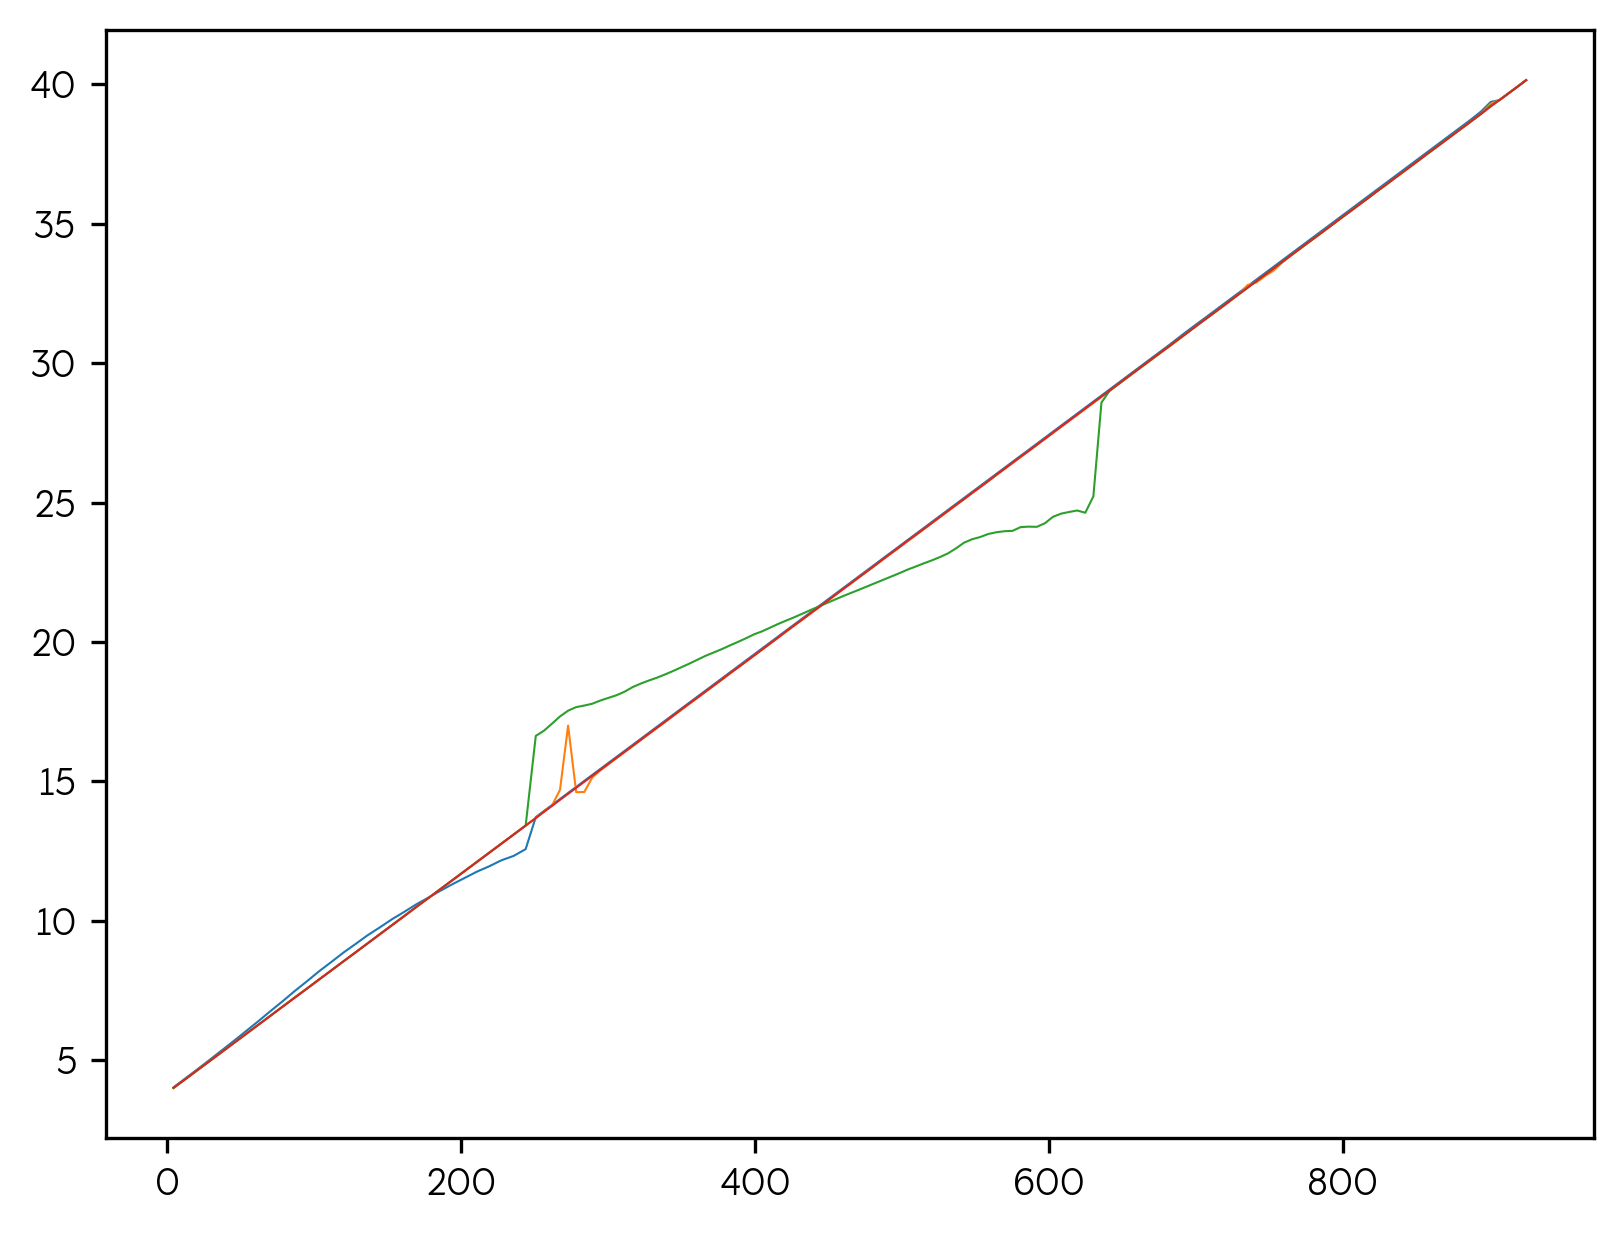

In [76]:
fig, ax = plt.subplots()

for table in olga_tables:
    ax.plot(table.iloc[:, 0], table.iloc[:, 7], lw=0.5)

# plt.plot(olga_pure_co2_122.iloc[:, 0], olga_pure_co2_122.iloc[:, 7], lw=0.5)
# plt.plot(olga_pure_co2_94.iloc[:, 0], olga_pure_co2_94.iloc[:, 7], lw=0.5)
# plt.plot(olga_pure_co2_75.iloc[:, 0], olga_pure_co2_75.iloc[:, 7], lw=0.5)
# plt.plot(olga_pure_co2_47.iloc[:, 0], olga_pure_co2_47.iloc[:, 7], lw=0.5)

In [77]:
sf_depth_msl = 312  # Water depth [meters]
sf_temp_degc = 4  # temperature at sea floor [degC]
field_fluid_type = "mixture1"

p_models = {}
olga_dict = {}

delta_z_cases = dict()

for olga_case in olga_tables:
    geo_tgrad = 1e3 * ((olga_case.iloc[-1, 7] - 4.000000) / (924.812500 - 4.133333))

    z_eq = ((olga_case.iloc[-1, 7] - sf_temp_degc) / (geo_tgrad / 1e3)) + sf_depth_msl

    delta_z = z_eq - olga_case.iloc[-1, 0]

    CO2_contact = z_eq  # CO2 water contact mTVDMSL
    press = olga_case.iloc[-1, 3]
    press_label = f"{press:.2f}"
    print(f"{press_label=}")
    delta_z_cases[press_label] = delta_z

    print(f"{geo_tgrad=} {sf_temp_degc:.2f} {CO2_contact=} {field_fluid_type=} {press=}")

    olga_dict[press_label] = olga_case
    # '''Constants'''

    # geo_tgrad = 40 #geothermal gradient [degc/km]
    p_models[press_label] = Pressure(
        # wellbore seafloor depth mTVD MSL.
        sf_depth_msl=sf_depth_msl,  # wellbore.water_depth,
        # wellbore total depth in mTVD RKB
        well_td_rkb=5e3,  # total_depth_rkb,
        # wellbore rkb in mTVD RKB
        well_rkb=0,
        # seafloor temperature in degC
        sf_temp=sf_temp_degc,  # DEFAULT_SEAFLOOR_TEMPERATURE,
        # geothermal gradient in degC/km
        geo_tgrad=geo_tgrad,  # DEFAULT_GEOTHERMAL_GRADIENT,
        fluid_type=field_fluid_type,  # type: ignore
        # path to the pvt constants folder
        pvt_path=pvt_path,
        z_fluid_contact=CO2_contact,  # wellbore_settings.pressure_datum_tvd_msl,  # type: ignore
        p_fluid_contact=press,  # wellbore_settings.reservoir_pressure_bar,  # type: ignore
        # specific_gravity=None,  # type: ignore
        # ip_shmin_data=shmin_data,
        shmin_gradient=0.3,
    )

press_label='122.66'
geo_tgrad=np.float64(39.26561259329613) 4.00 CO2_contact=np.float64(1232.6791670000002) field_fluid_type='mixture1' press=np.float64(122.657897949219)


Computing pressure profile for scenario: hydrostatic
press_label='94.99'
geo_tgrad=np.float64(39.26661942767323) 4.00 CO2_contact=np.float64(1232.6791669999998) field_fluid_type='mixture1' press=np.float64(94.9892807006836)
Computing pressure profile for scenario: hydrostatic
press_label='75.00'
geo_tgrad=np.float64(39.26327574313713) 4.00 CO2_contact=np.float64(1232.679167) field_fluid_type='mixture1' press=np.float64(74.9971694946289)
Computing pressure profile for scenario: hydrostatic
press_label='47.74'
geo_tgrad=np.float64(39.26988853188507) 4.00 CO2_contact=np.float64(1232.6791669999998) field_fluid_type='mixture1' press=np.float64(47.7425003051758)
Computing pressure profile for scenario: hydrostatic


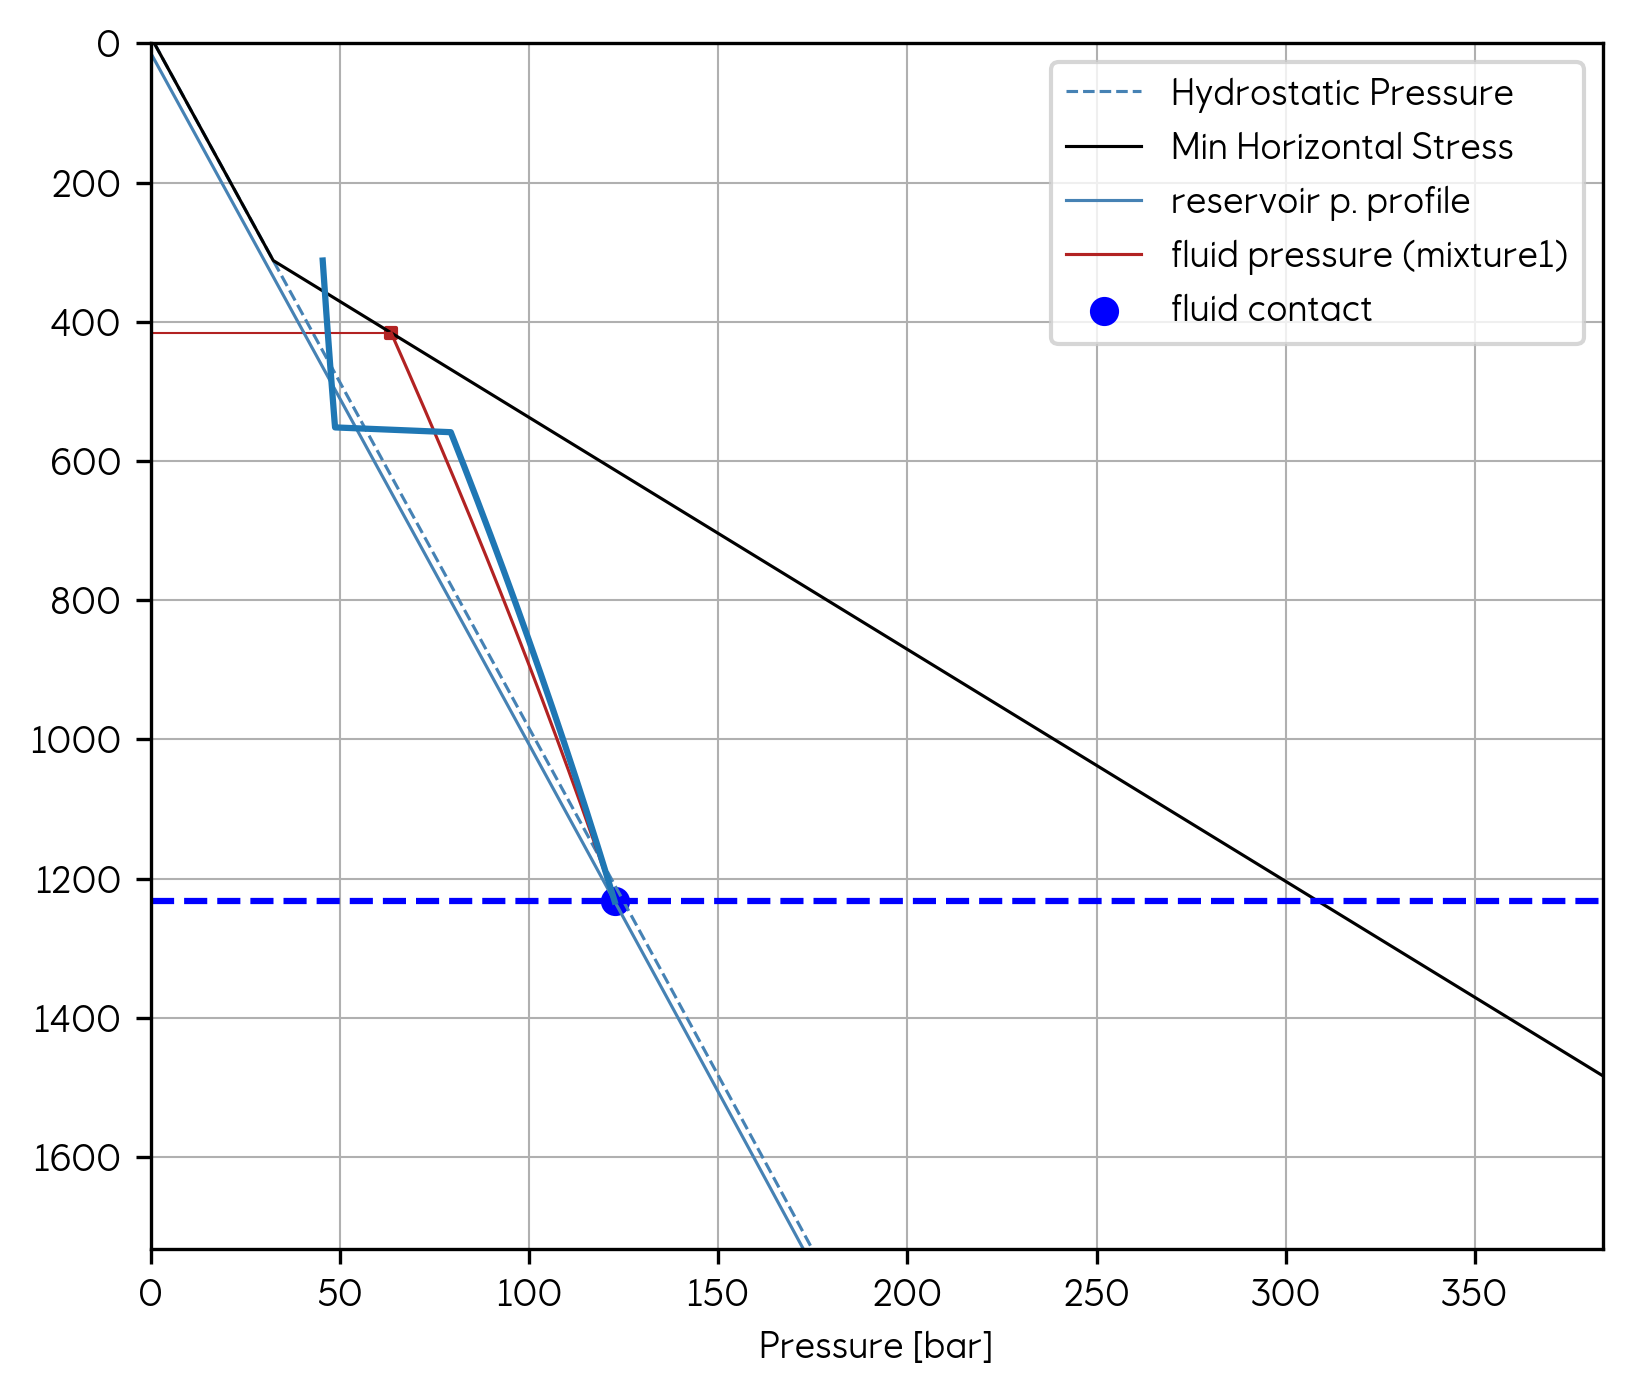

In [78]:
rcParams["figure.dpi"] = 300

width_cm = 14  # cm
height_cm = 12  # cm

width = width_cm / 2.54
height = height_cm / 2.54

fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(olga_dict.keys())[0]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

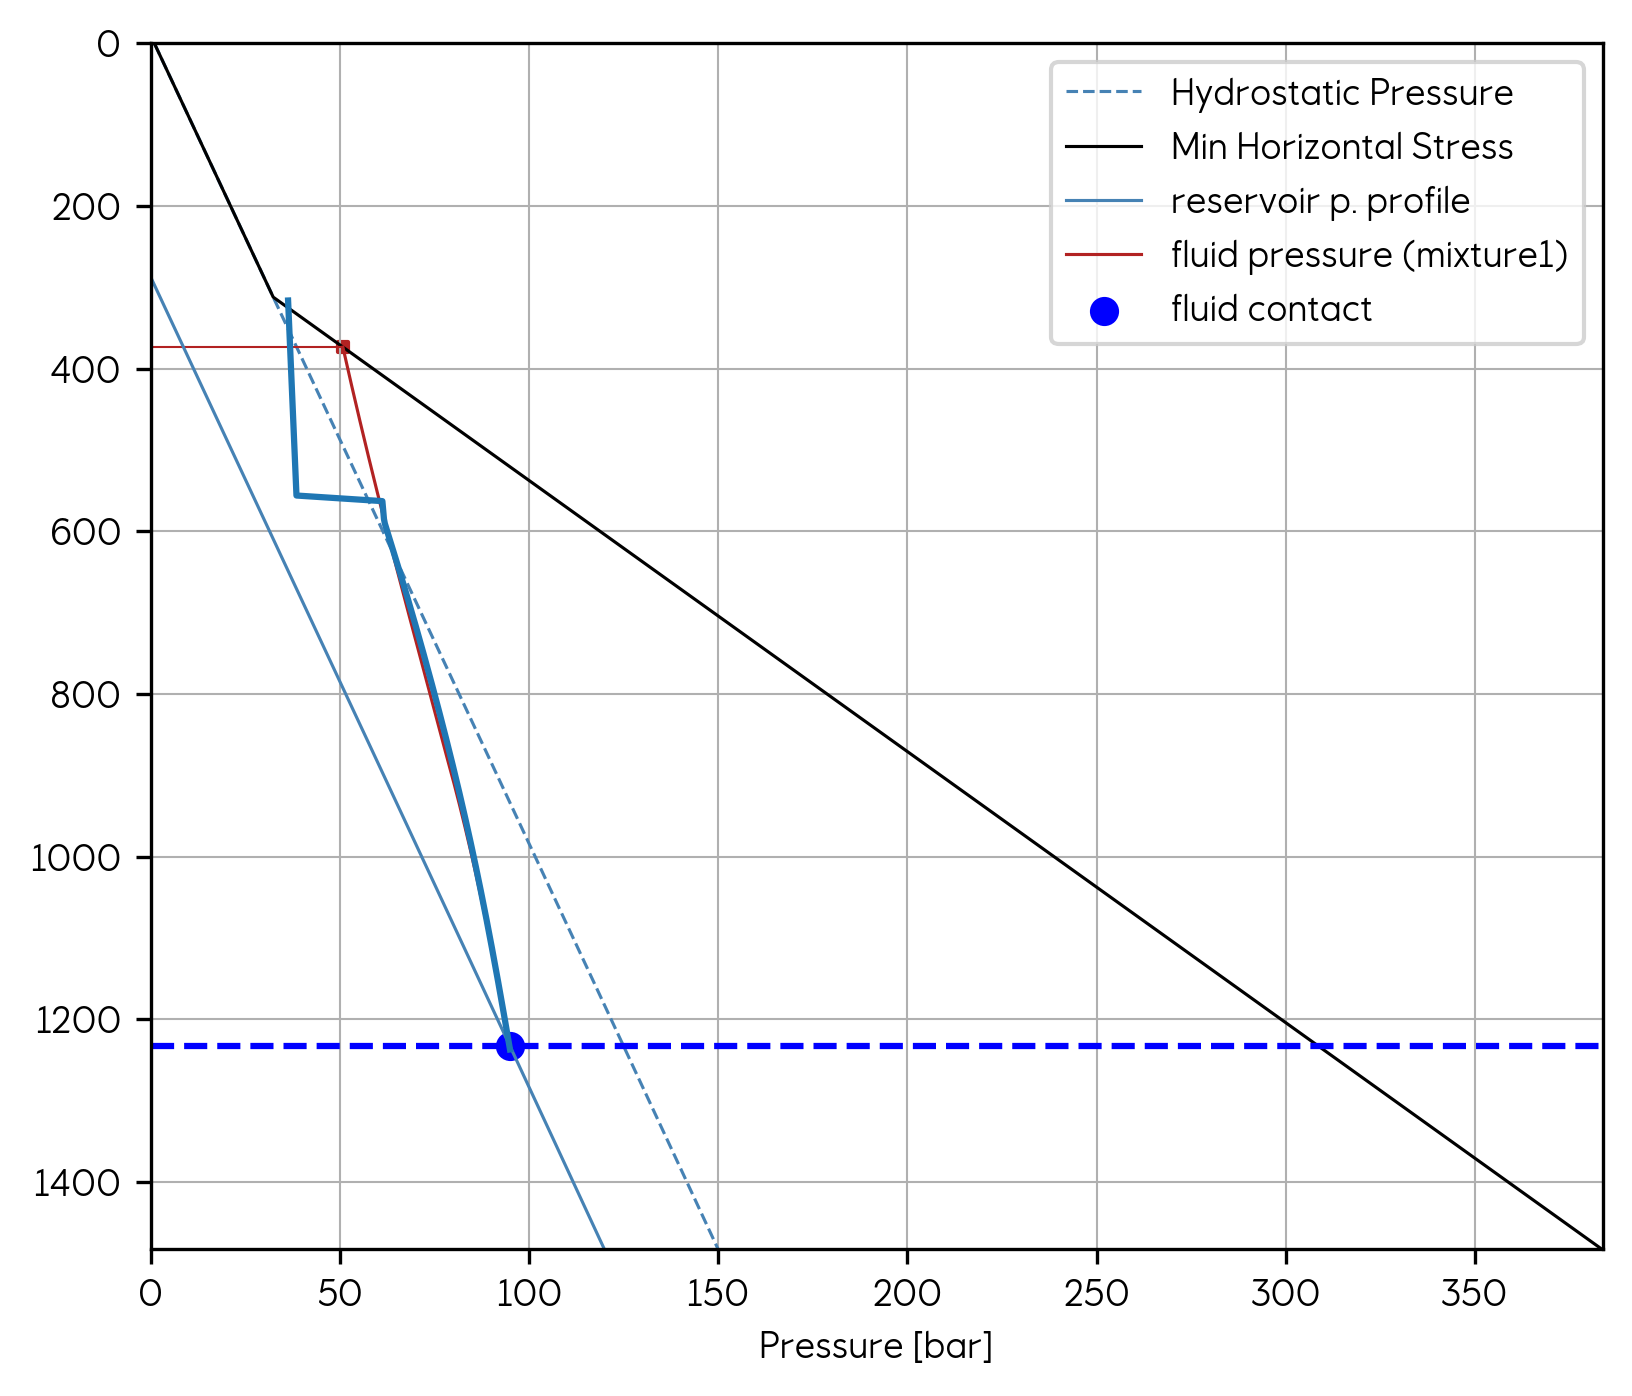

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[1]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 250)
fig.tight_layout()

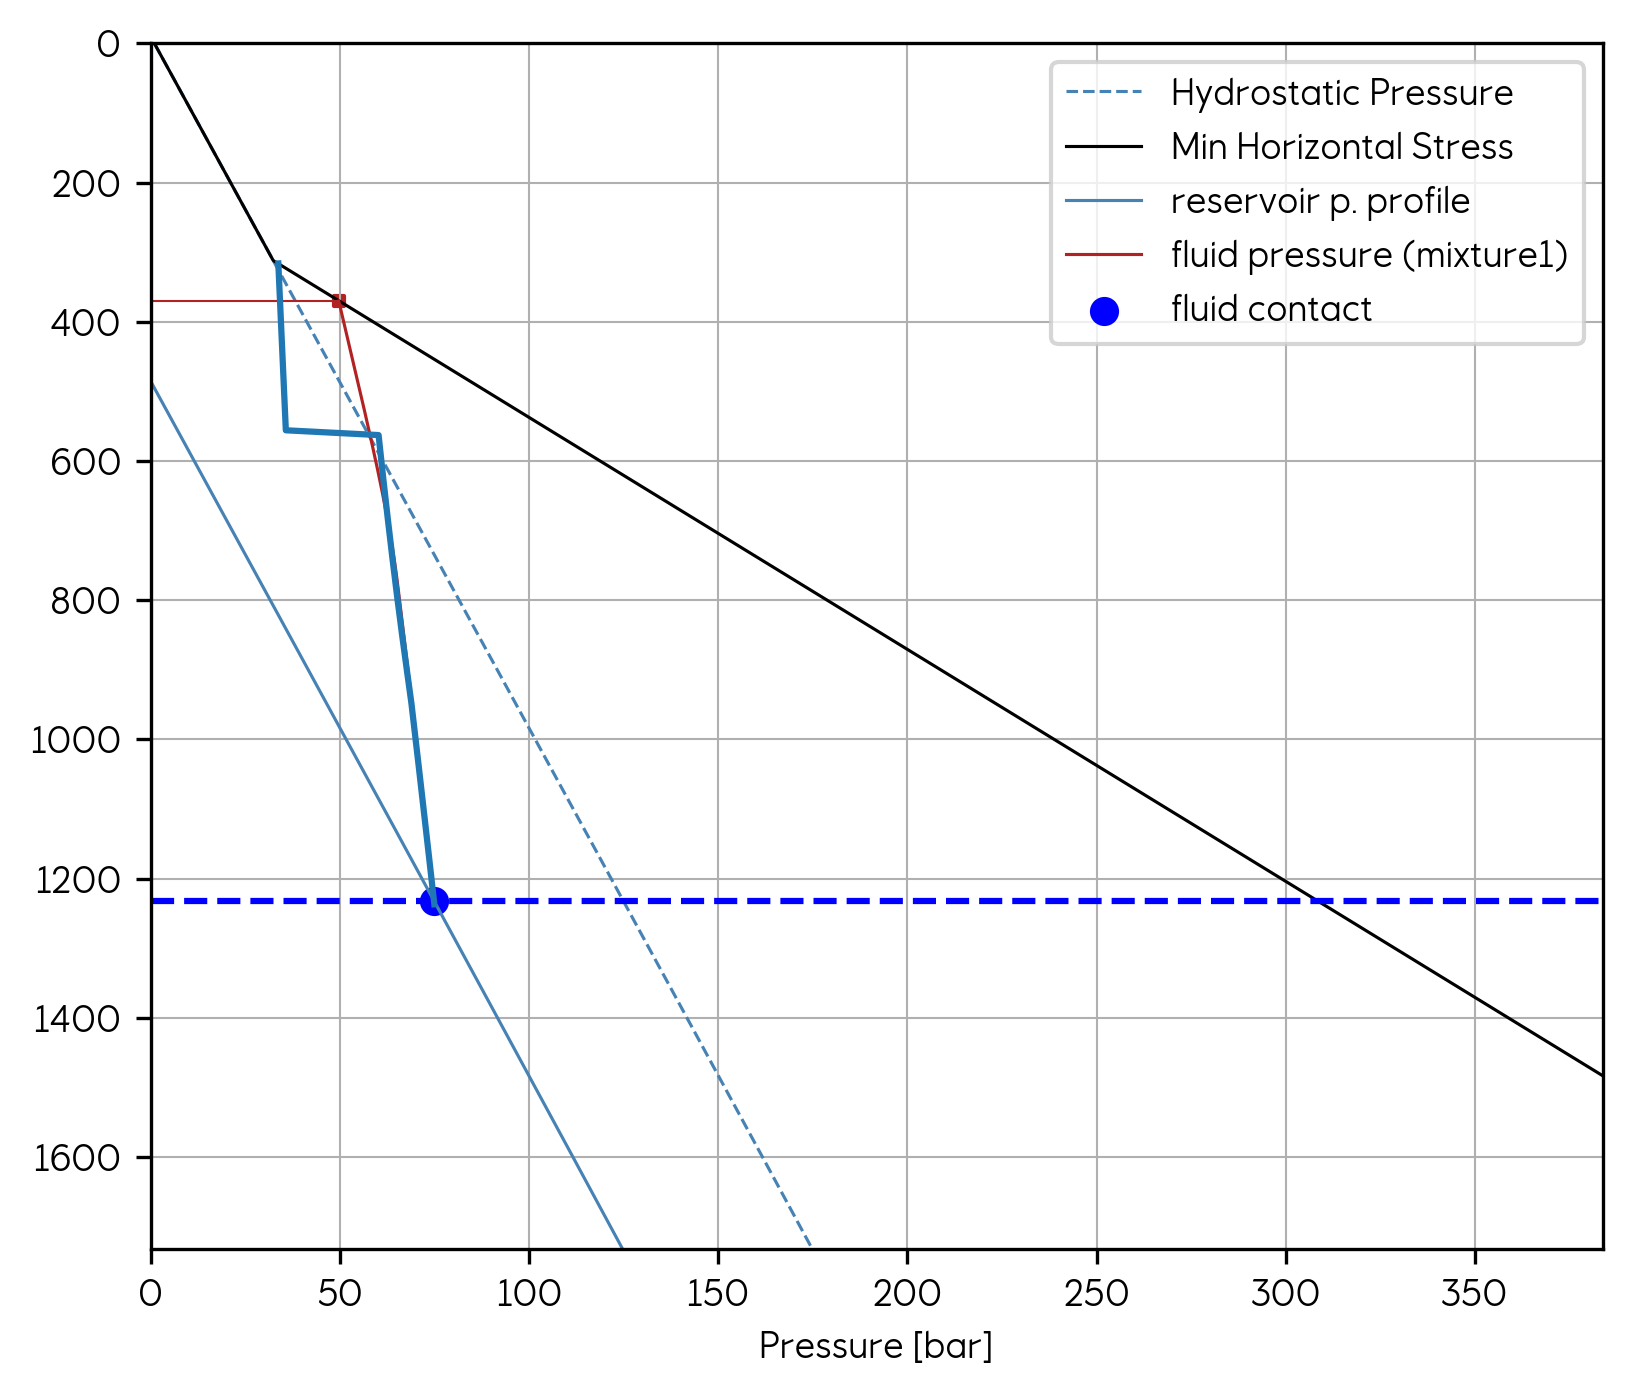

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[2]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

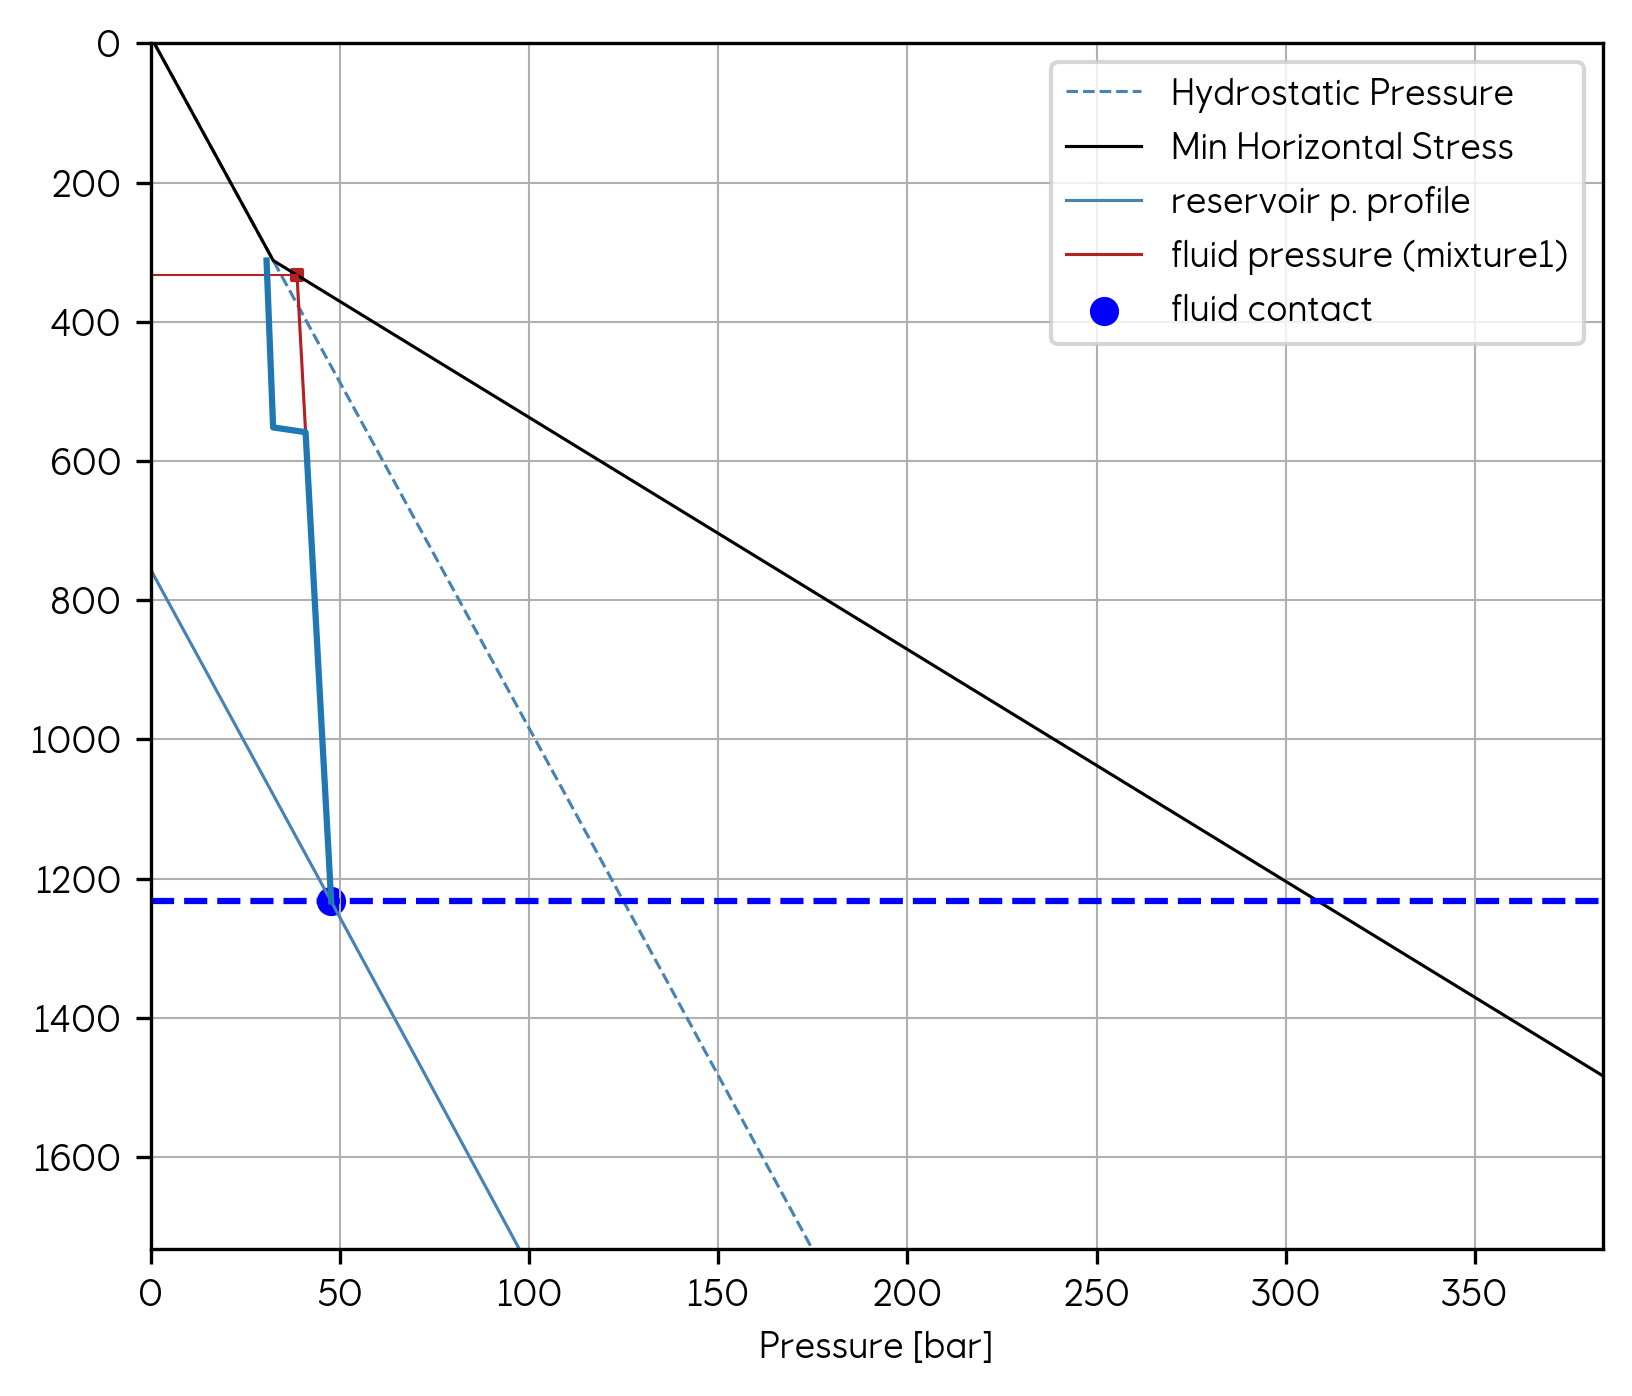

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[3]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

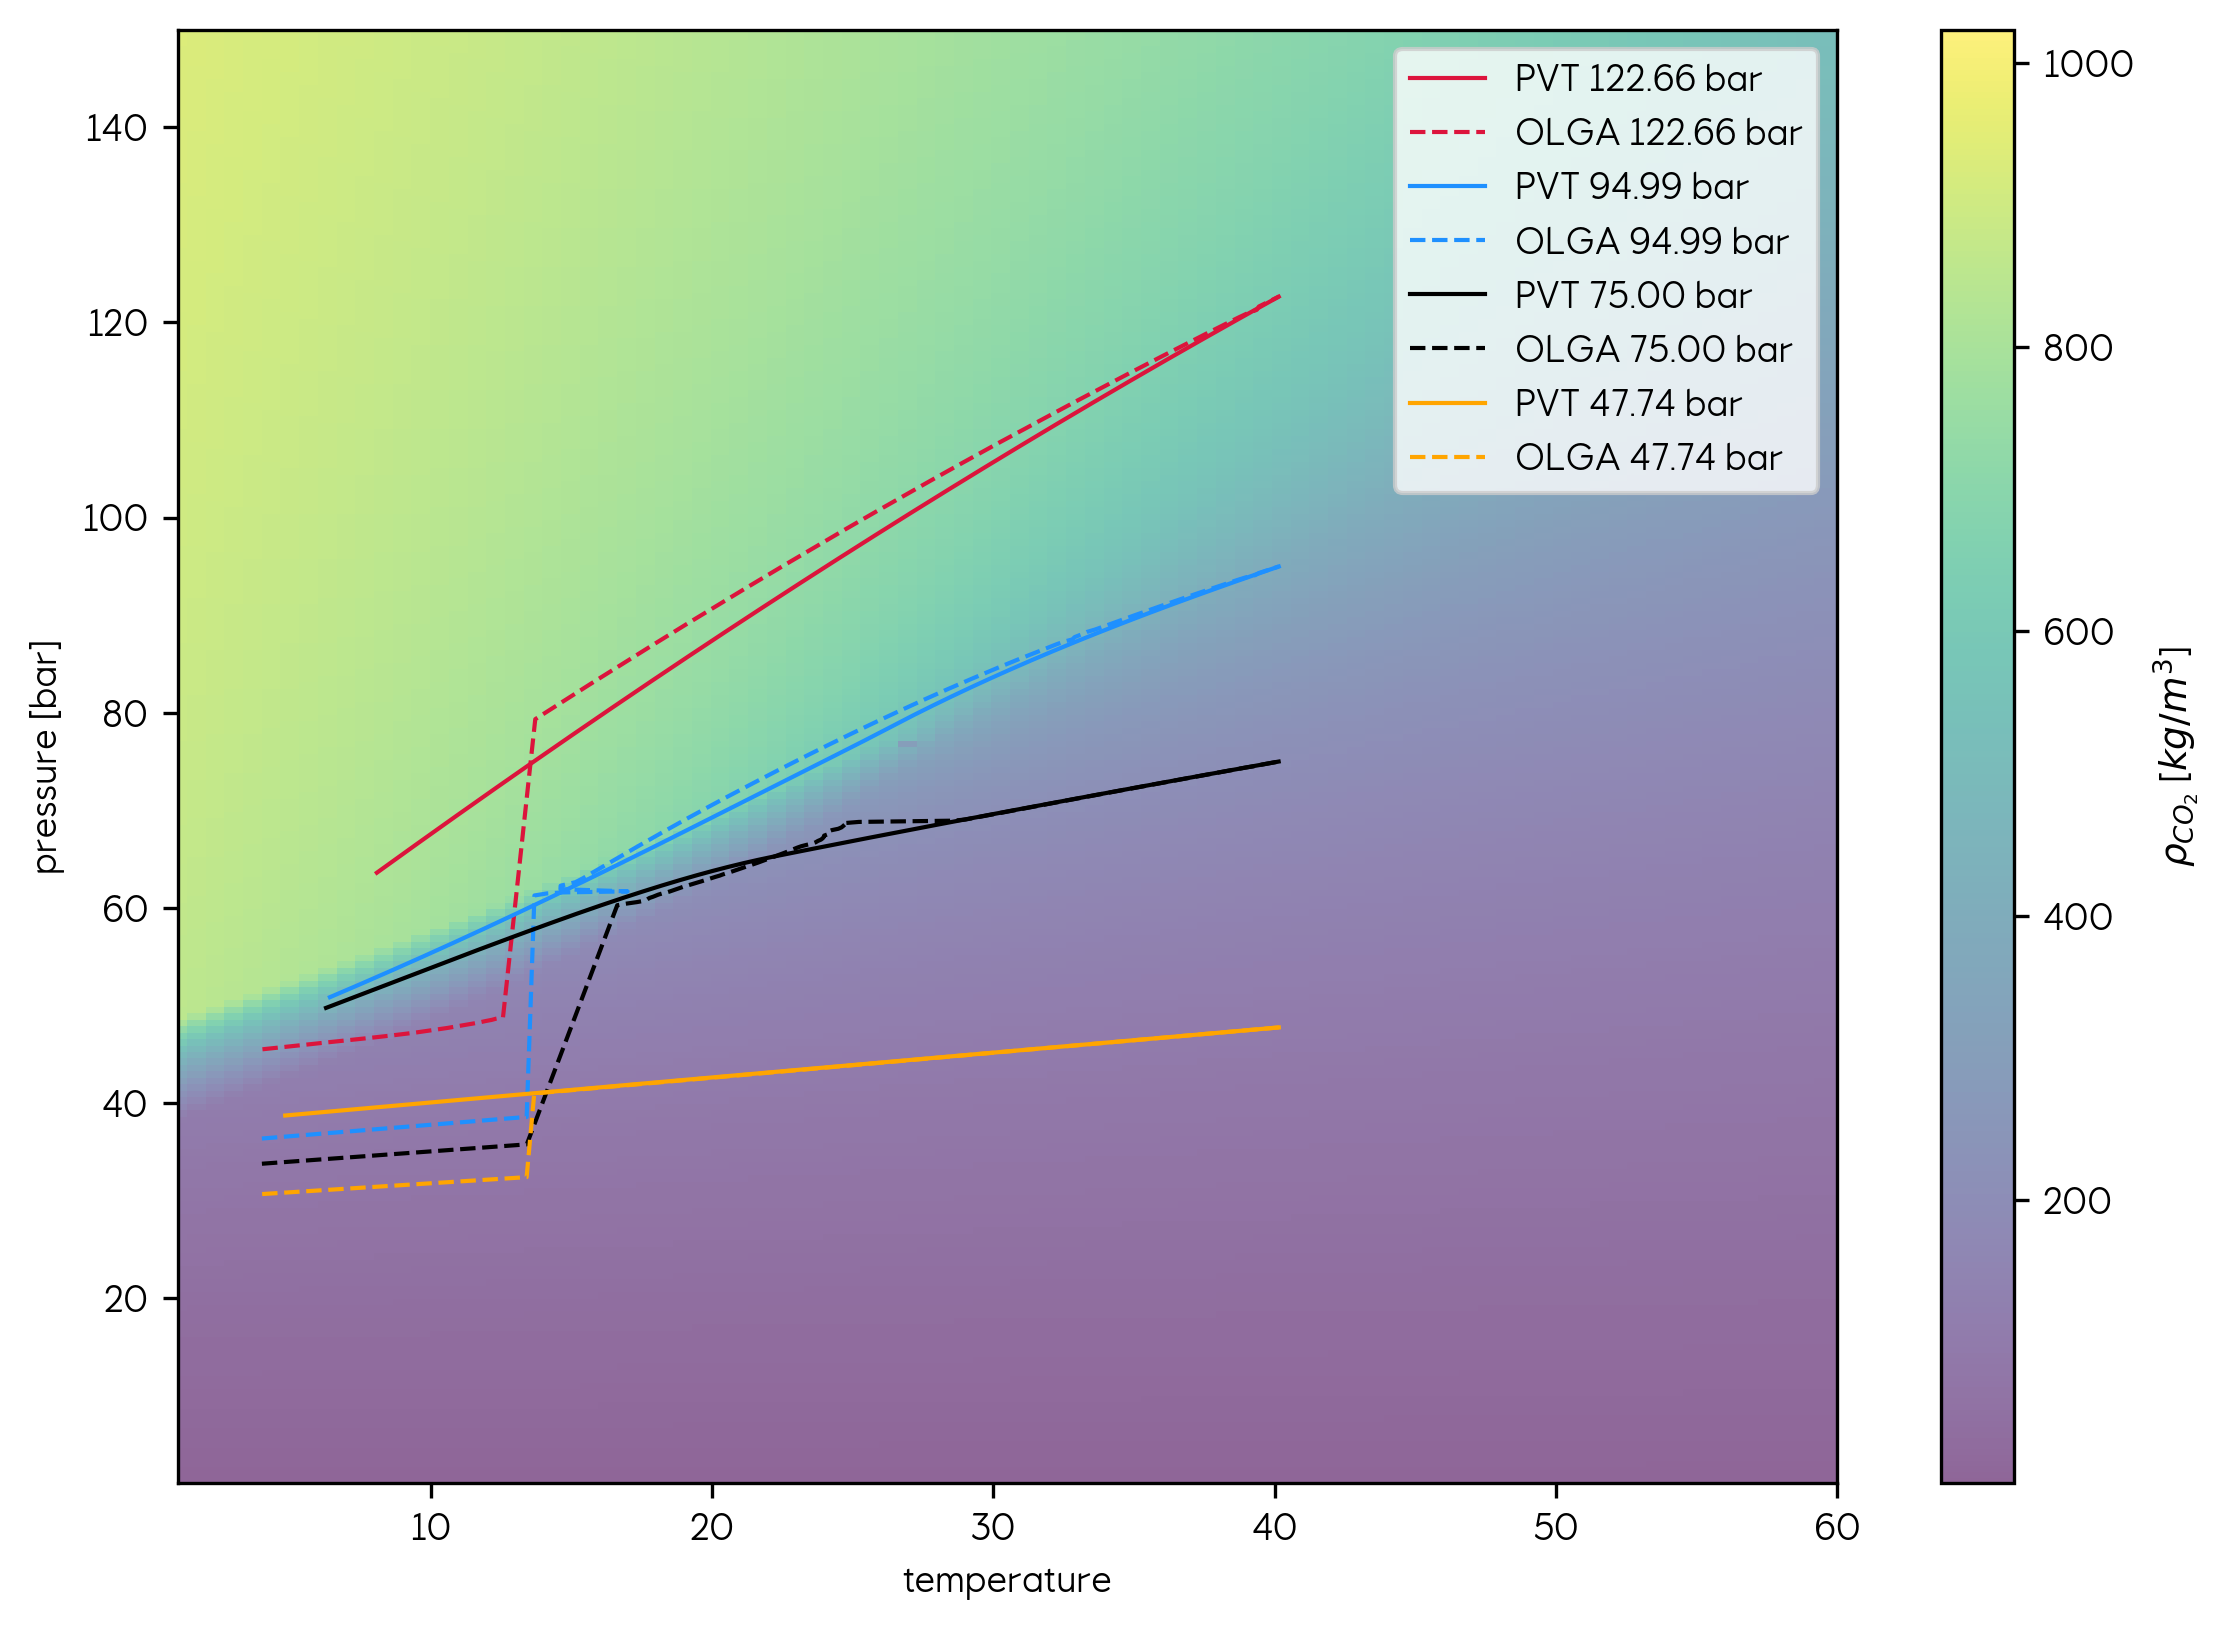

In [82]:
# Plot tables
from itertools import cycle

height = 13.98 / (const.inch * 100)
width = 19.5 / (const.inch * 100)

fig, ax = plt.subplots(1, 1, figsize=(width, height))
# Plot density colormap
rho_pcm_mix2 = ax.pcolormesh(mix2_pvt_data["temperature"], mix2_pvt_data["pressure"], mix2_pvt_data[mix2_path_name]["rho"], alpha=0.6)

ax.set_xlabel("temperature [degC]")
ax.set_ylabel("pressure [bar]")

color_cycle = cycle(["#DC143C", "#1E90FF", "k", "#FFA500"])


# ax.plot(olga_pure_co2_122.iloc[:,7], olga_pure_co2_122.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_94.iloc[:,7], olga_pure_co2_94.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_75.iloc[:,7], olga_pure_co2_75.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_47.iloc[:,7], olga_pure_co2_47.iloc[:,3], color=next(color_cycle))

for scenario, color in zip(p_models, color_cycle):
    p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves.plot(
        "temperature", "fluid_pressure", ax=ax, color=color, label=f"PVT {scenario} bar", lw=1
    )

    ax.plot(olga_dict[scenario].iloc[:, 7], olga_dict[scenario].iloc[:, 3], color=color, ls="--", label=f"OLGA {scenario} bar", lw=1)

ax.set_xlim(1, 60)

ax.set_ylim(1, 150)
ax.legend()

fig.colorbar(rho_pcm_mix2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")


fig.tight_layout()